In [1]:
import numpy as np 
import torch
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
from openpyxl import Workbook
def export_matrix_to_excel(matrix, filename):
  """
  Xuất ma trận numpy.ndarray sang file Excel.

  Args:
    matrix: Ma trận numpy.ndarray cần xuất.
    filename: Tên file Excel (ví dụ: 'matrix.xlsx').
  """
  wb = Workbook()
  ws = wb.active

  for row in matrix:
    ws.append(row.tolist())  # Chuyển đổi numpy.ndarray sang list

  wb.save(filename)

# Tạo ma trận numpy.ndarray ví dụ
matrix = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# Gọi hàm để xuất ma trận

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def kmeans_clustering(data, m):
    """
    Phân cụm N điểm dữ liệu hai chiều bằng phương pháp K-means clustering.
    Trước khi phân cụm, rescale dữ liệu theo min-max scaling.
    Số K tăng dần từ 2, dừng tăng khi thỏa mãn điều kiện sau:
    Điều kiện: Khoảng cách trên chiều x của hai điểm dữ liệu trong một cụm
    không quá m (tham số input) của function

    Args:
      data: Numpy array, N điểm dữ liệu 2 chiều.
      m: Giá trị khoảng cách tối đa trên chiều x.

    Returns:
      Numpy array, nhãn của các điểm dữ liệu.
    """

    # Rescale dữ liệu theo min-max scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    K = 2
    while True:
        kmeans = KMeans(n_clusters=K)
        labels = kmeans.fit_predict(scaled_data)

        # Kiểm tra điều kiện khoảng cách
        condition_met = True
        for i in range(K):
            cluster_points = data[labels == i]
            max_x_diff = np.max(cluster_points[:, 0]) - np.min(cluster_points[:, 0])
            if max_x_diff > m:
                condition_met = False
                break

        if condition_met:
            break
        K += 1

    return labels

In [4]:
num_adc_bits = 16
num_adc_samples = 128
num_rx = 4
num_tx = 3
num_lanes = 2 
is_real = 0
num_chirps_in_frame = 256


In [5]:
f0 = 60      # min frequency
B = 3239     # sweep bandwidth
S = 54       # sweep slope
fs = 4000    # sampling freq
Nc = 256     # num chirps in 1 frame
Ns = 128     # num samples of 1 chirp 
c0 = 3e+8
idle_time = 5e-6

fc = f0+B/2000   
lamda = c0/(fc*1e+9)
Tc= idle_time + (B/S)*(1e-6)

R_res = c0 / (2e+6*B)       
R_max = fs*c0 / (2e+9*S)
velocity_res = lamda/(2*Nc*Tc)
v_max = lamda/(4*Tc)

print(R_res)
print(R_max)
print(velocity_res)
print(v_max)

0.04631058968817536
11.11111111111111
0.14633341751423926
18.730677441822625


In [6]:

def adc_processing(adc_data):
    if num_adc_bits != 16: 
        l_max = 2**(num_adc_bits-1) -1 
        adc_data[adc_data>l_max] -= 2**num_adc_bits 

    file_size = adc_data.size
    num_chirps = file_size // (2 * num_adc_samples * num_rx)
    file_size = num_chirps * (2 * num_adc_samples * num_rx)
    adjusted_size = (file_size//4) * 4

    lvds = np.zeros((file_size//2), dtype = complex)
    lvds[0::2] = adc_data[0:adjusted_size:4] + 1j*adc_data[2:adjusted_size:4]
    lvds[1::2] = adc_data[1:adjusted_size:4] + 1j*adc_data[3:adjusted_size:4]
    lvds = lvds.reshape((num_chirps), num_adc_samples*num_rx)

    new_adc_data = np.zeros((num_rx, num_chirps * num_adc_samples), dtype = np.complex128)
    for row in range(num_rx):
        for i in range(num_chirps):
            new_adc_data[row, i*num_adc_samples:(i+1)*num_adc_samples] = lvds[i, row*num_adc_samples:(row+1)*num_adc_samples]

    rx1 = np.reshape(new_adc_data[0,:],(num_chirps,128)) 
    rx1_tx1 = rx1[0::3]

    num_frames = num_chirps // (num_chirps_in_frame*num_tx)
    data = rx1_tx1[0:num_frames*num_chirps_in_frame]
    data = data.reshape((num_frames,num_chirps_in_frame,num_adc_samples))

    print(num_frames)

    return data


In [7]:
def doppler_fft_without_butter(data): 
    data_time = data
    tmp = np.fft.fft(data_time, axis = 0)
    doppler_fft = np.fft.fft(tmp, axis = 1)
    return doppler_fft

In [8]:
def doppler_fft(data): 
    data_time = data
    tmp = np.fft.fft(data_time, axis = 0)

    b, a = signal.butter(4, 0.0075, 'high')
    data_range = signal.lfilter(b, a, tmp, axis = 1)

    doppler_fft = np.fft.fft(data_range, axis = 1)
    return doppler_fft

In [9]:
file_name = "Khanh_ngang_2_ban.bin"
with open(file_name,'rb') as fid:
    adc_data = np.fromfile(fid, dtype = np.int16)

data = adc_processing(adc_data)
#RD_map = doppler_fft(data)

315


In [10]:
def plot_original(i):
    data_test = doppler_fft_without_butter(data[i].T)
    # velocity - range
    # Compute the magnitude of the Doppler FFT
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(20 * np.log10(doppler_magnitude), aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1] - 70, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

In [11]:
def update_column(matrix, N):
    # Xử lý việc cập nhật cột thứ N
    M = len(matrix)  # kích thước của ma trận MxM
    
    # Duyệt qua từng phần tử của cột N (trừ các phần tử đầu và cuối vì không có đủ phần tử bên trái hoặc phải)
    for i in range(M):
        # Tính giá trị trung bình cộng của phần tử bên trái và bên phải
        matrix[i][N] = (matrix[i][N - 1] + matrix[i][N + 1]) / 2
    
    return matrix

In [12]:
def plot_mid_remove(i):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[0], clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

In [13]:
def plot_bf_cluster(i):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)

    output_test[output_test > 70] = 100
    output_test[output_test <= 70] = 0
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[0], clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

In [14]:
def plot_af_cluster(i):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)

    output_test[output_test > 70] = 100
    output_test[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test == 100))
    db = DBSCAN(eps=3, min_samples=3)
    labels = db.fit_predict(indices)

    label_counts = Counter(labels)

    # Bước 2: Tìm cụm có số phần tử nhiều nhất
    most_frequent_label = label_counts.most_common(1)[0][0]

    # Bước 3: Gán nhãn mới
    new_labels = [0 if label == most_frequent_label else 1 for label in labels]

    # Gán nhãn cho ma trận Y (cùng kích thước với ma trận X)
    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
            Y[indices[i, 0], indices[i, 1]] = label + 1  # Gán nhãn bắt đầu từ 1

    # Vẽ hình ảnh trực quan của ma trận Y (các cụm được gán nhãn)
    plt.figure(figsize=(30, 12))
    plt.imshow(Y, cmap='tab20', interpolation='nearest')
    plt.title('DBSCAN Clustering on Matrix X')
    plt.colorbar(label='Cluster Label')
    plt.show()

In [15]:
def plot_final(i):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)

    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = DBSCAN(eps=3, min_samples=3)
    labels = db.fit_predict(indices)

    label_counts = Counter(labels)

    # Bước 2: Tìm cụm có số phần tử nhiều nhất
    most_frequent_label = label_counts.most_common(1)[0][0]

    # Bước 3: Gán nhãn mới
    new_labels = [1 if label == most_frequent_label else 0 for label in labels]

    # Gán nhãn cho ma trận Y (cùng kích thước với ma trận X)
    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
            Y[indices[i, 0], indices[i, 1]] = label # Gán nhãn bắt đầu từ 1

    mean = np.mean(output_test)
    output_test[Y<0.5] = mean

    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]- 40, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

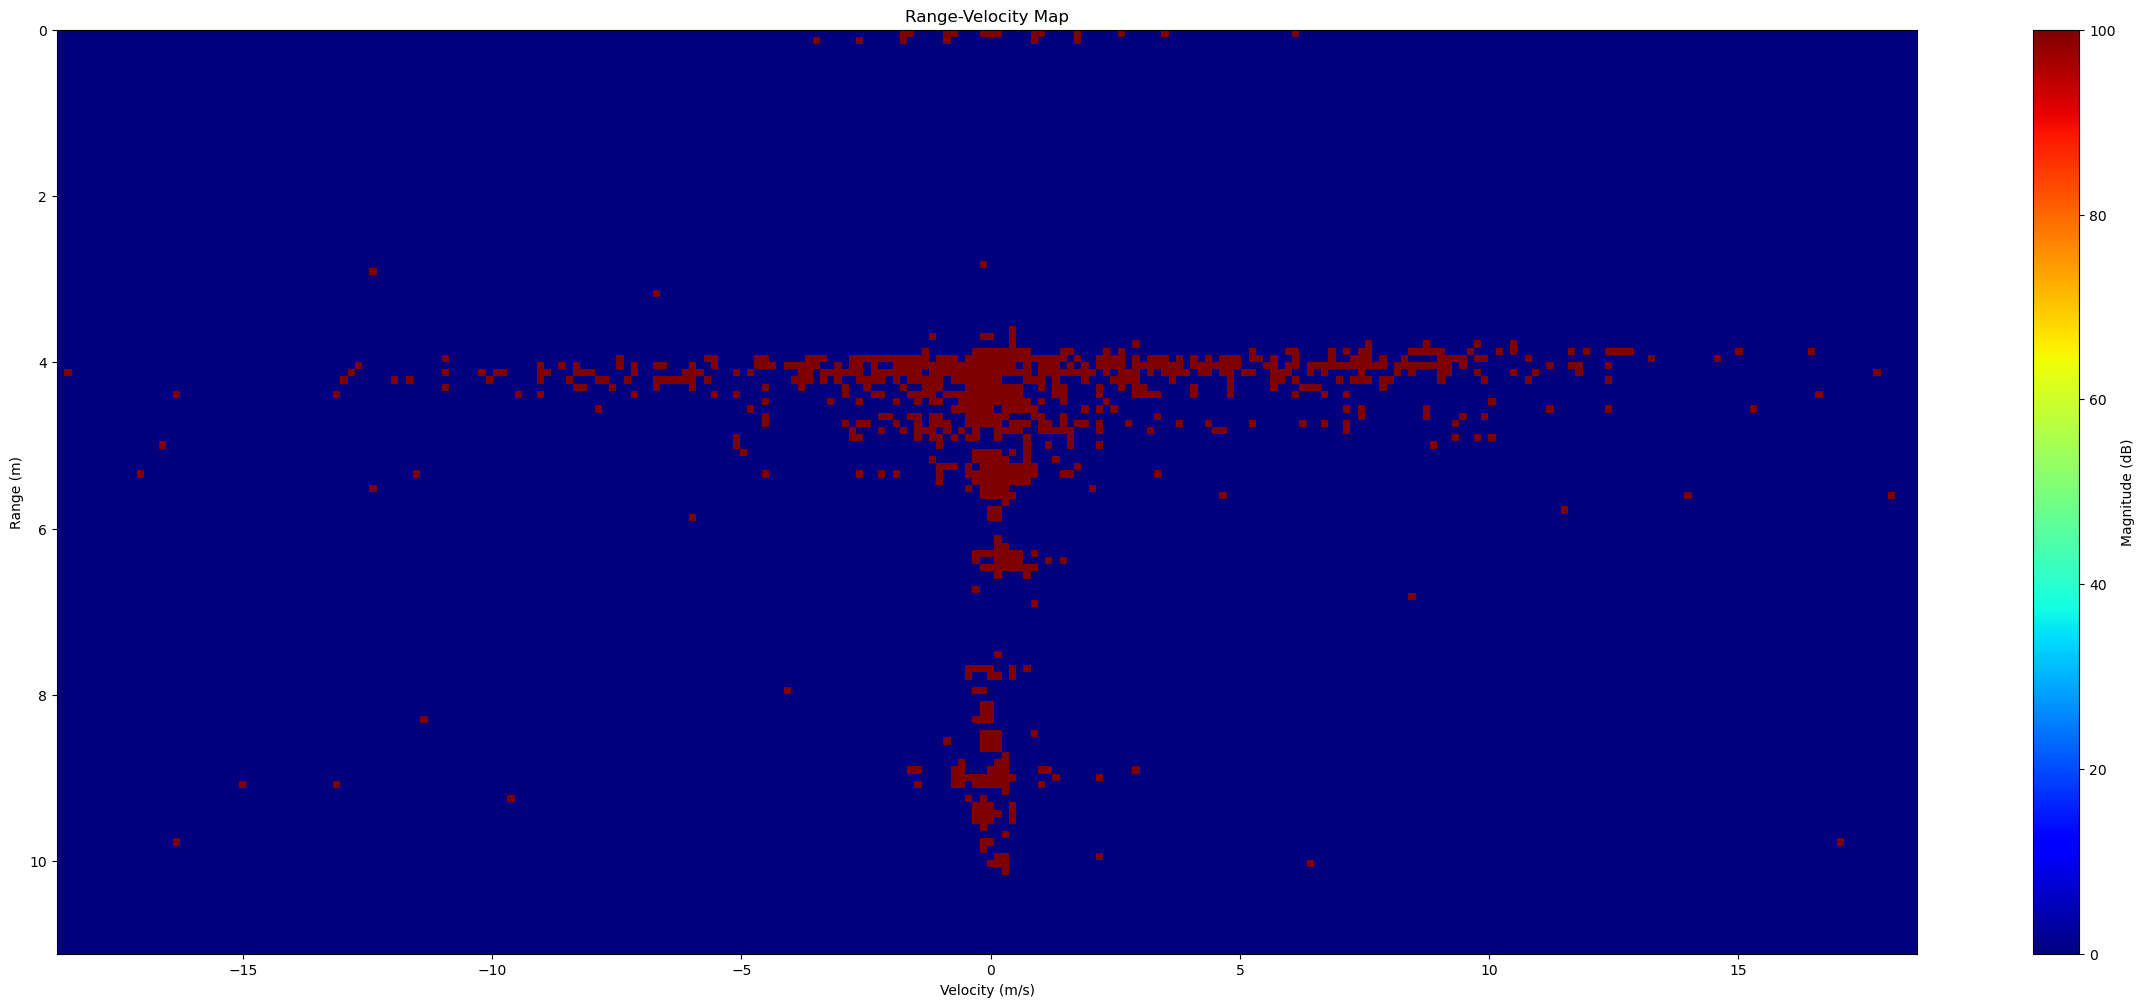

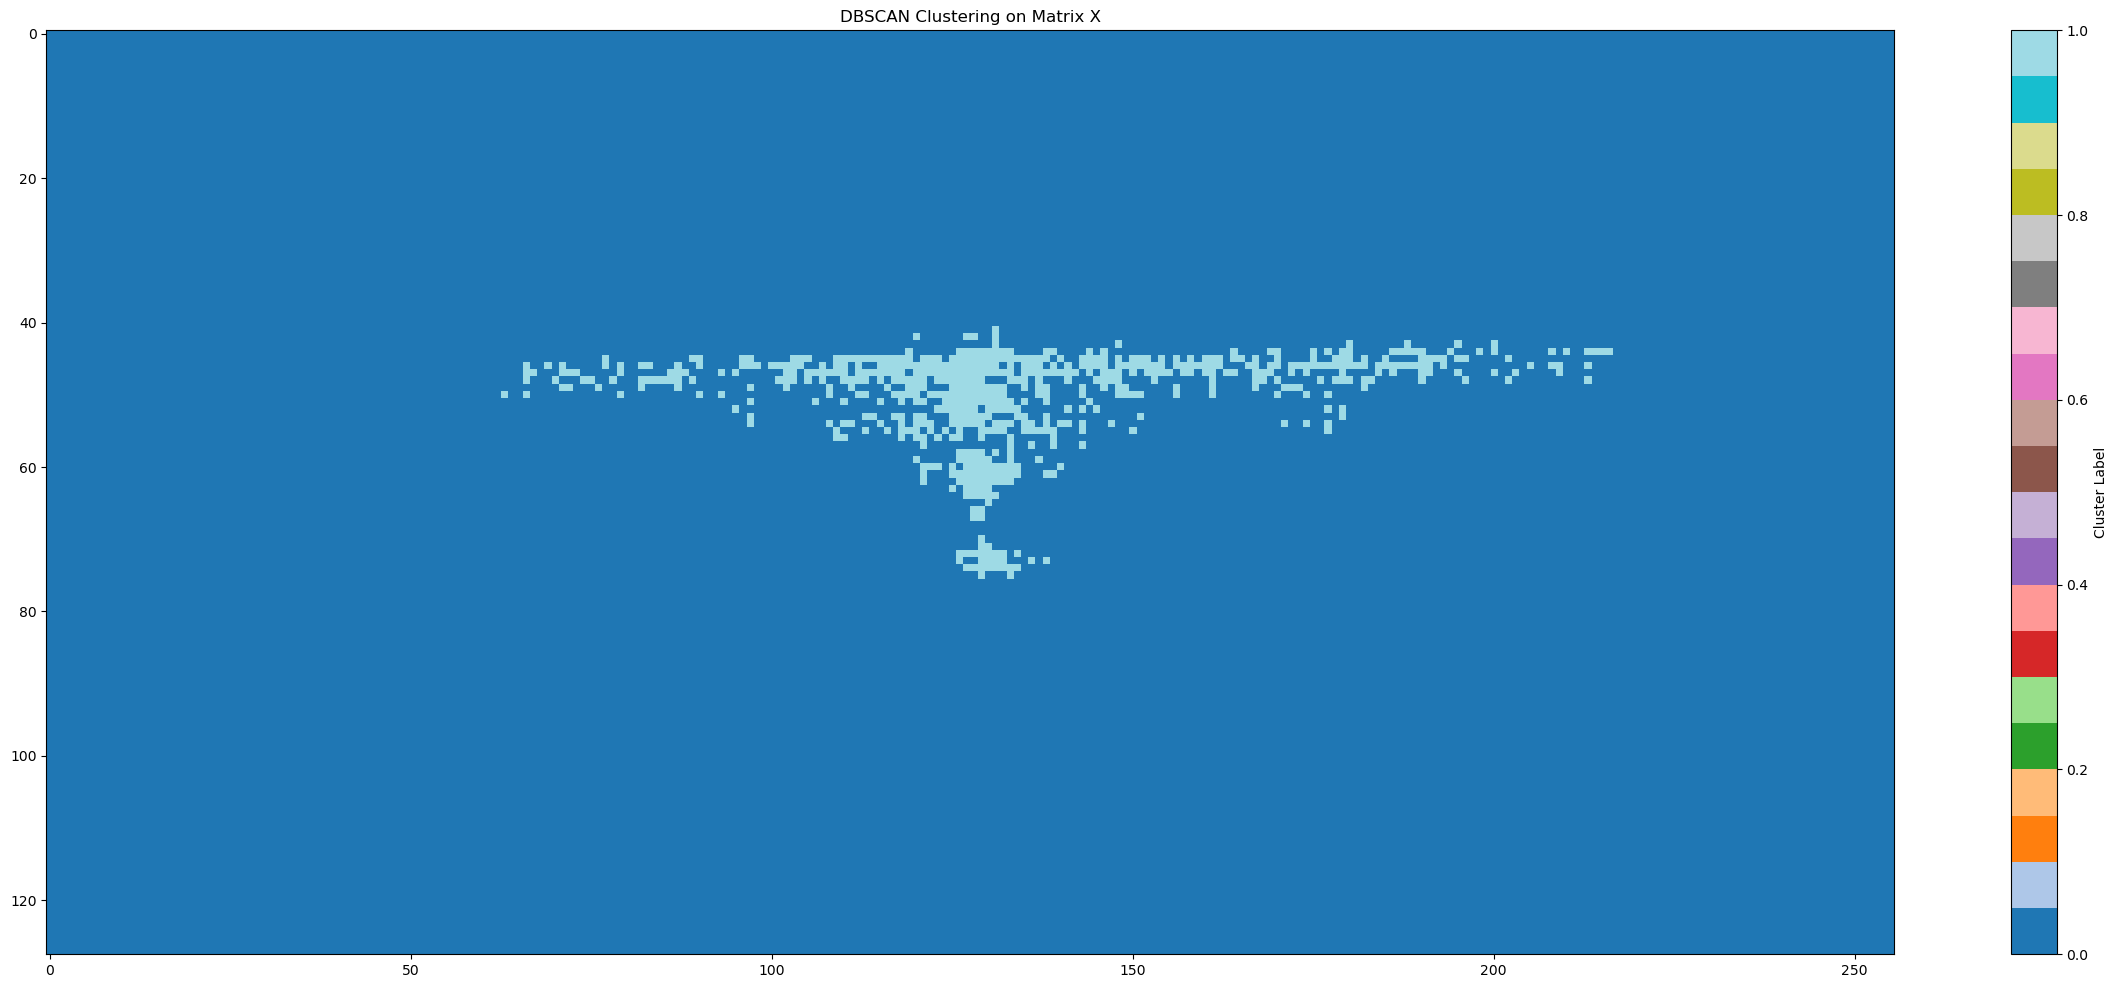

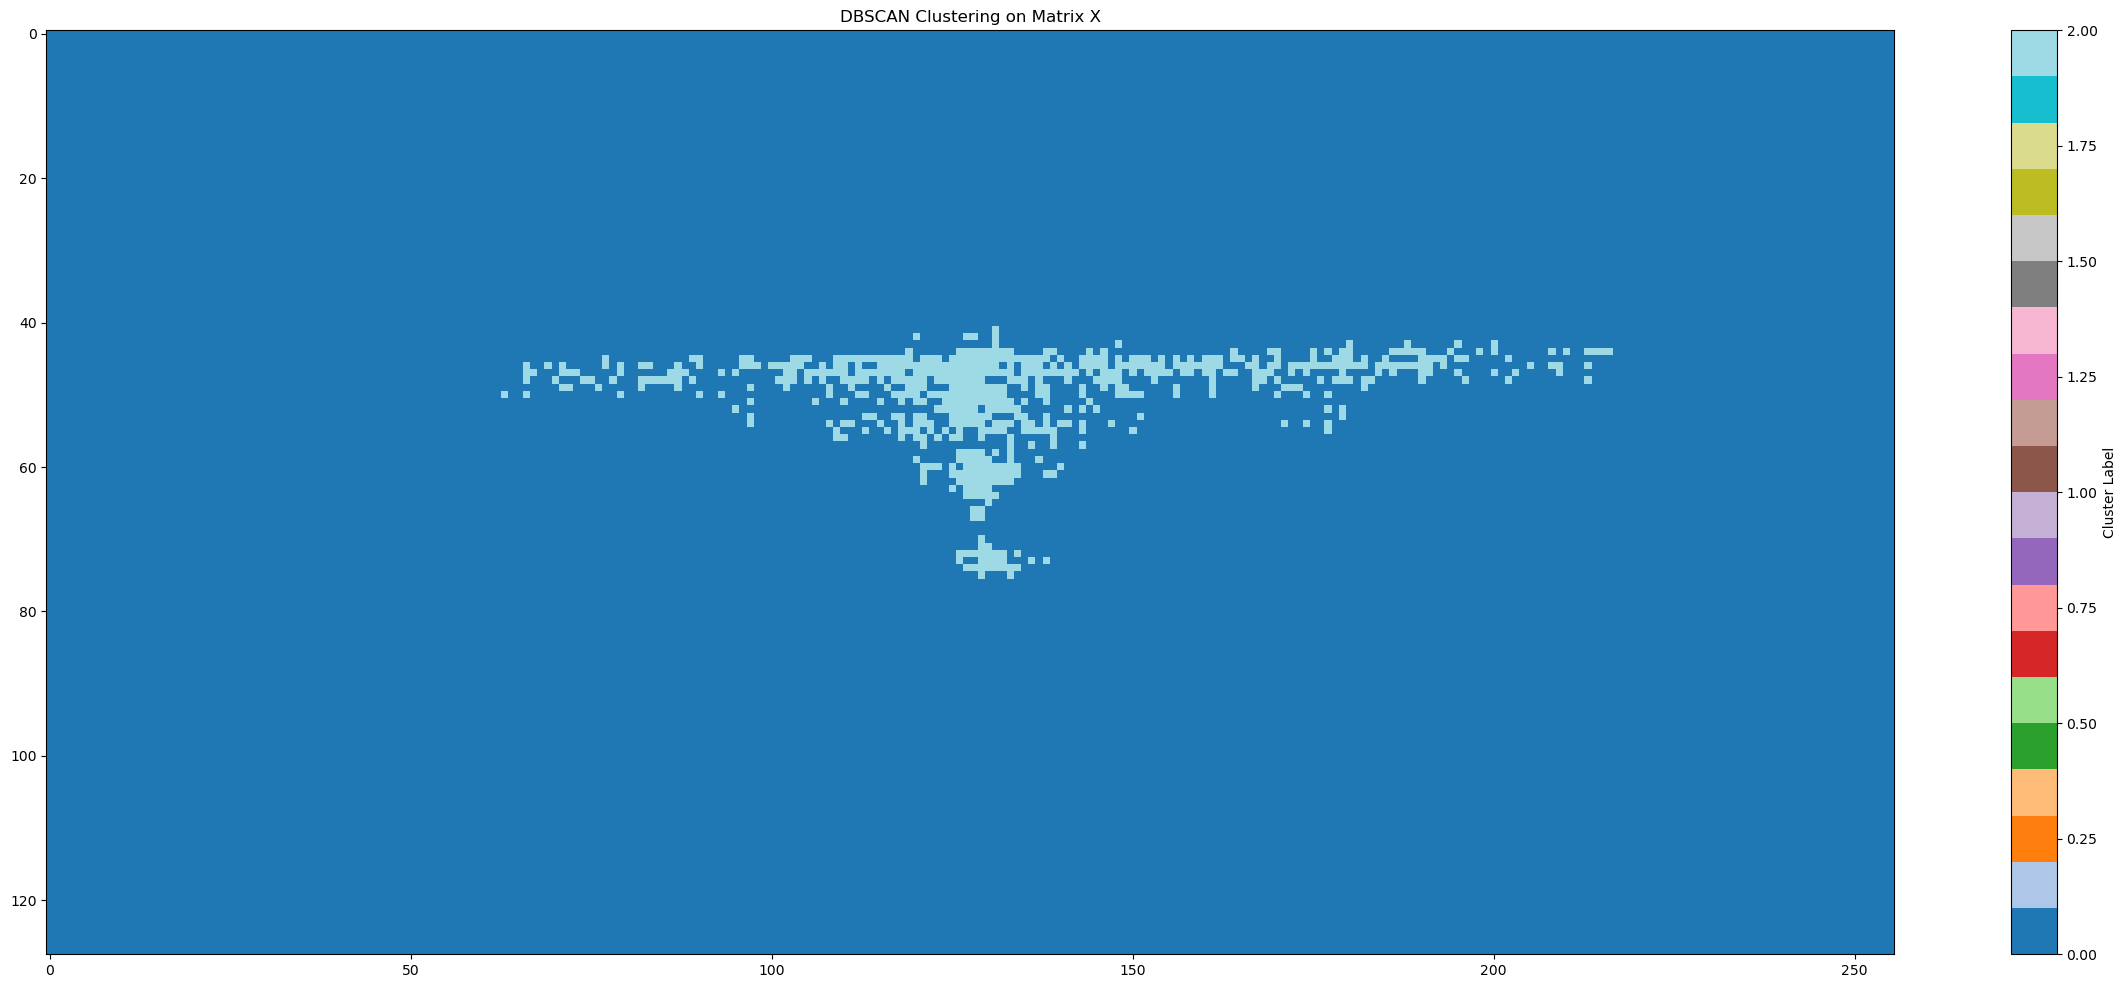

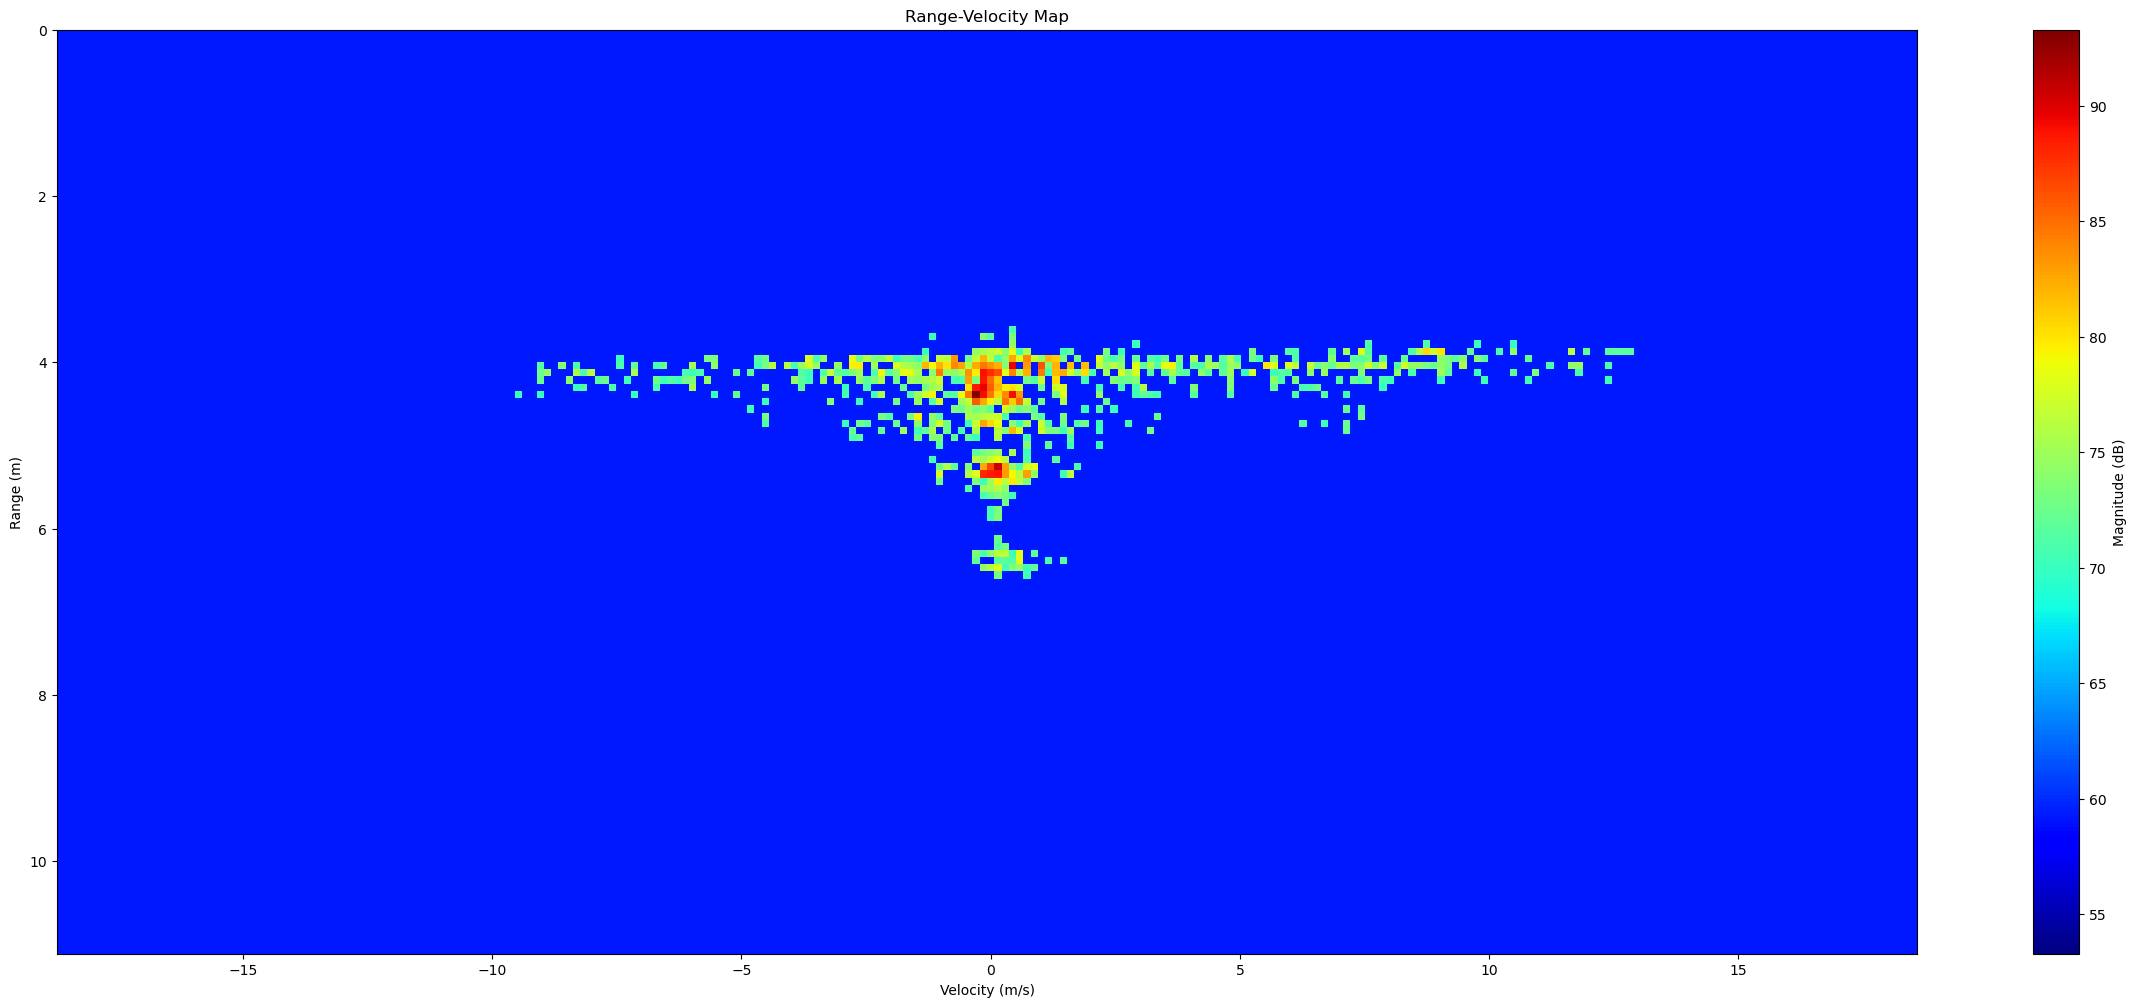

In [56]:
plot_bf_cluster(3)
data_test = doppler_fft_without_butter(data[3].T)
doppler_magnitude = np.abs(data_test)
velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
# Shift zero-frequency component to center of spectrum
doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
velocity_bins = np.fft.fftshift(velocity_bins)

output_test = 20 * np.log10(doppler_magnitude)

output_test = update_column(output_test,128)
out = np.copy(output_test)

output_test[output_test > 70] = 100
output_test[output_test <= 70] = 0
indices = np.column_stack(np.where(output_test == 100))
db = DBSCAN(eps=3, min_samples=3)
labels = db.fit_predict(indices)

label_counts = Counter(labels)

# Bước 2: Tìm cụm có số phần tử nhiều nhất
most_frequent_label = label_counts.most_common(1)[0][0]

# Bước 3: Gán nhãn mới
new_labels = [1 if label == most_frequent_label else 0 for label in labels]

# Gán nhãn cho ma trận Y (cùng kích thước với ma trận X)
Y = np.zeros_like(output_test)
for i, label in enumerate(new_labels):
    if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
        Y[indices[i, 0], indices[i, 1]] = label  # Gán nhãn bắt đầu từ 1

# Vẽ hình ảnh trực quan của ma trận Y (các cụm được gán nhãn)
plt.figure(figsize=(30, 12))
plt.imshow(Y, cmap='tab20', interpolation='nearest')
plt.title('DBSCAN Clustering on Matrix X')
plt.colorbar(label='Cluster Label')
plt.show()

indices_2 = np.column_stack(np.where(Y == 1))
out[Y < 0.5] = 0
k = (out[out>0]).reshape(-1,1)

indices = np.copy(indices_2)
indices_2 = np.concatenate((indices_2, k), axis=1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(indices_2)

db2 = DBSCAN(eps=0.5, min_samples=4)
labels = db2.fit_predict(scaled_data)

Y = np.zeros_like(output_test)
for i, label in enumerate(labels):
    Y[indices[i, 0], indices[i, 1]] = label + 2 # Gán nhãn bắt đầu từ 1

 
# Vẽ hình ảnh trực quan của ma trận Y (các cụm được gán nhãn)
plt.figure(figsize=(30, 12))
plt.imshow(Y, cmap='tab20', interpolation='nearest')
plt.title('DBSCAN Clustering on Matrix X')
plt.colorbar(label='Cluster Label')
plt.show()

plot_final(3)


In [50]:
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
export_matrix_to_excel(Y,'Y-af.xlsx')

In [40]:
export_matrix_to_excel(indices,'indices.xlsx')

In [32]:
export_matrix_to_excel(scaled_data,'scaled.xlsx')

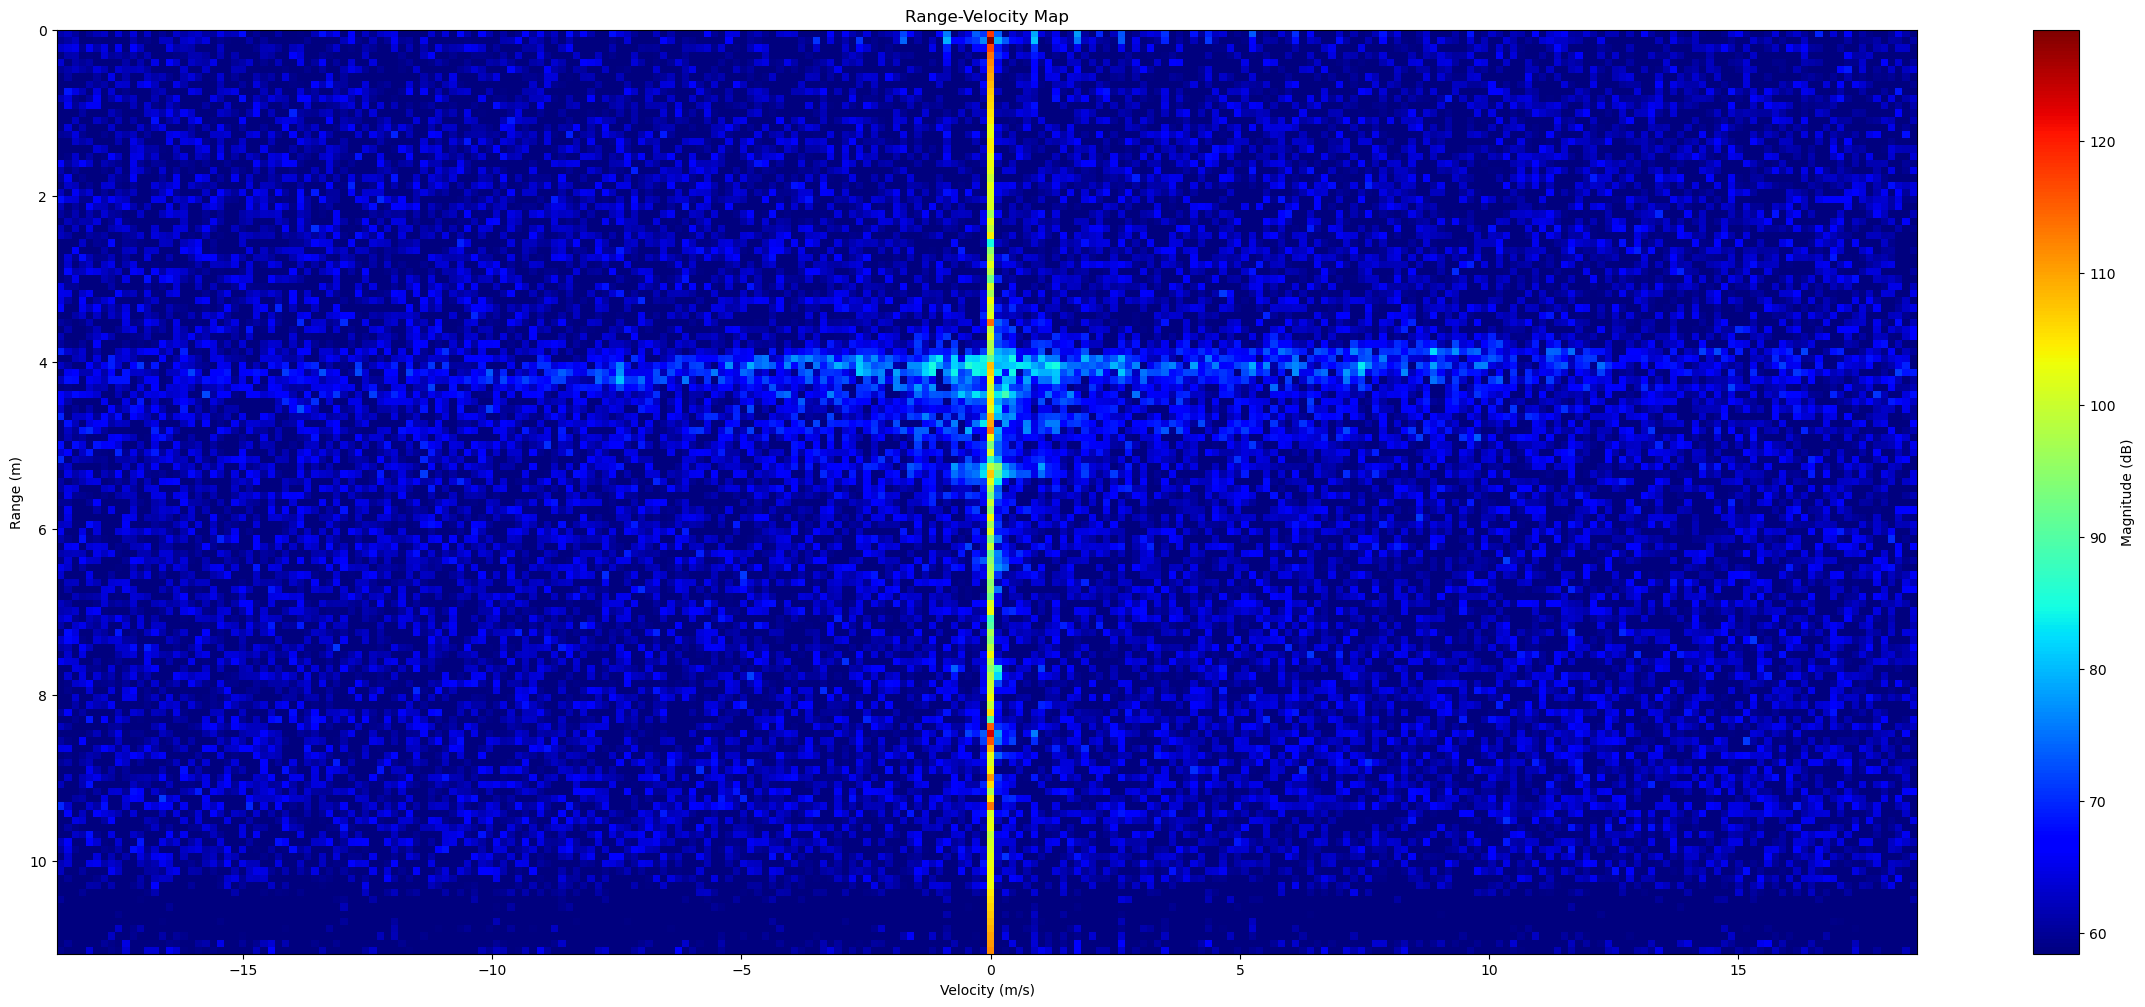

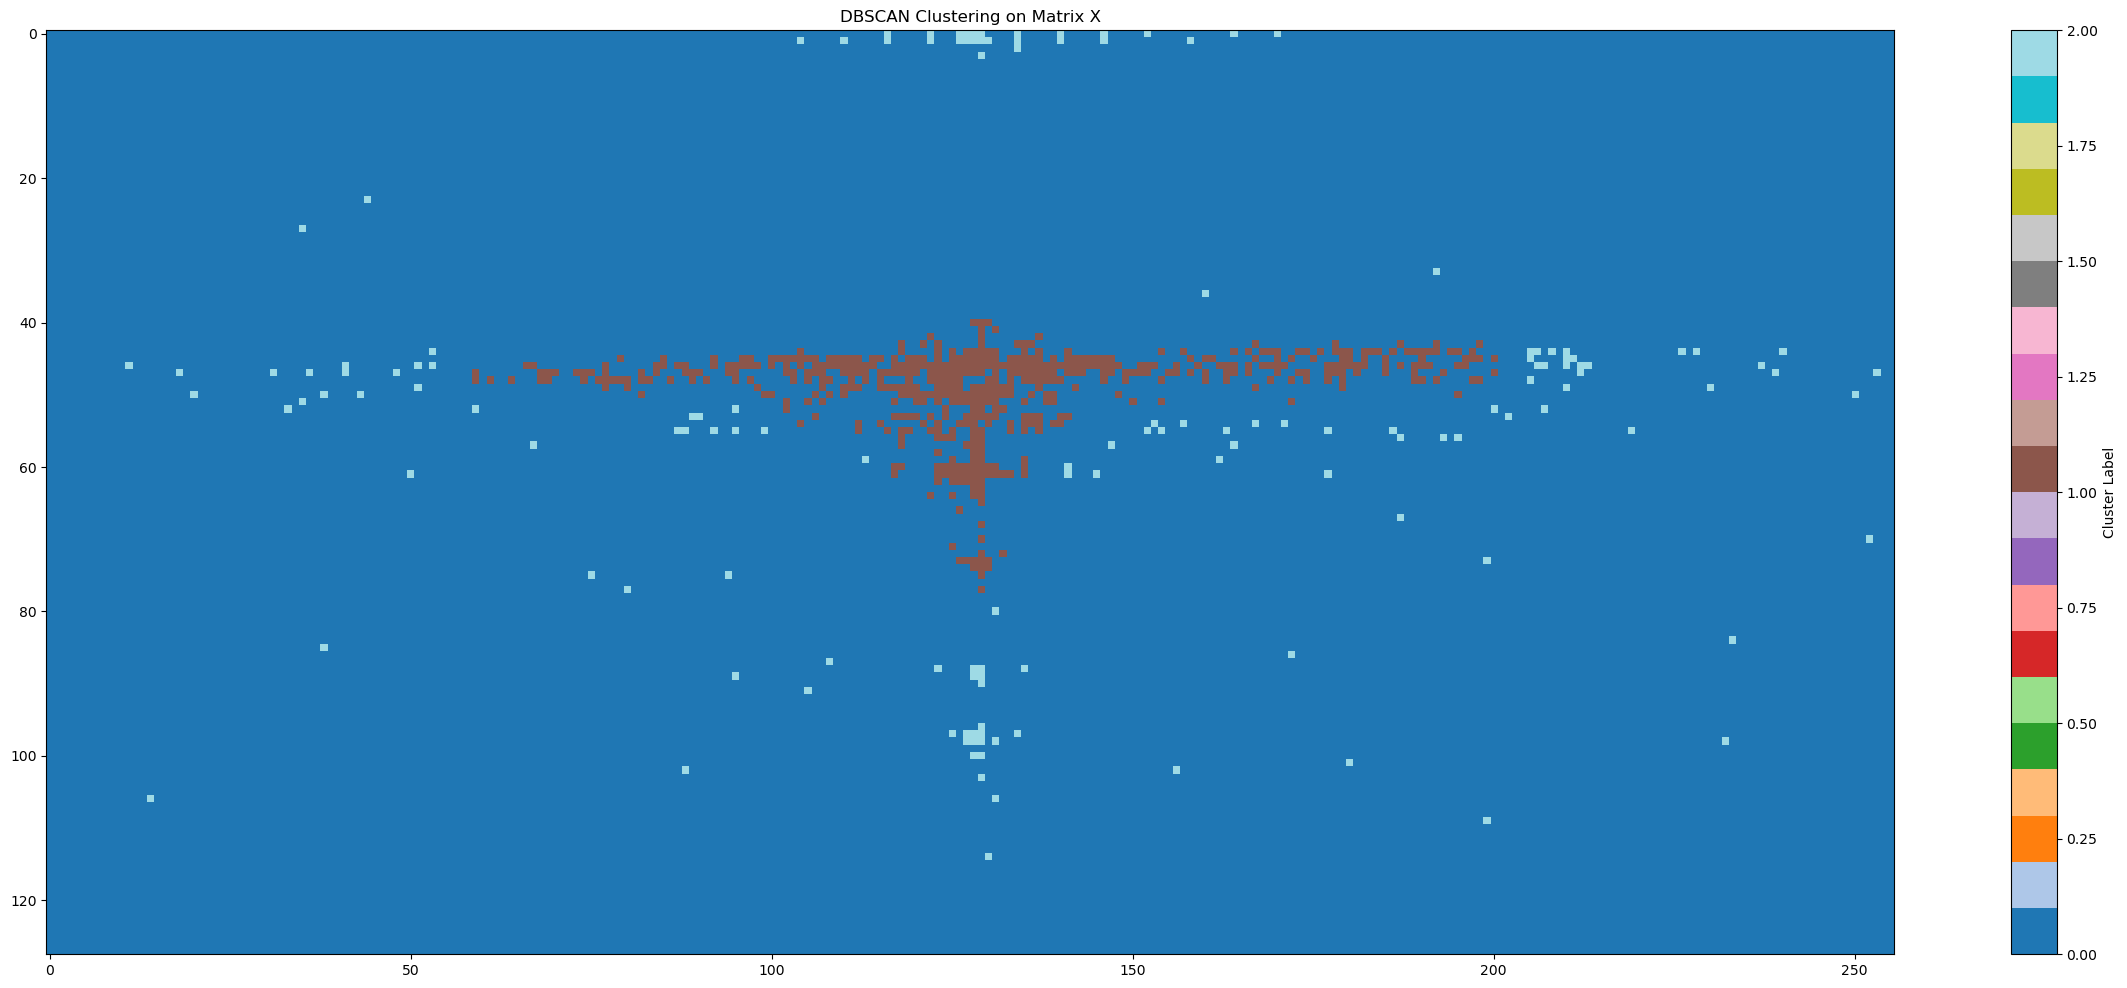

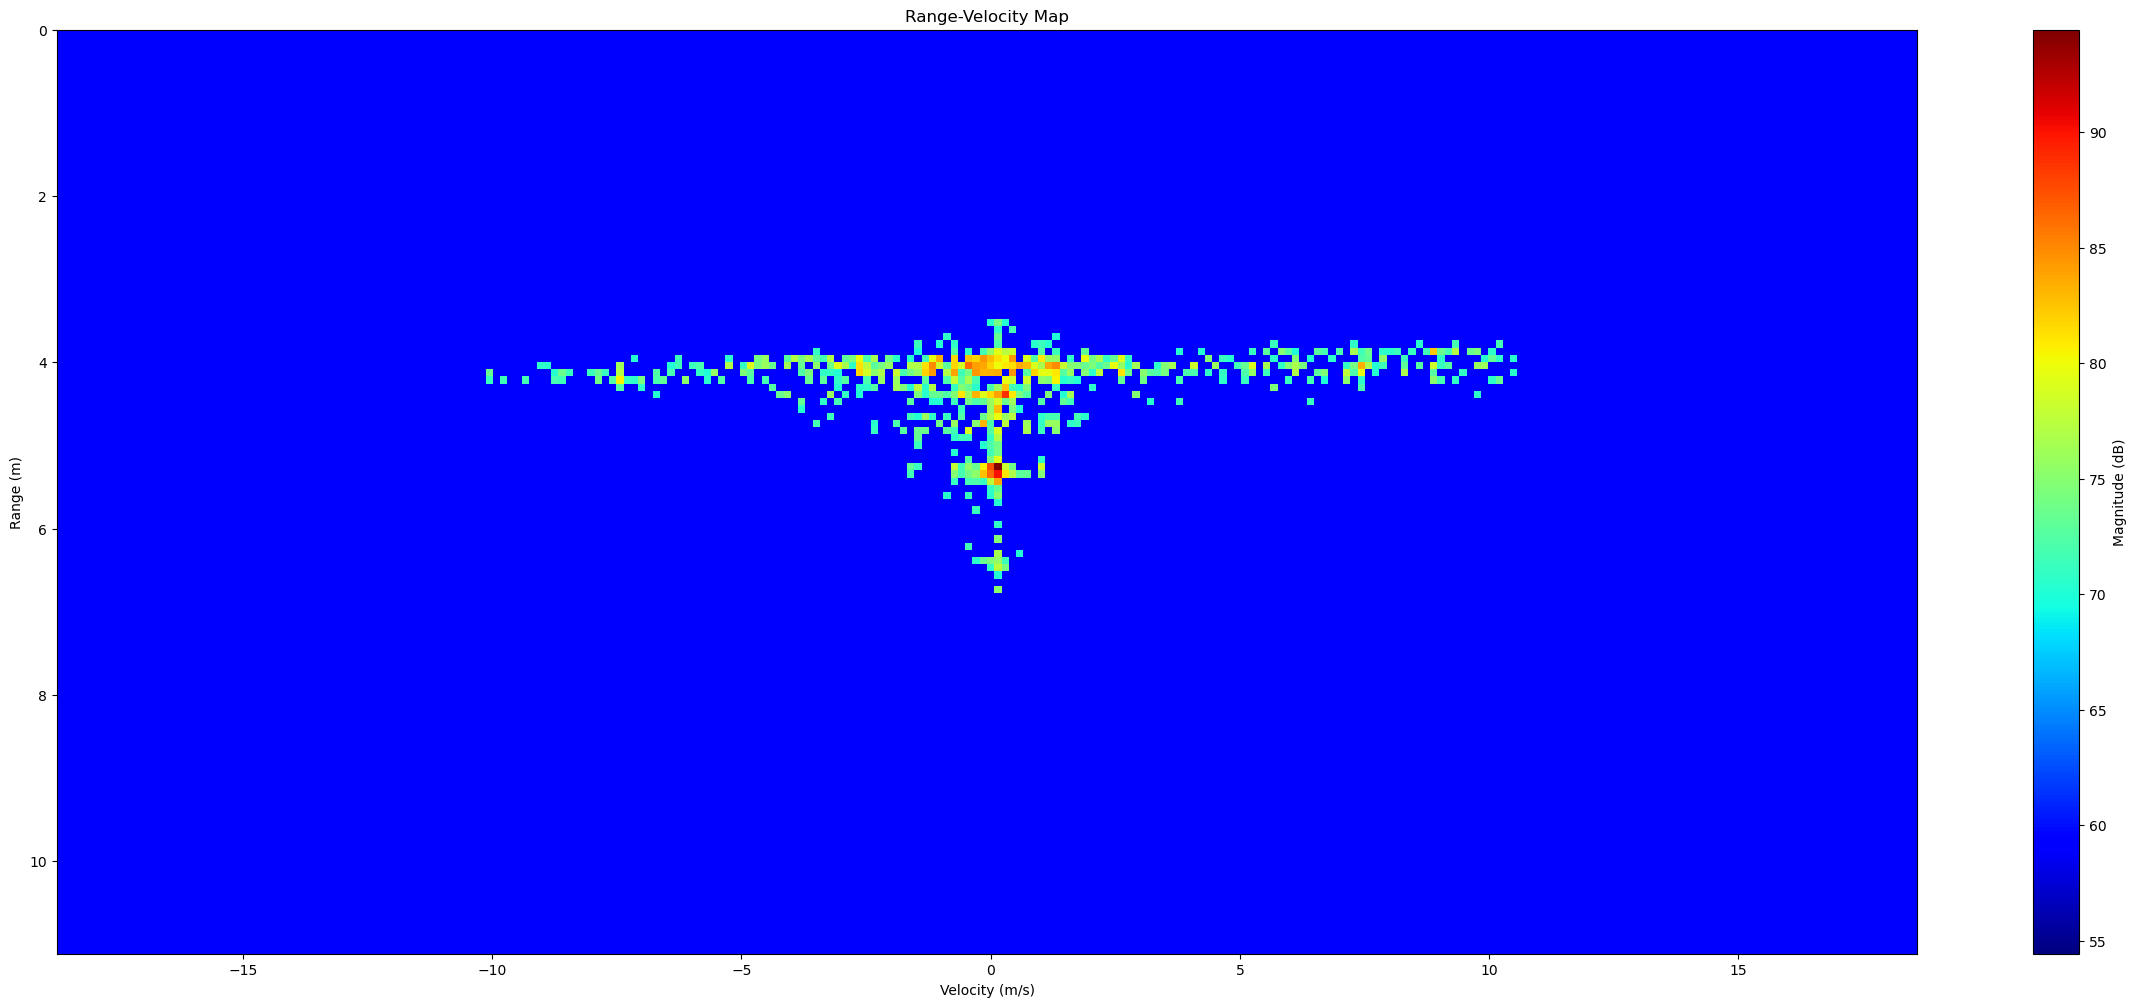

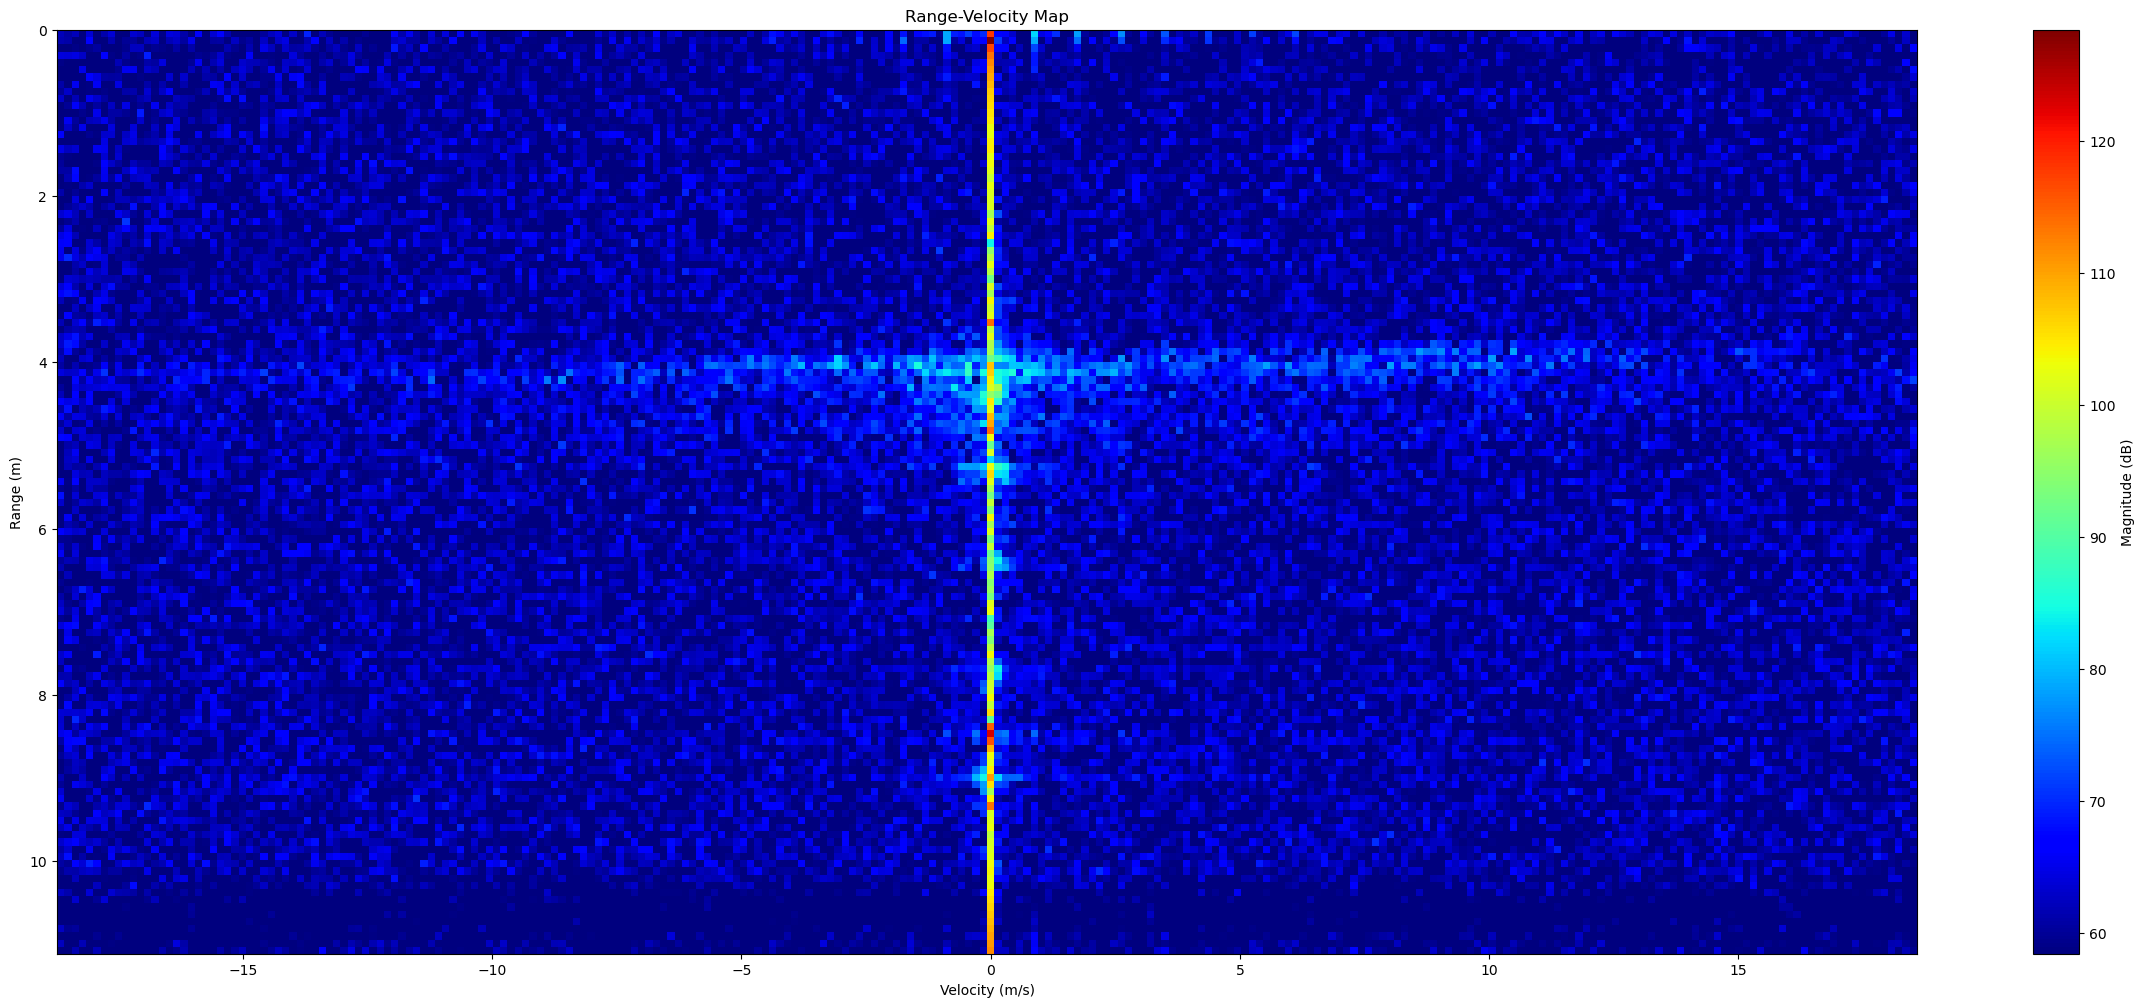

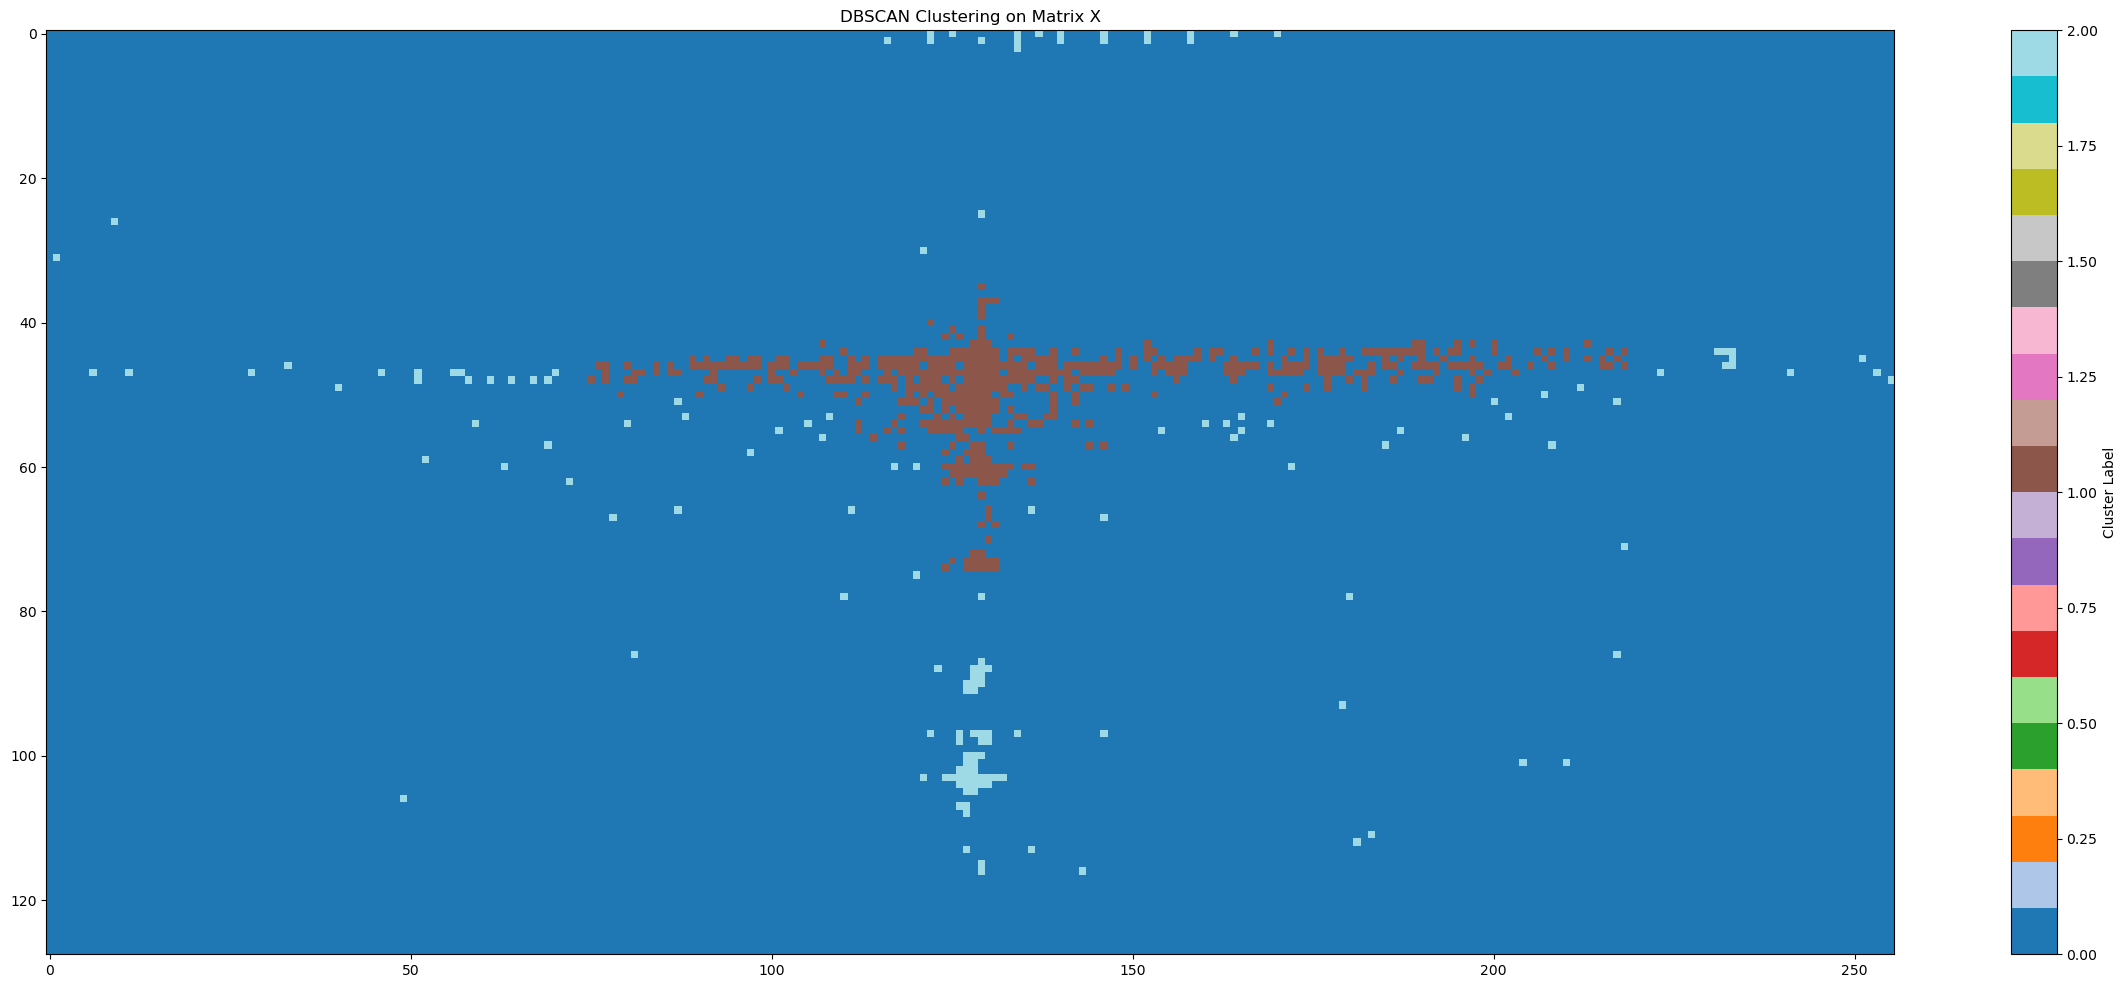

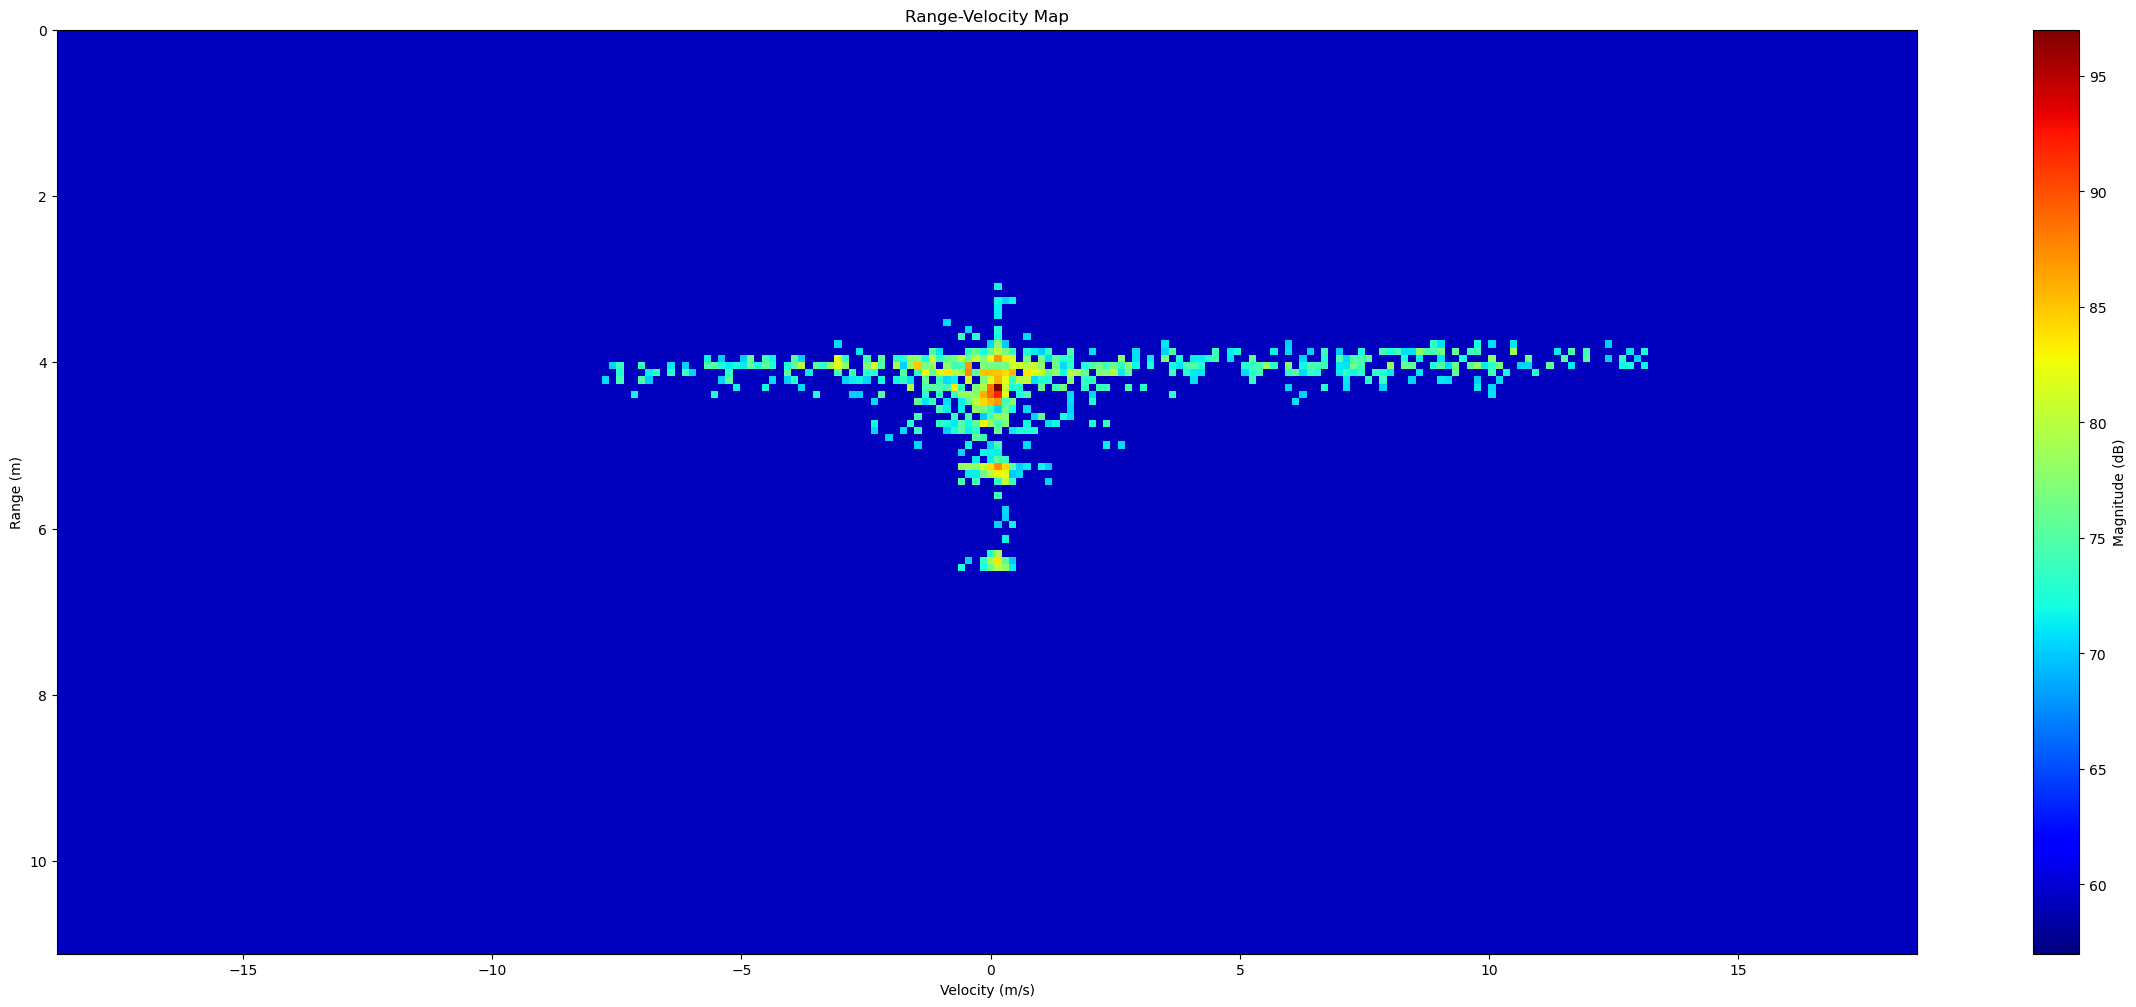

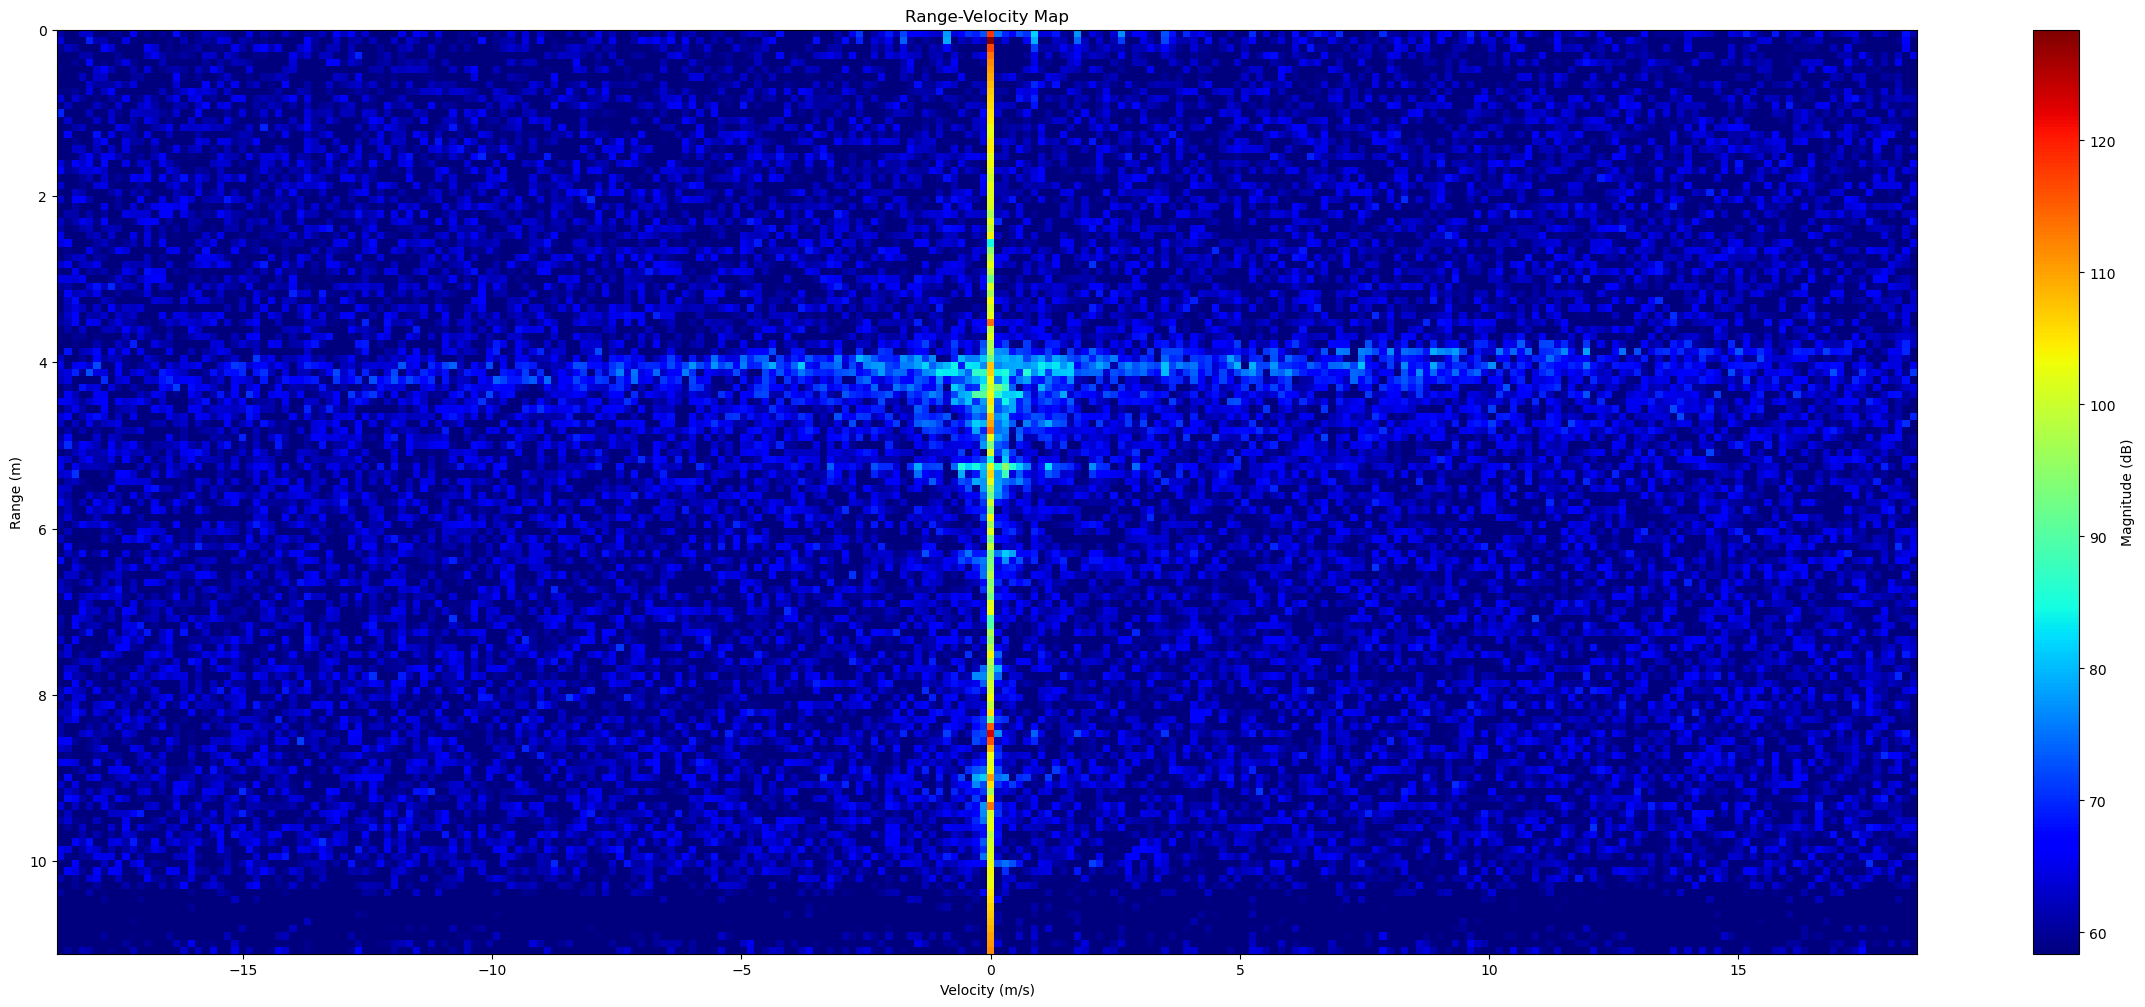

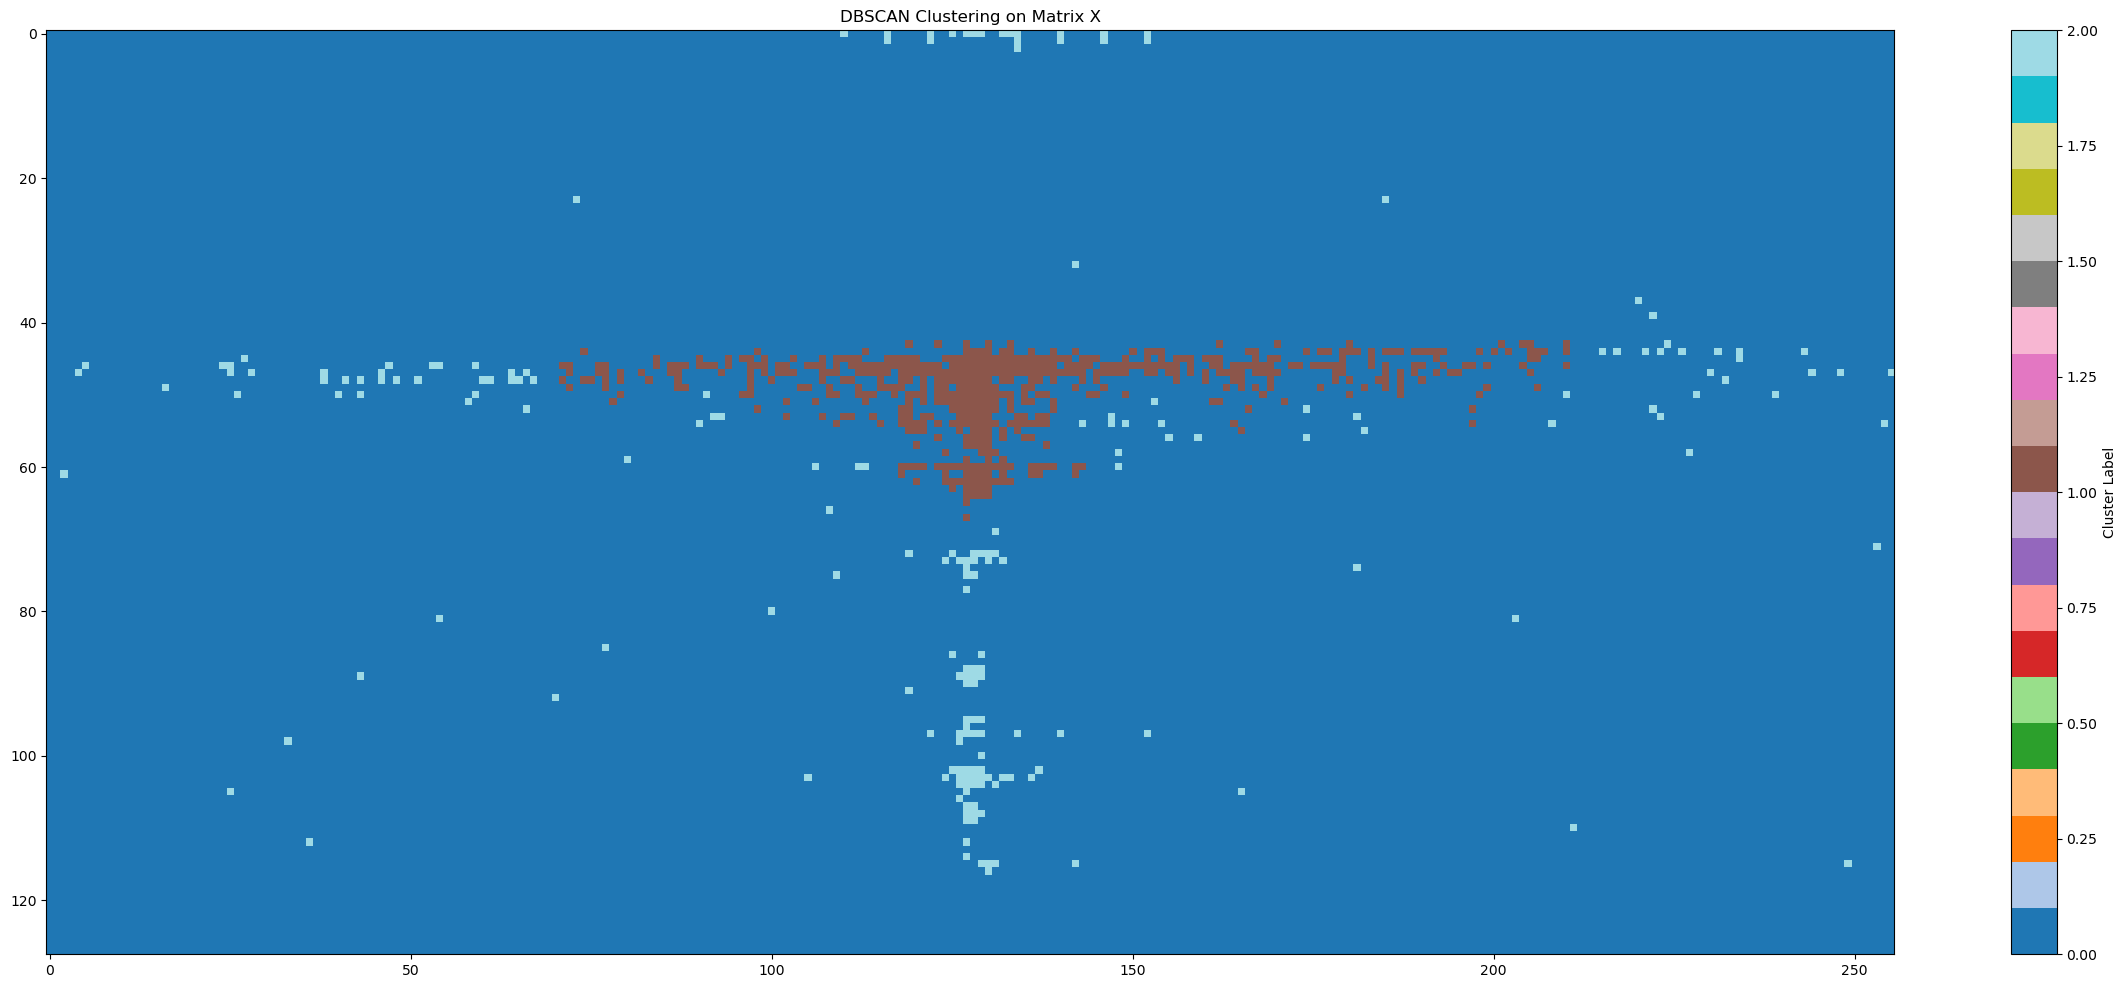

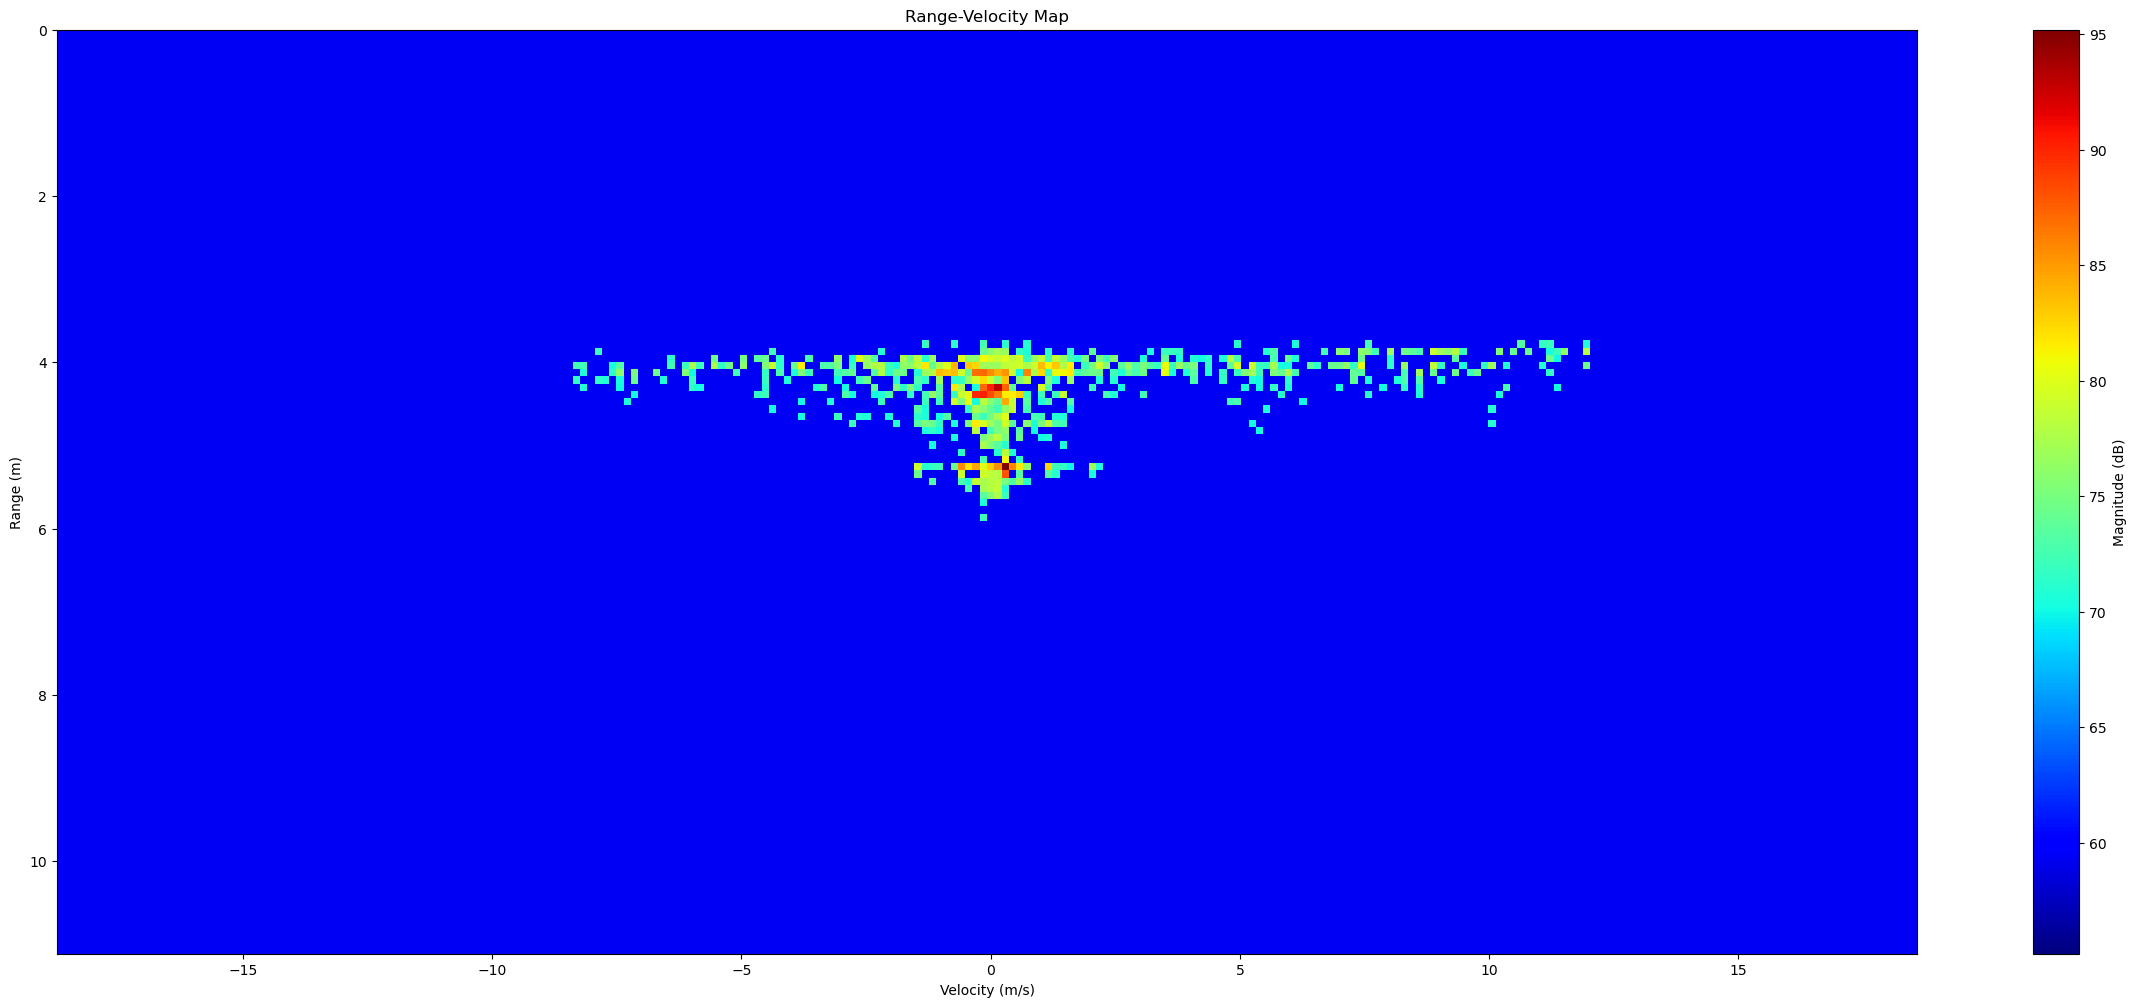

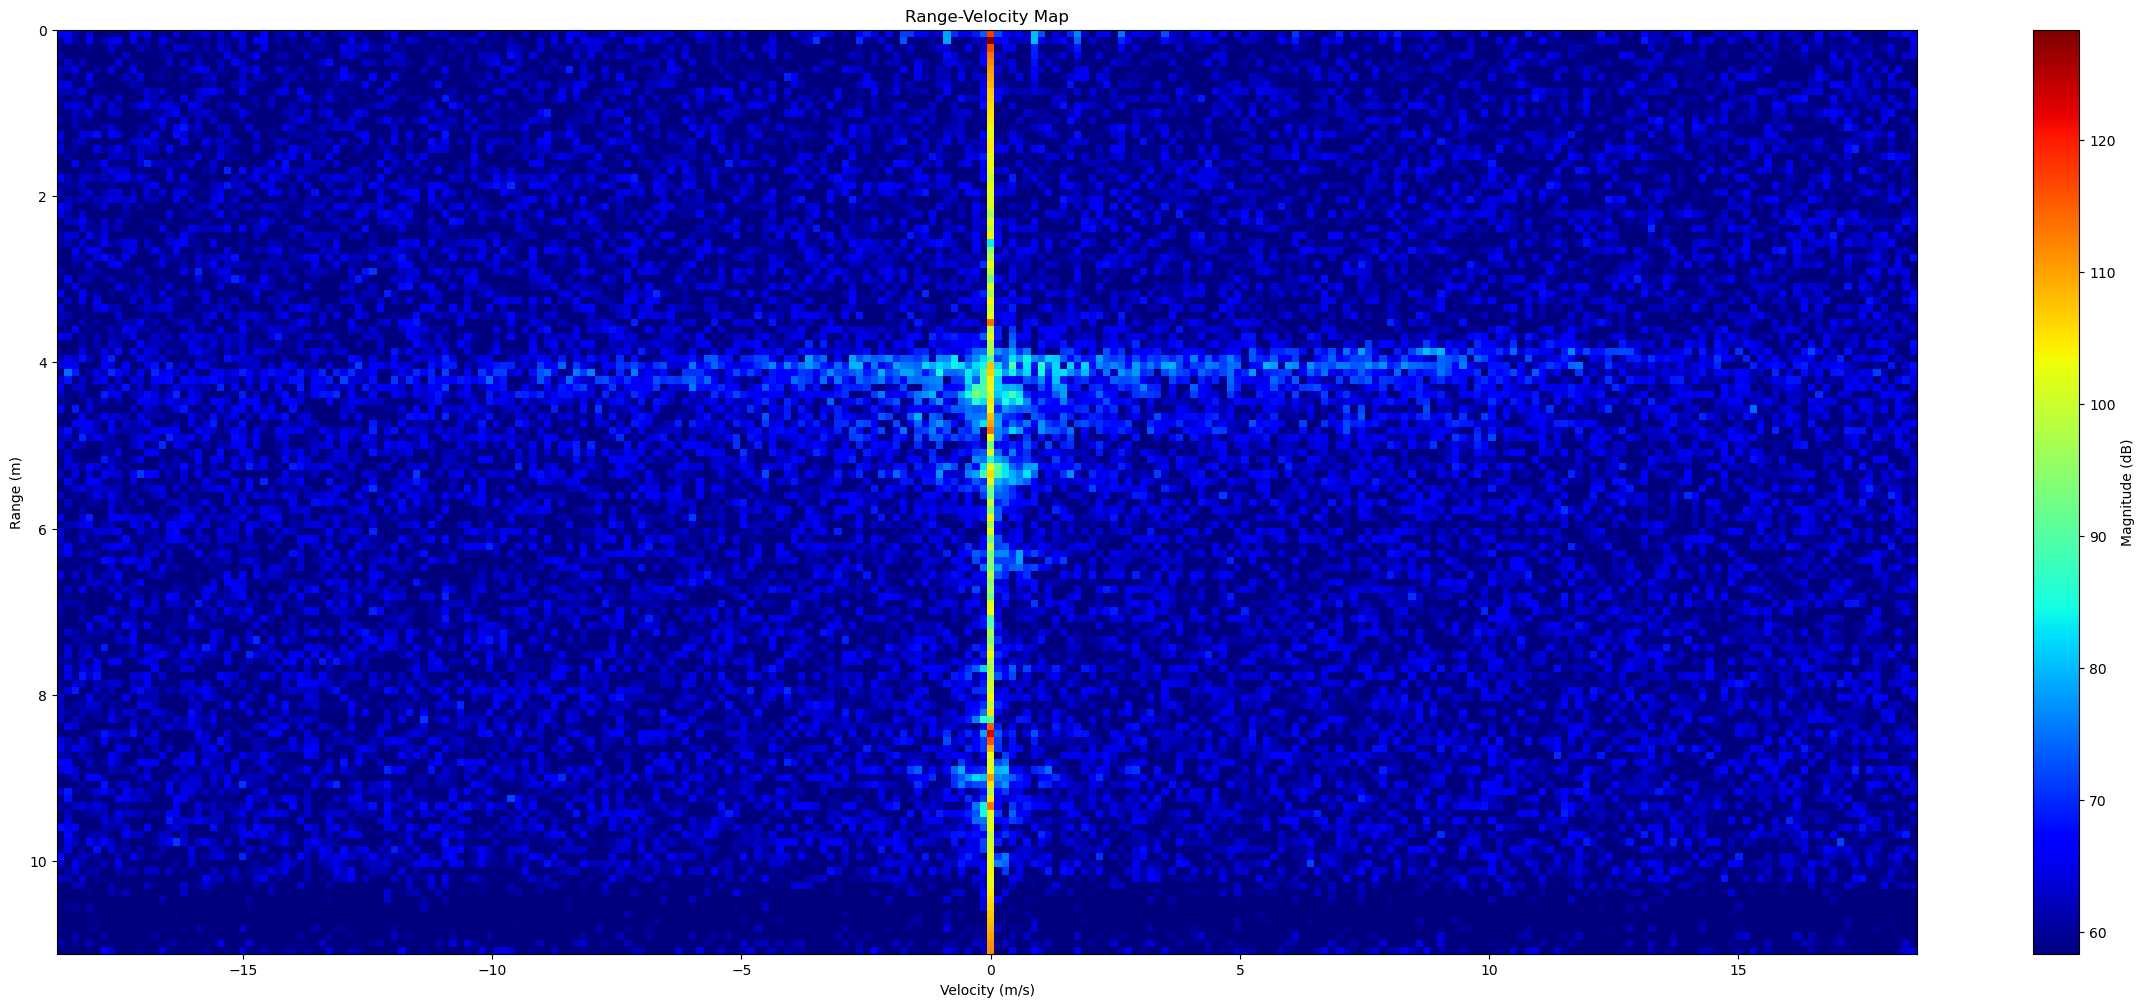

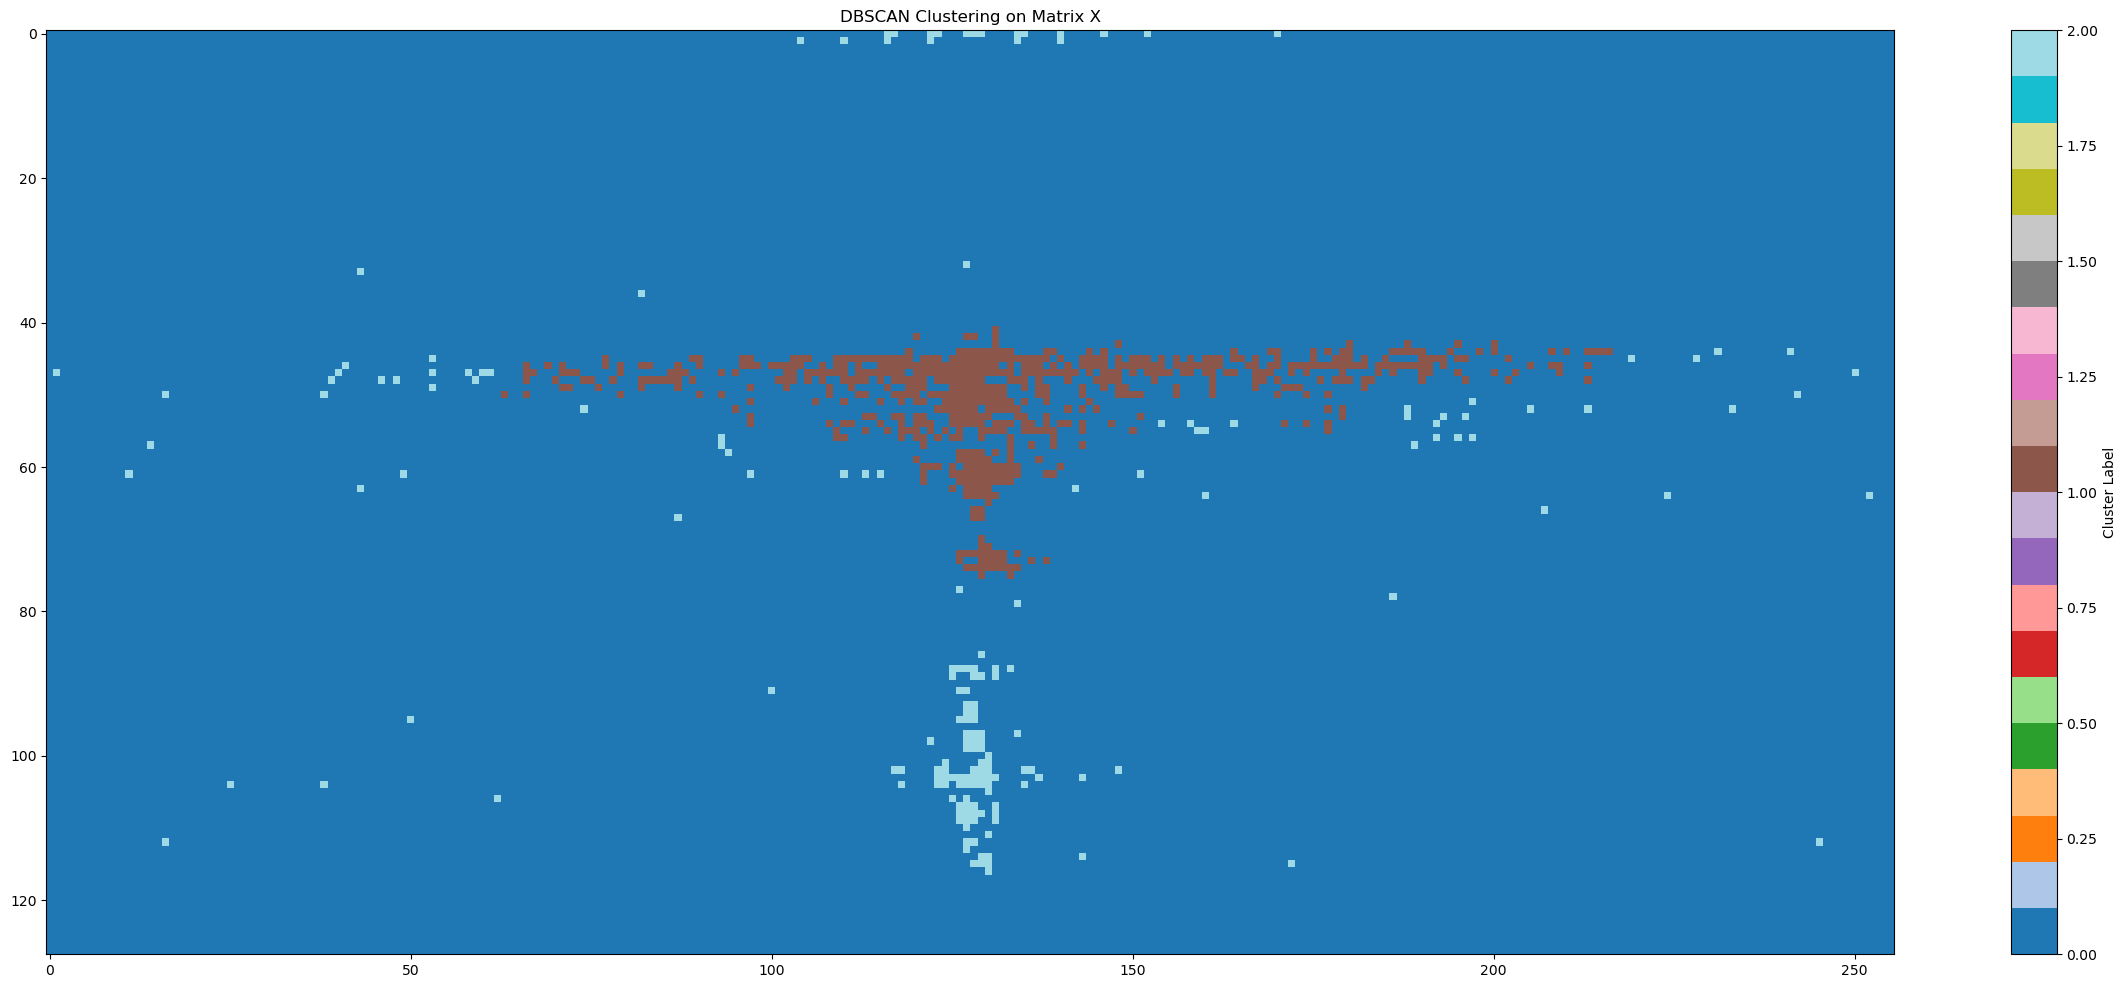

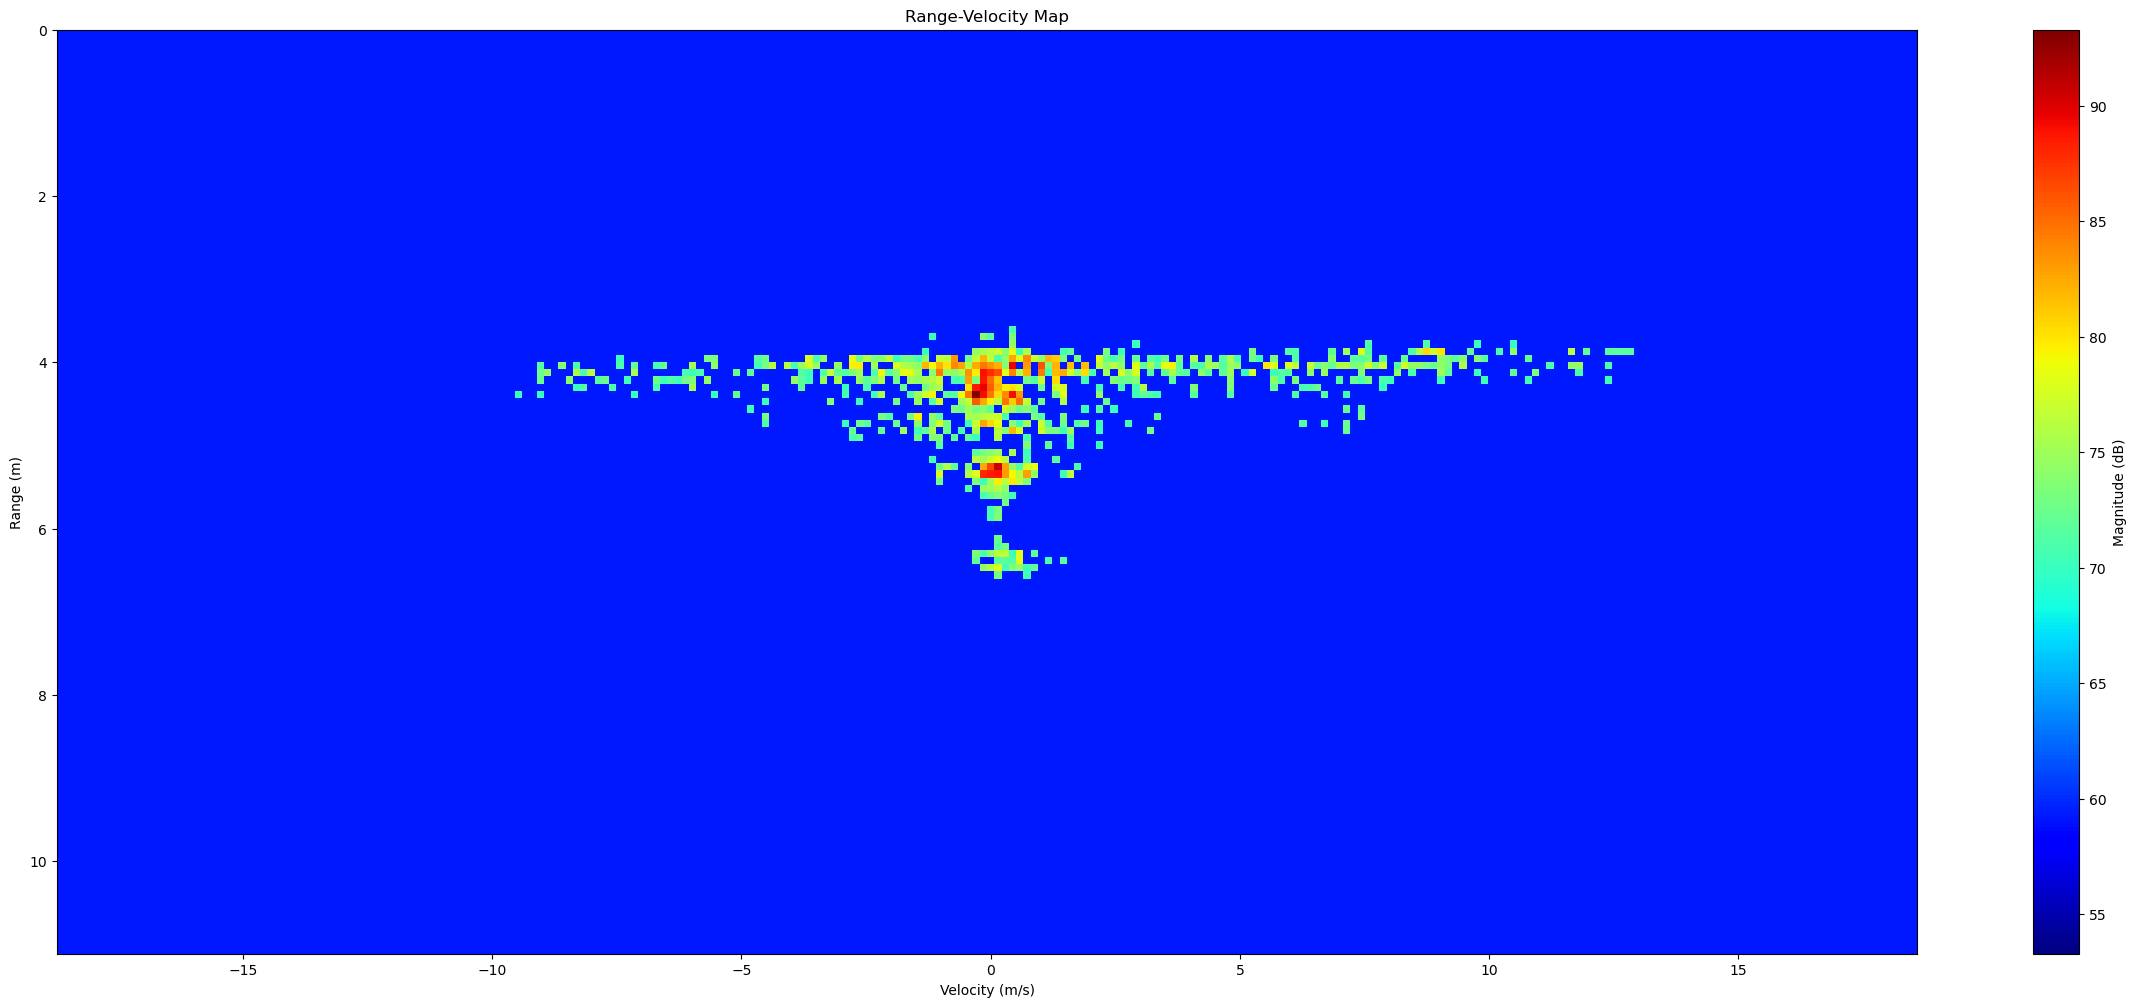

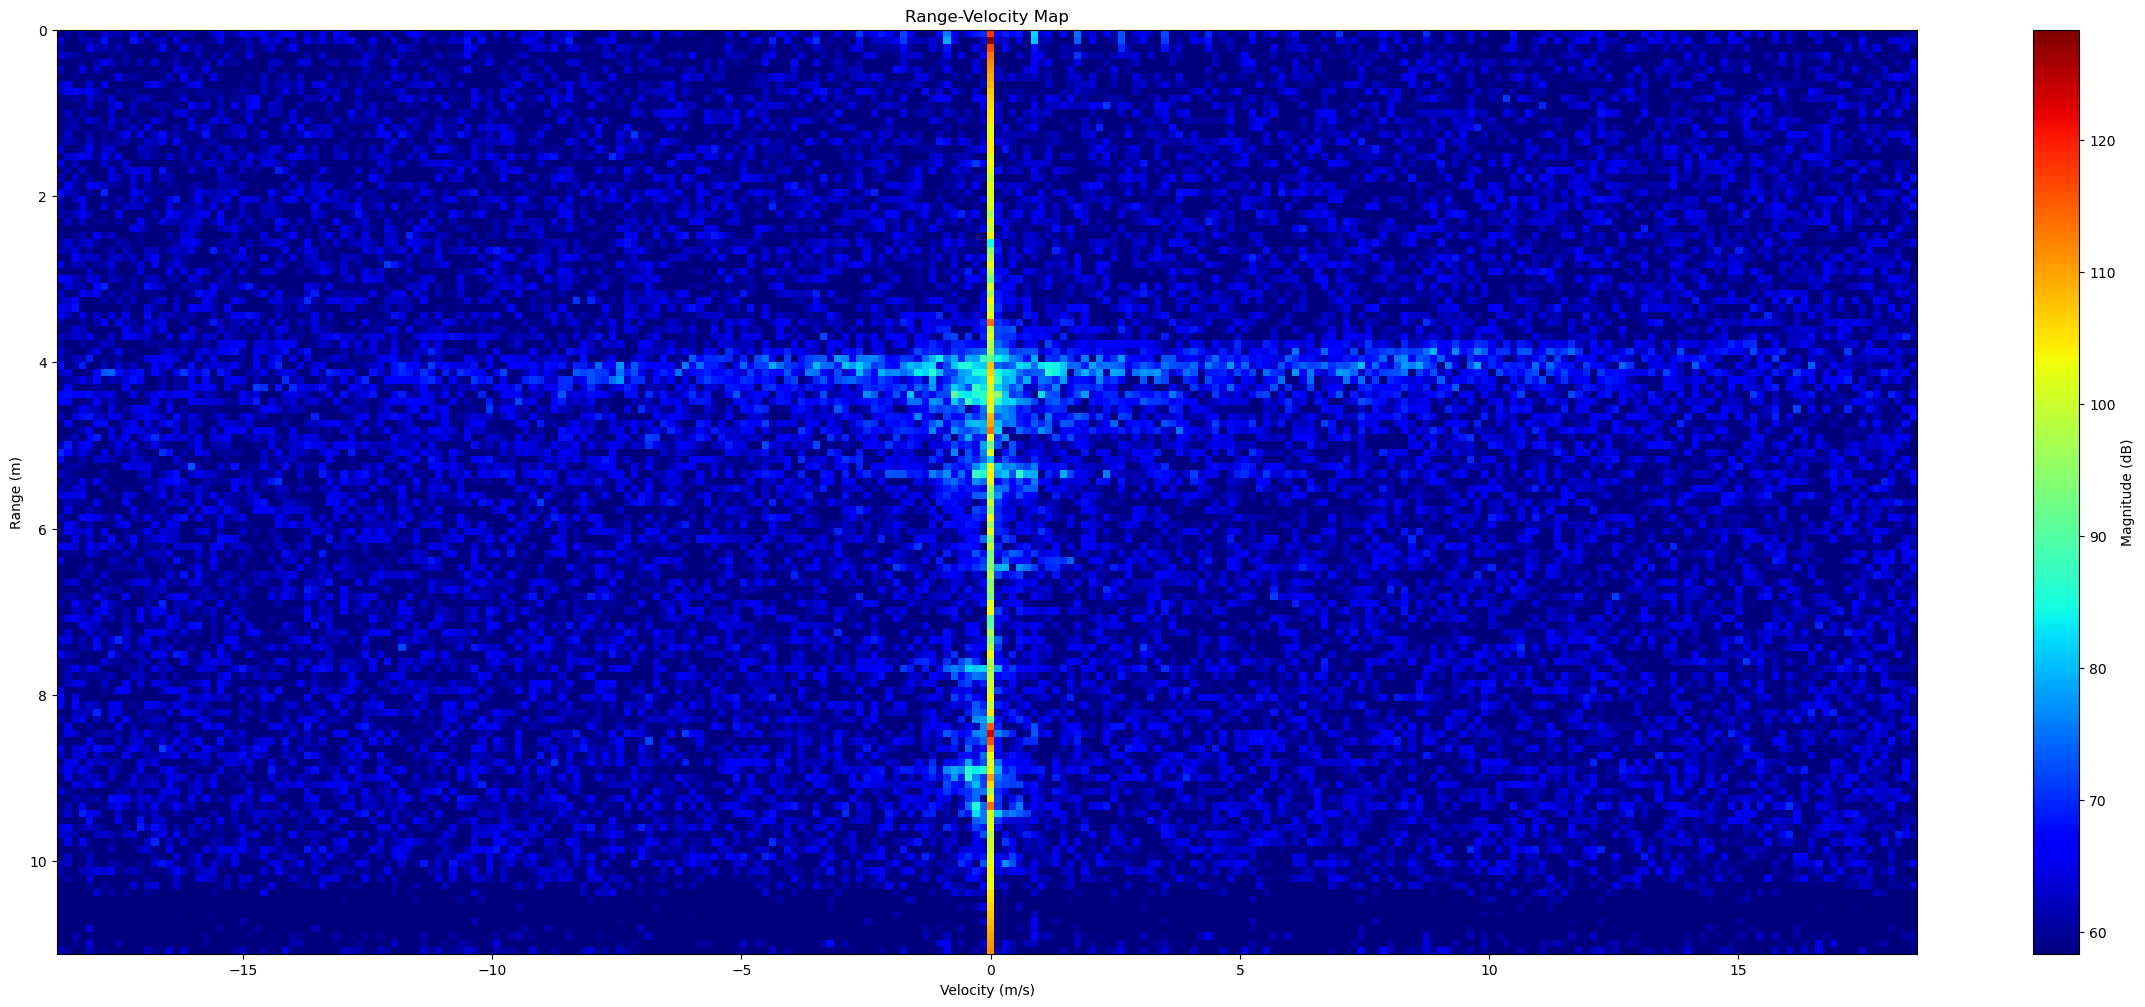

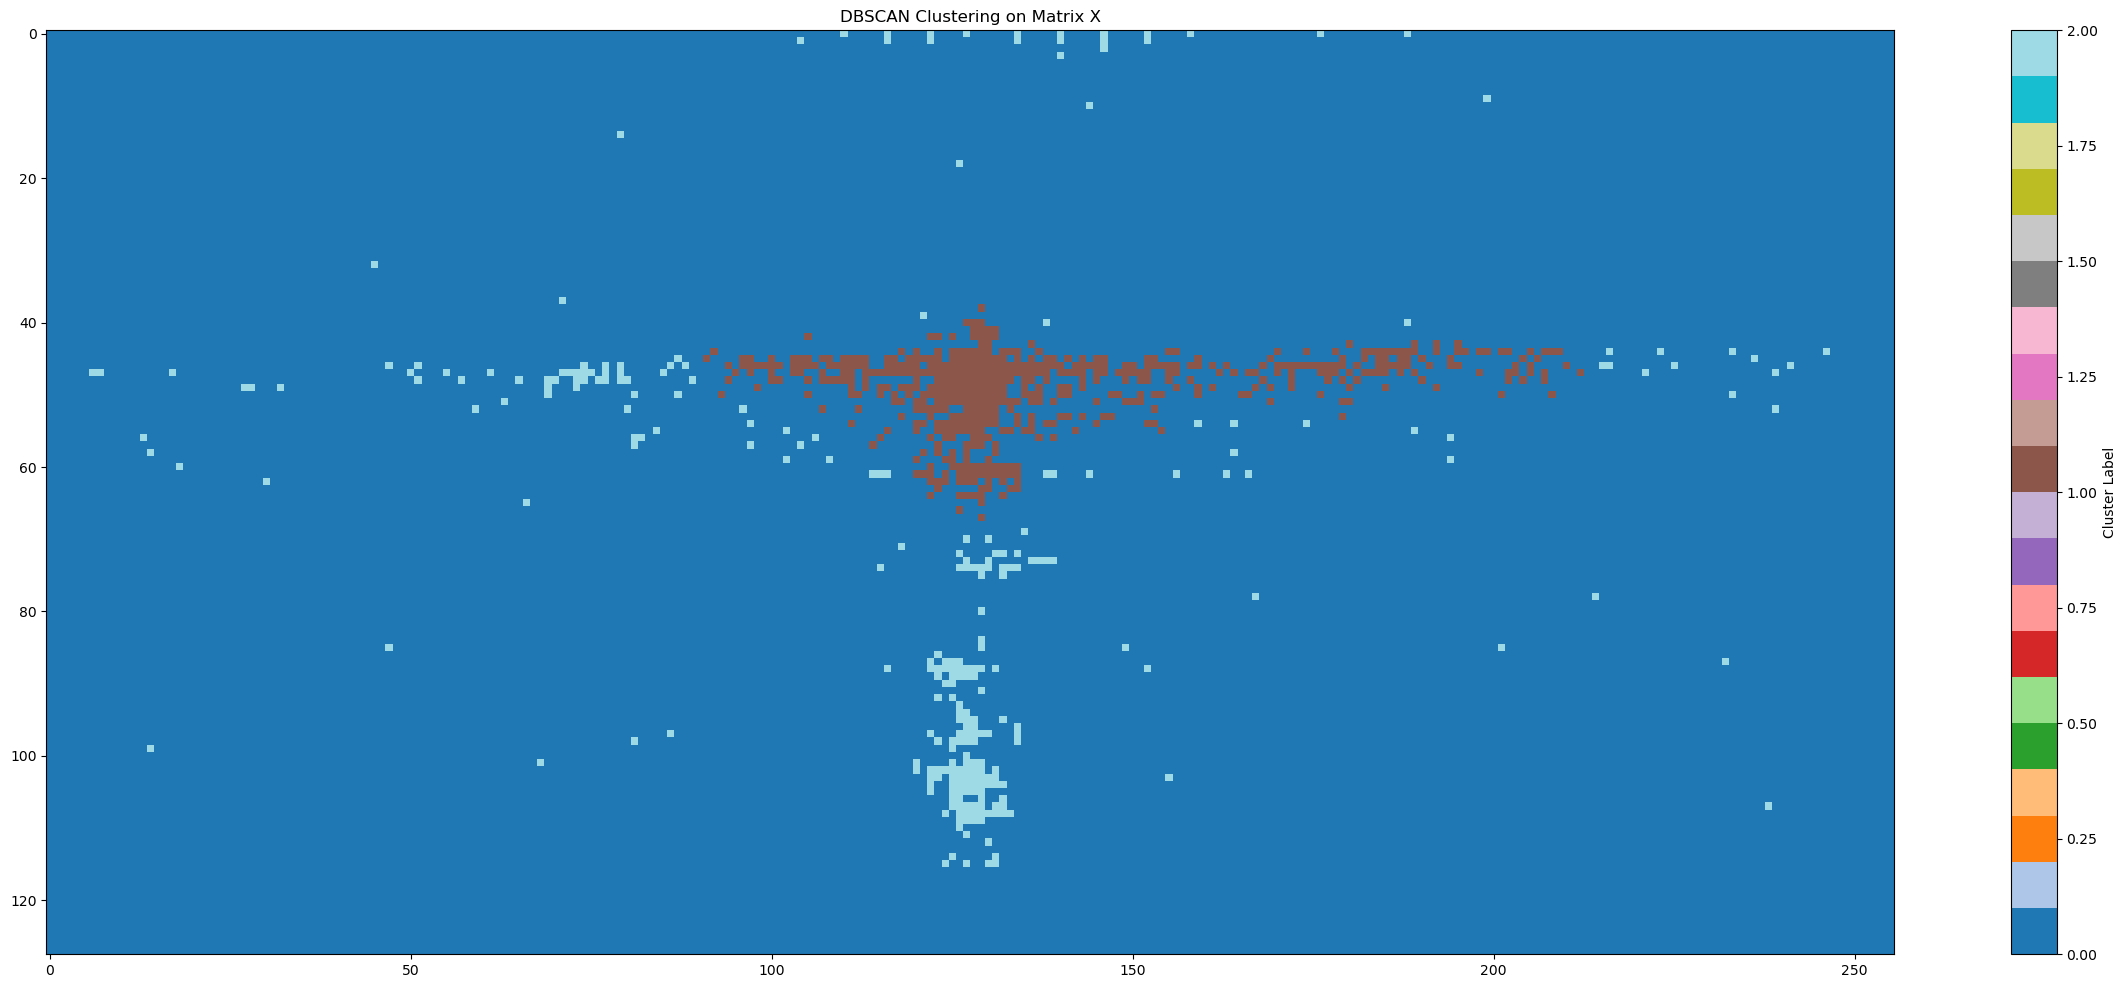

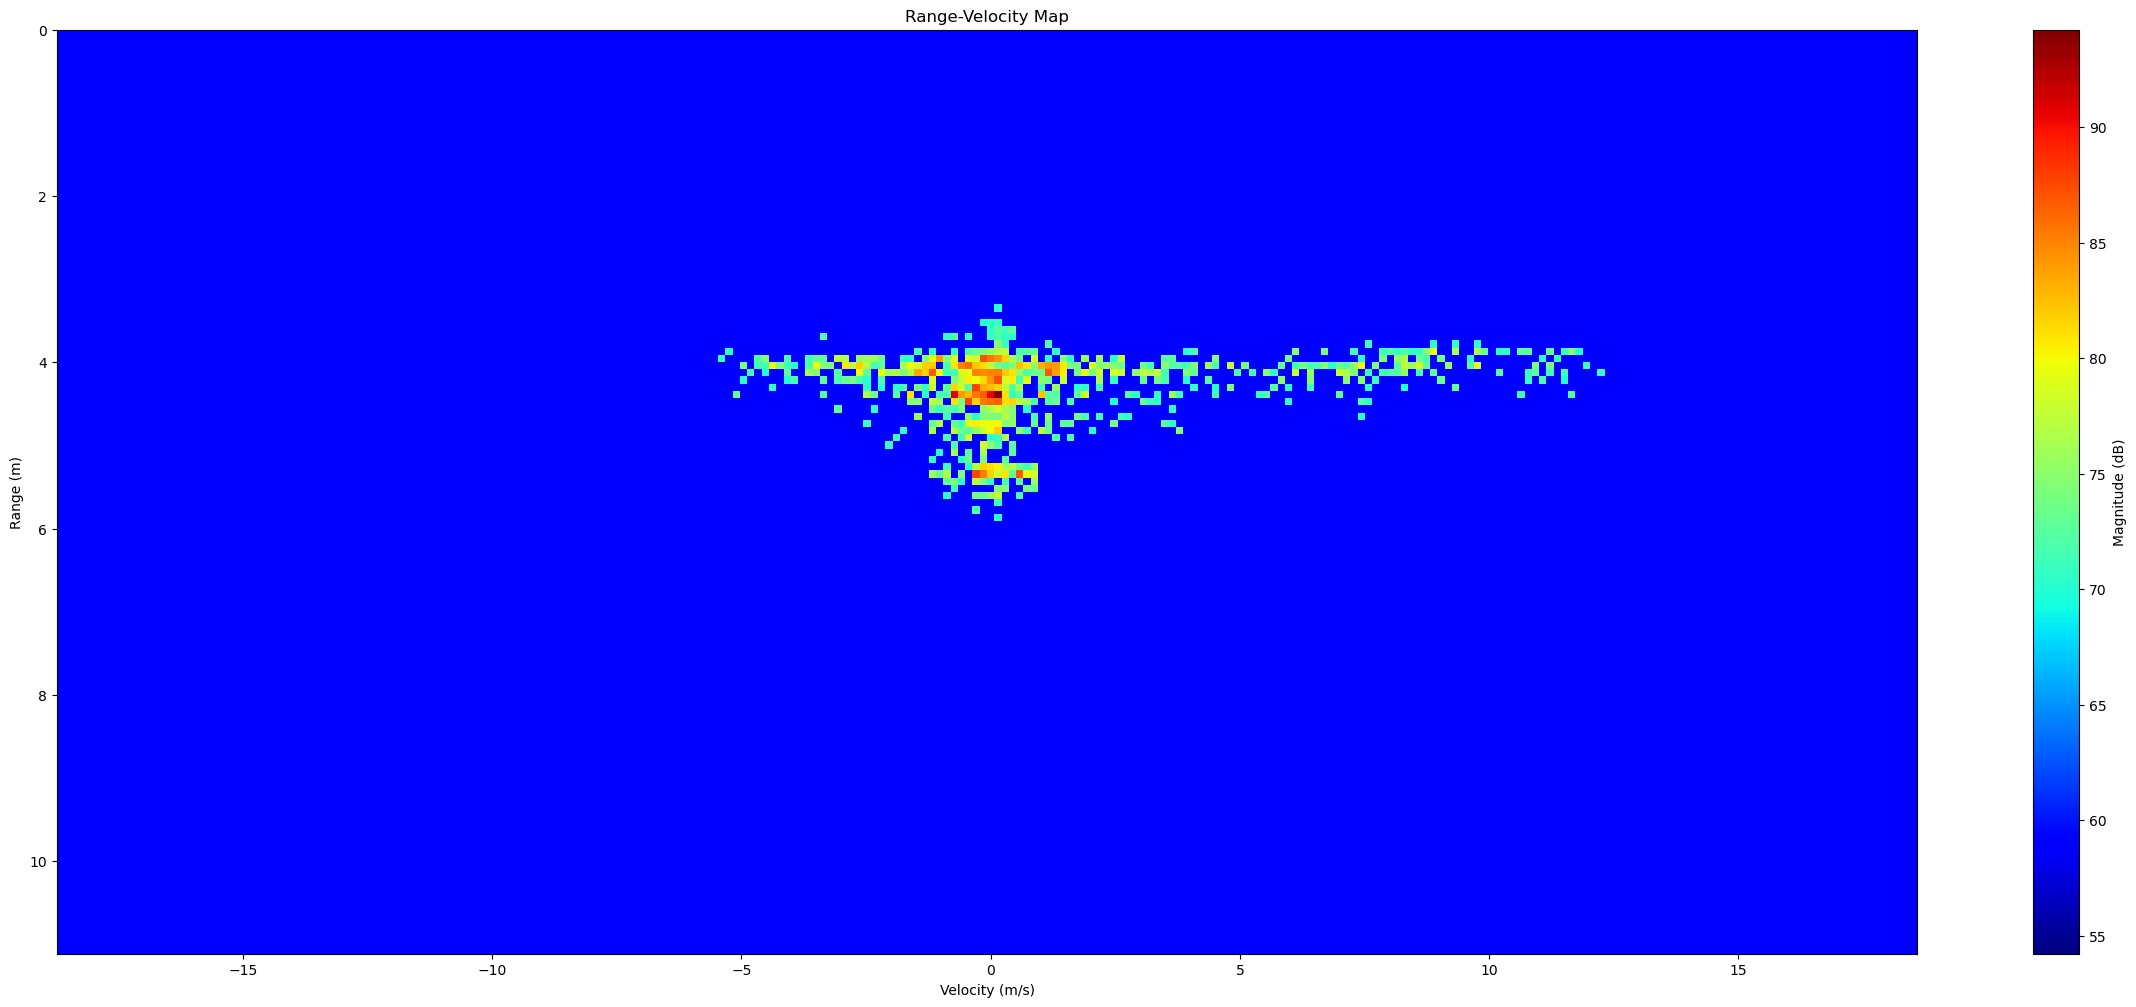

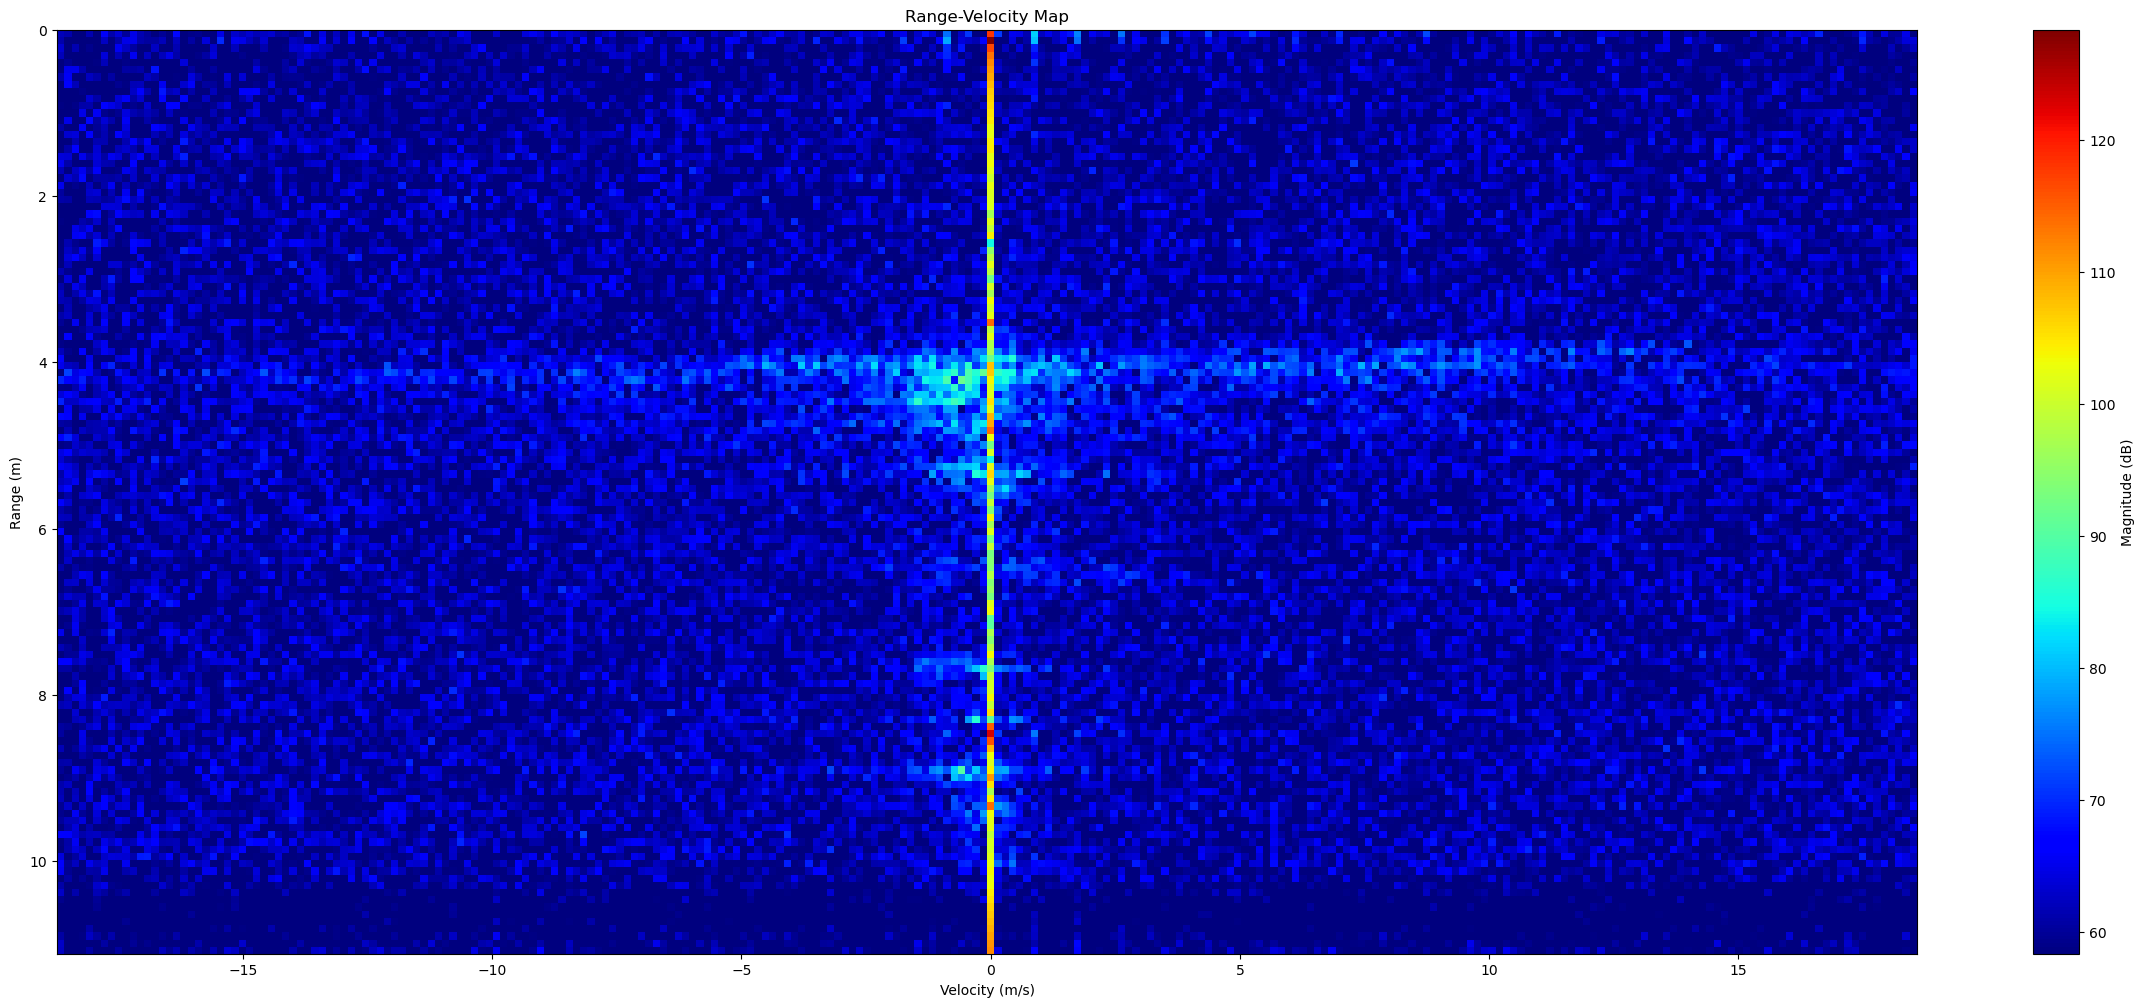

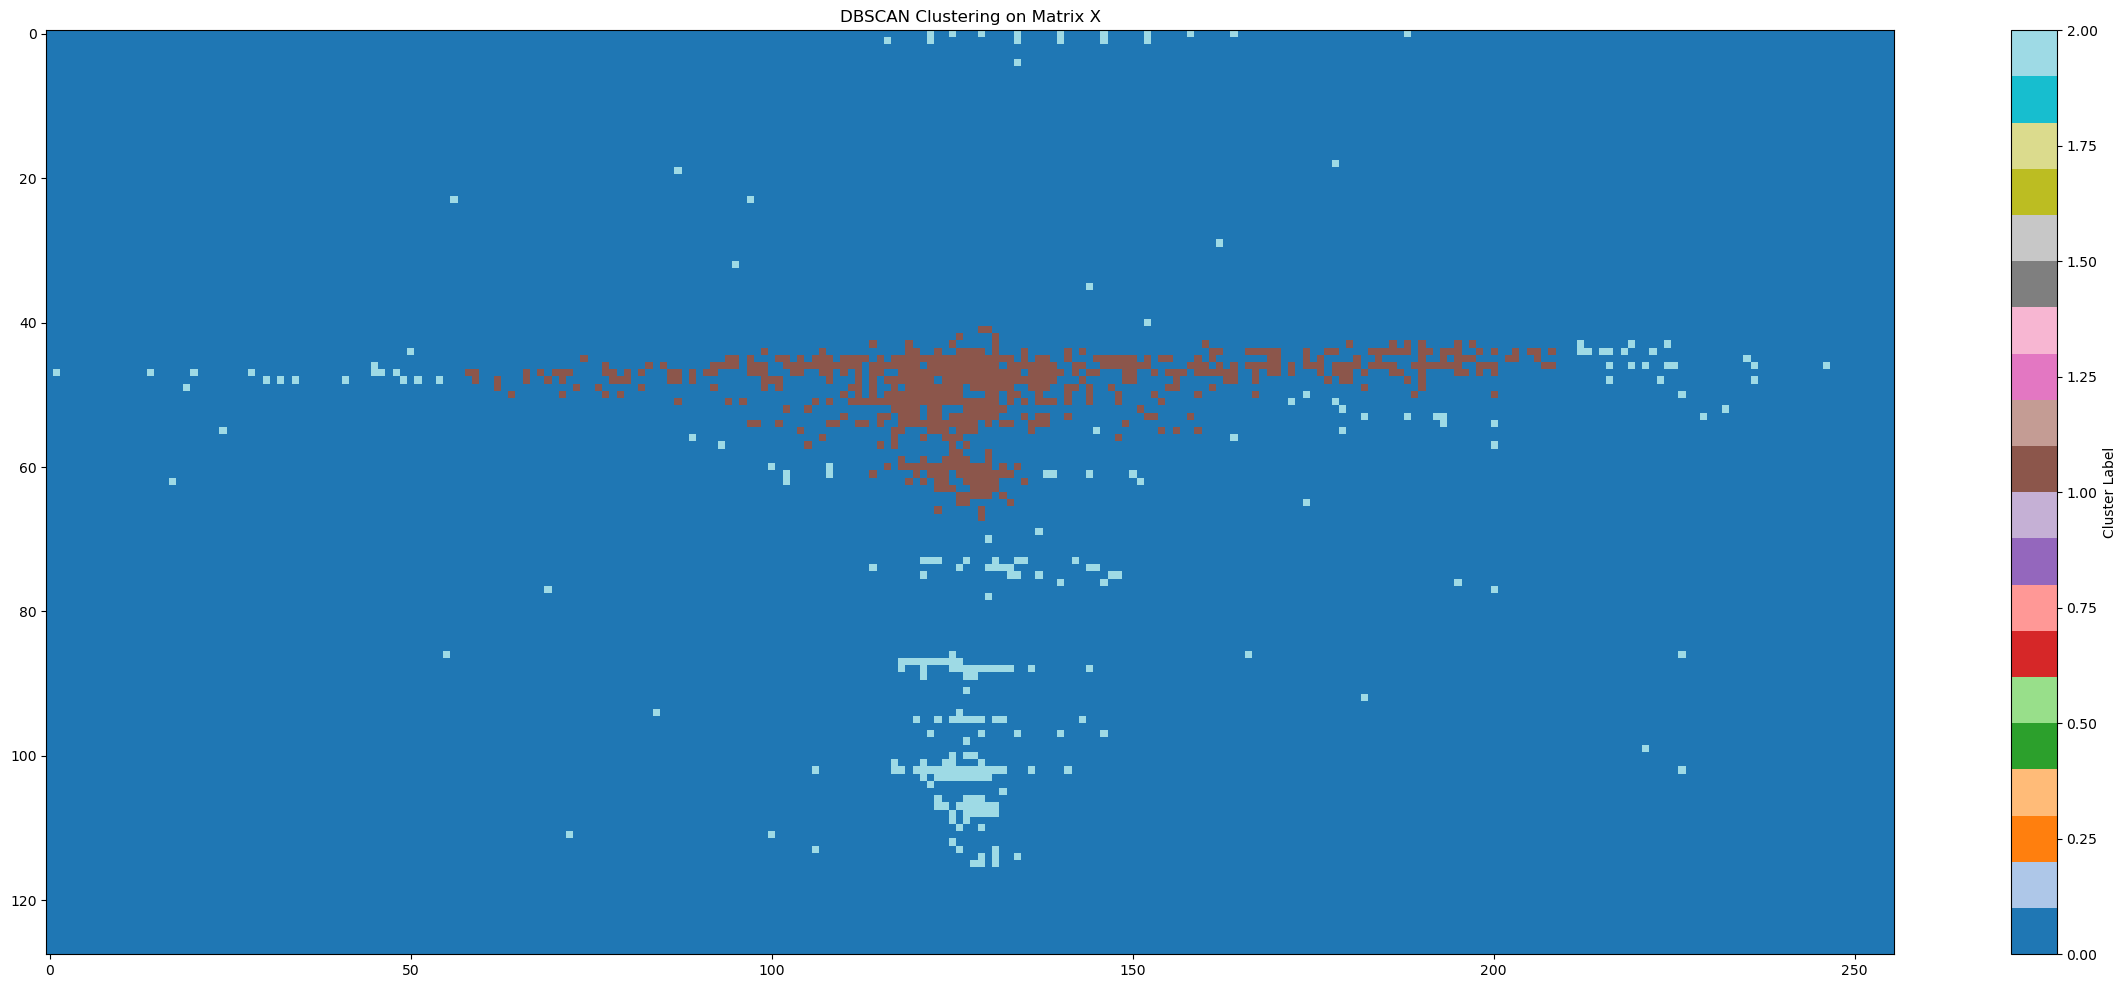

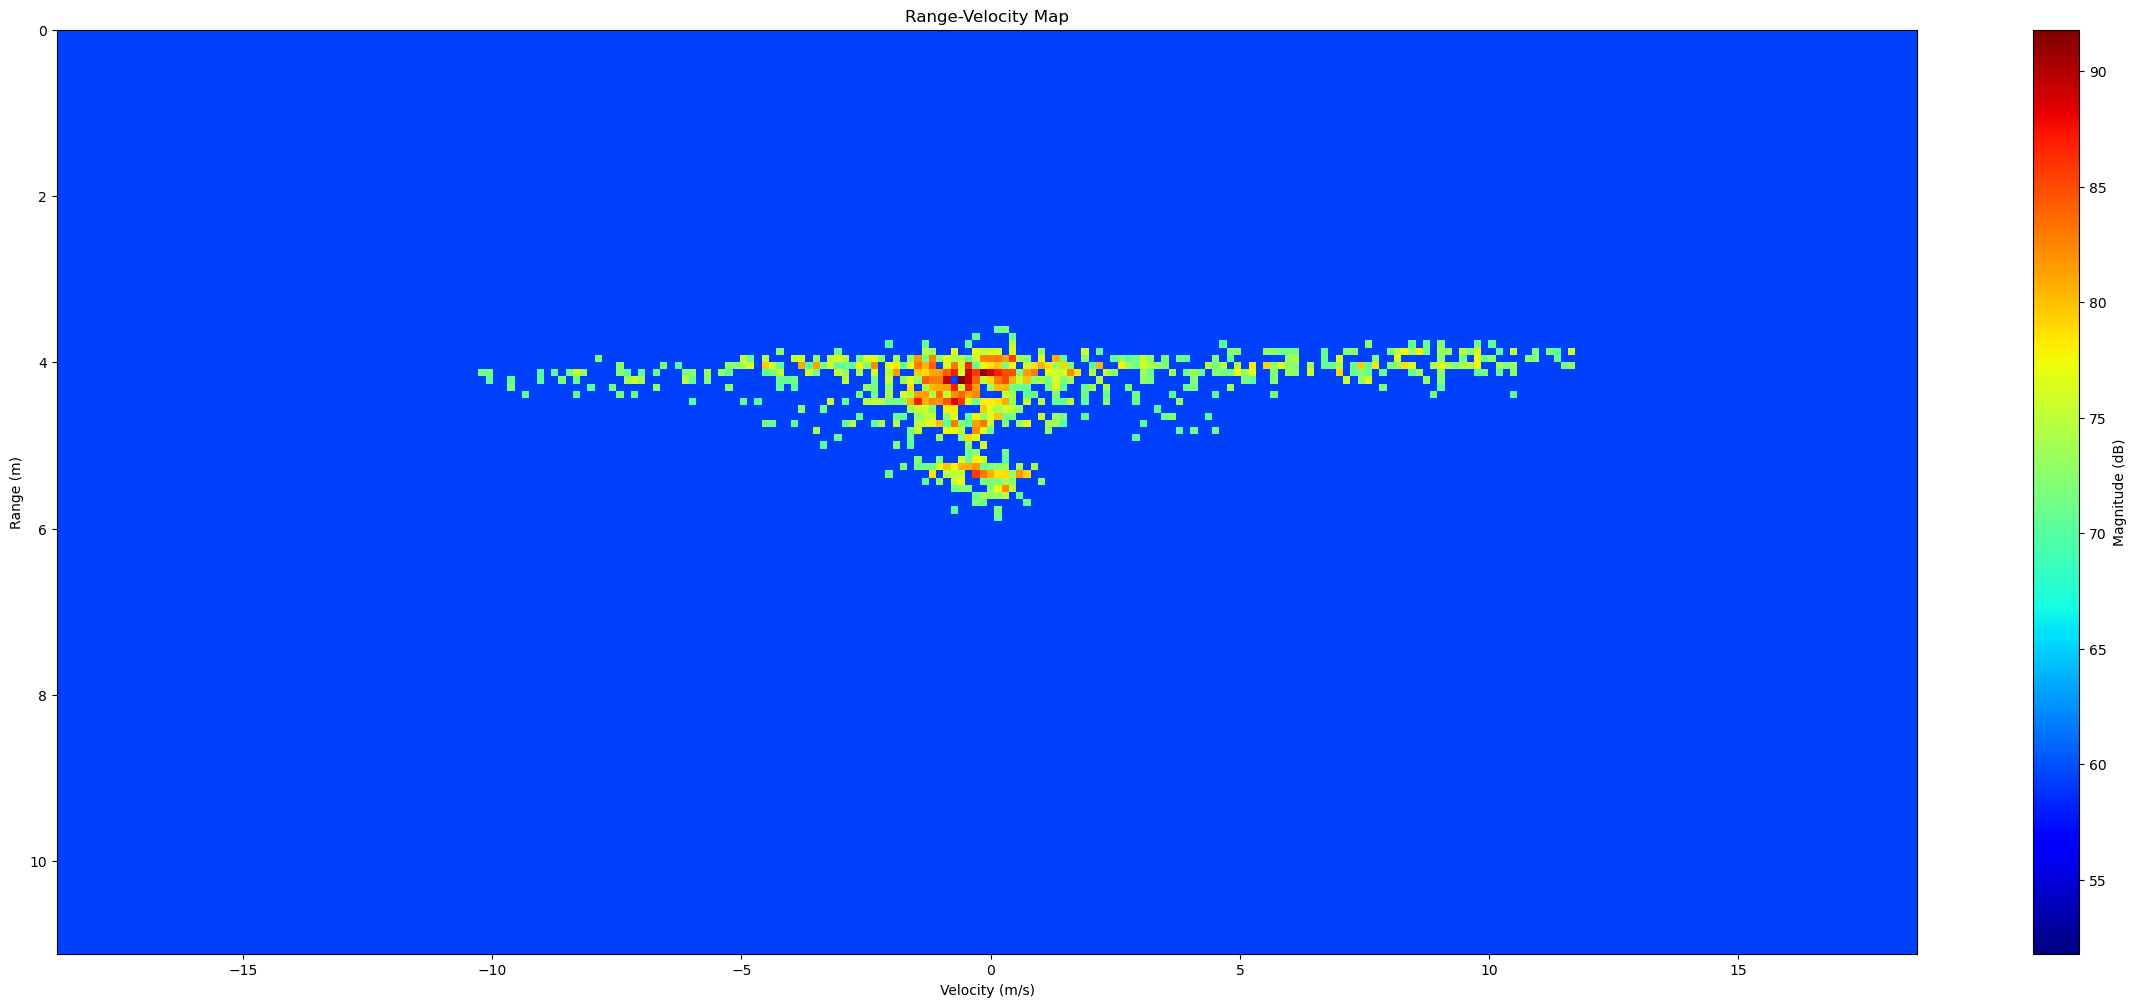

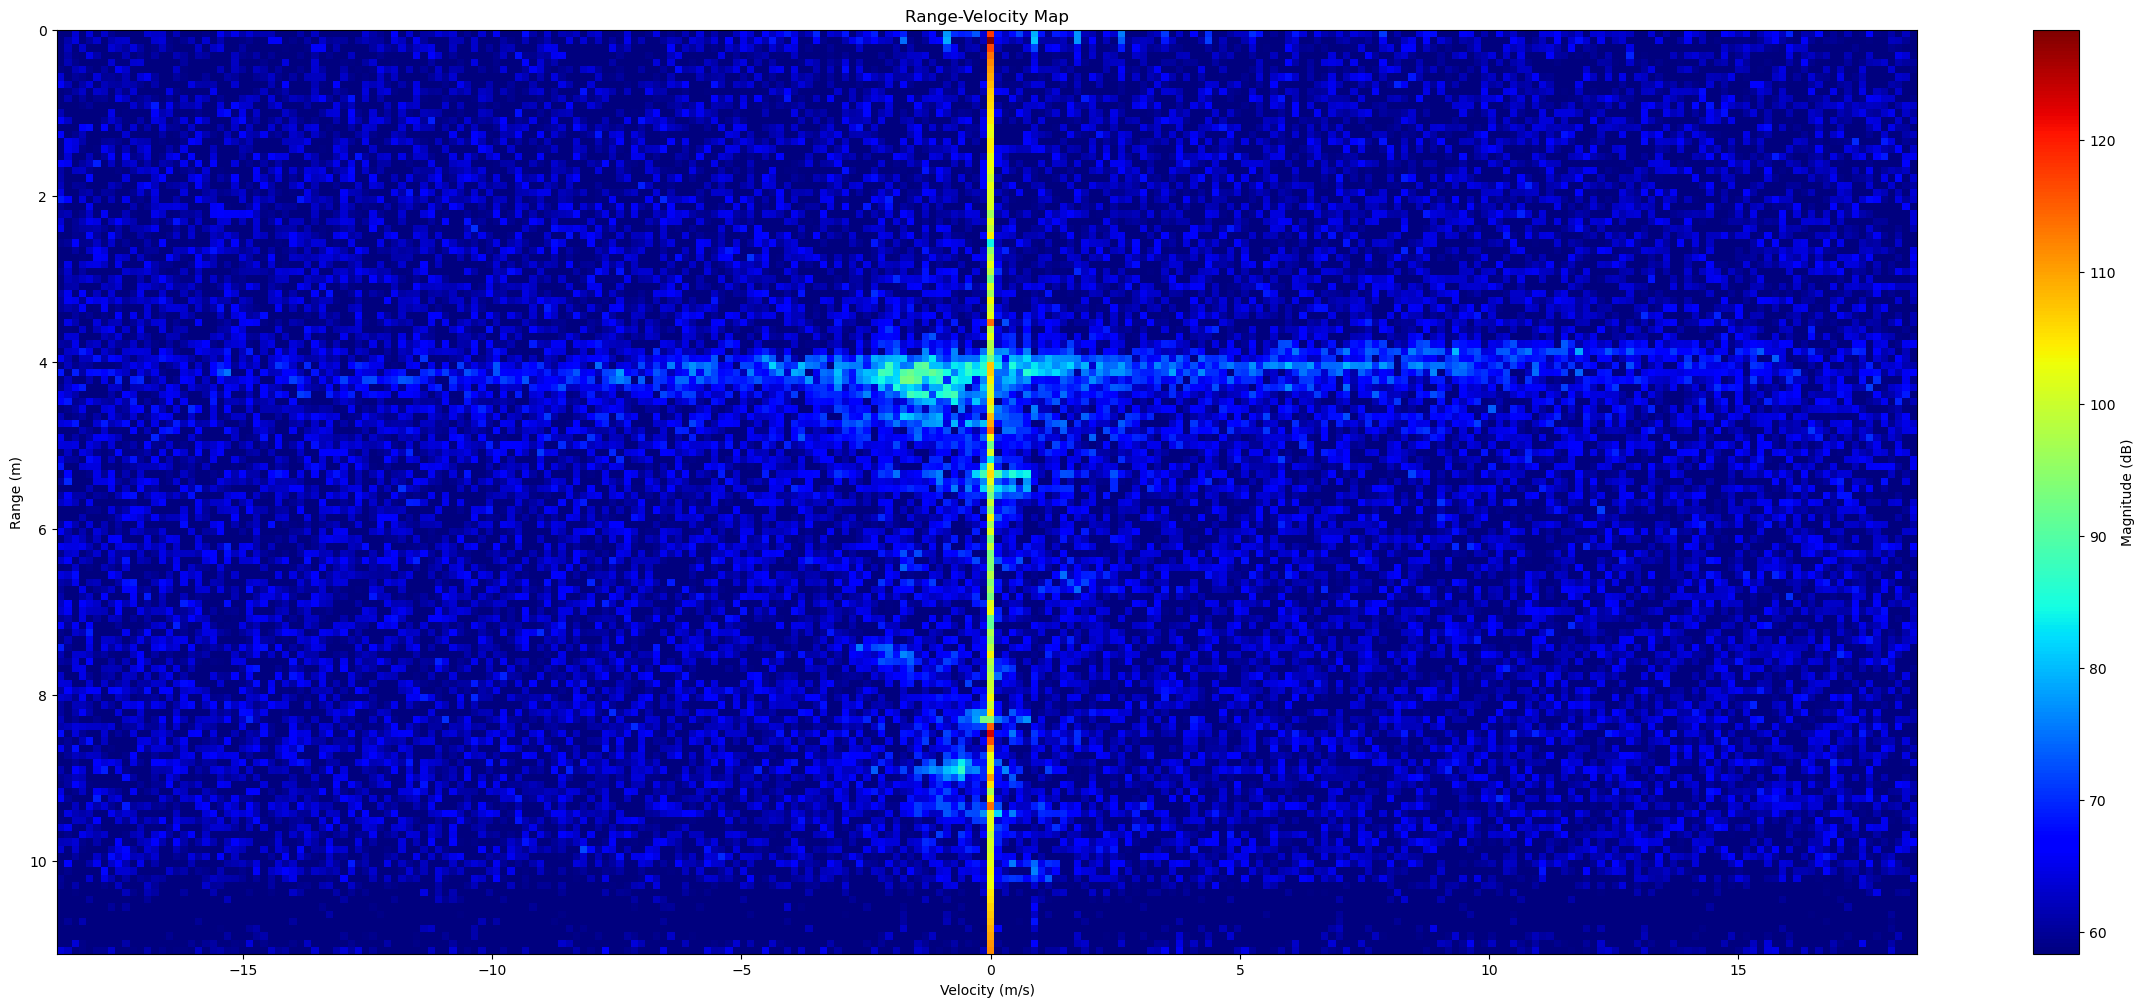

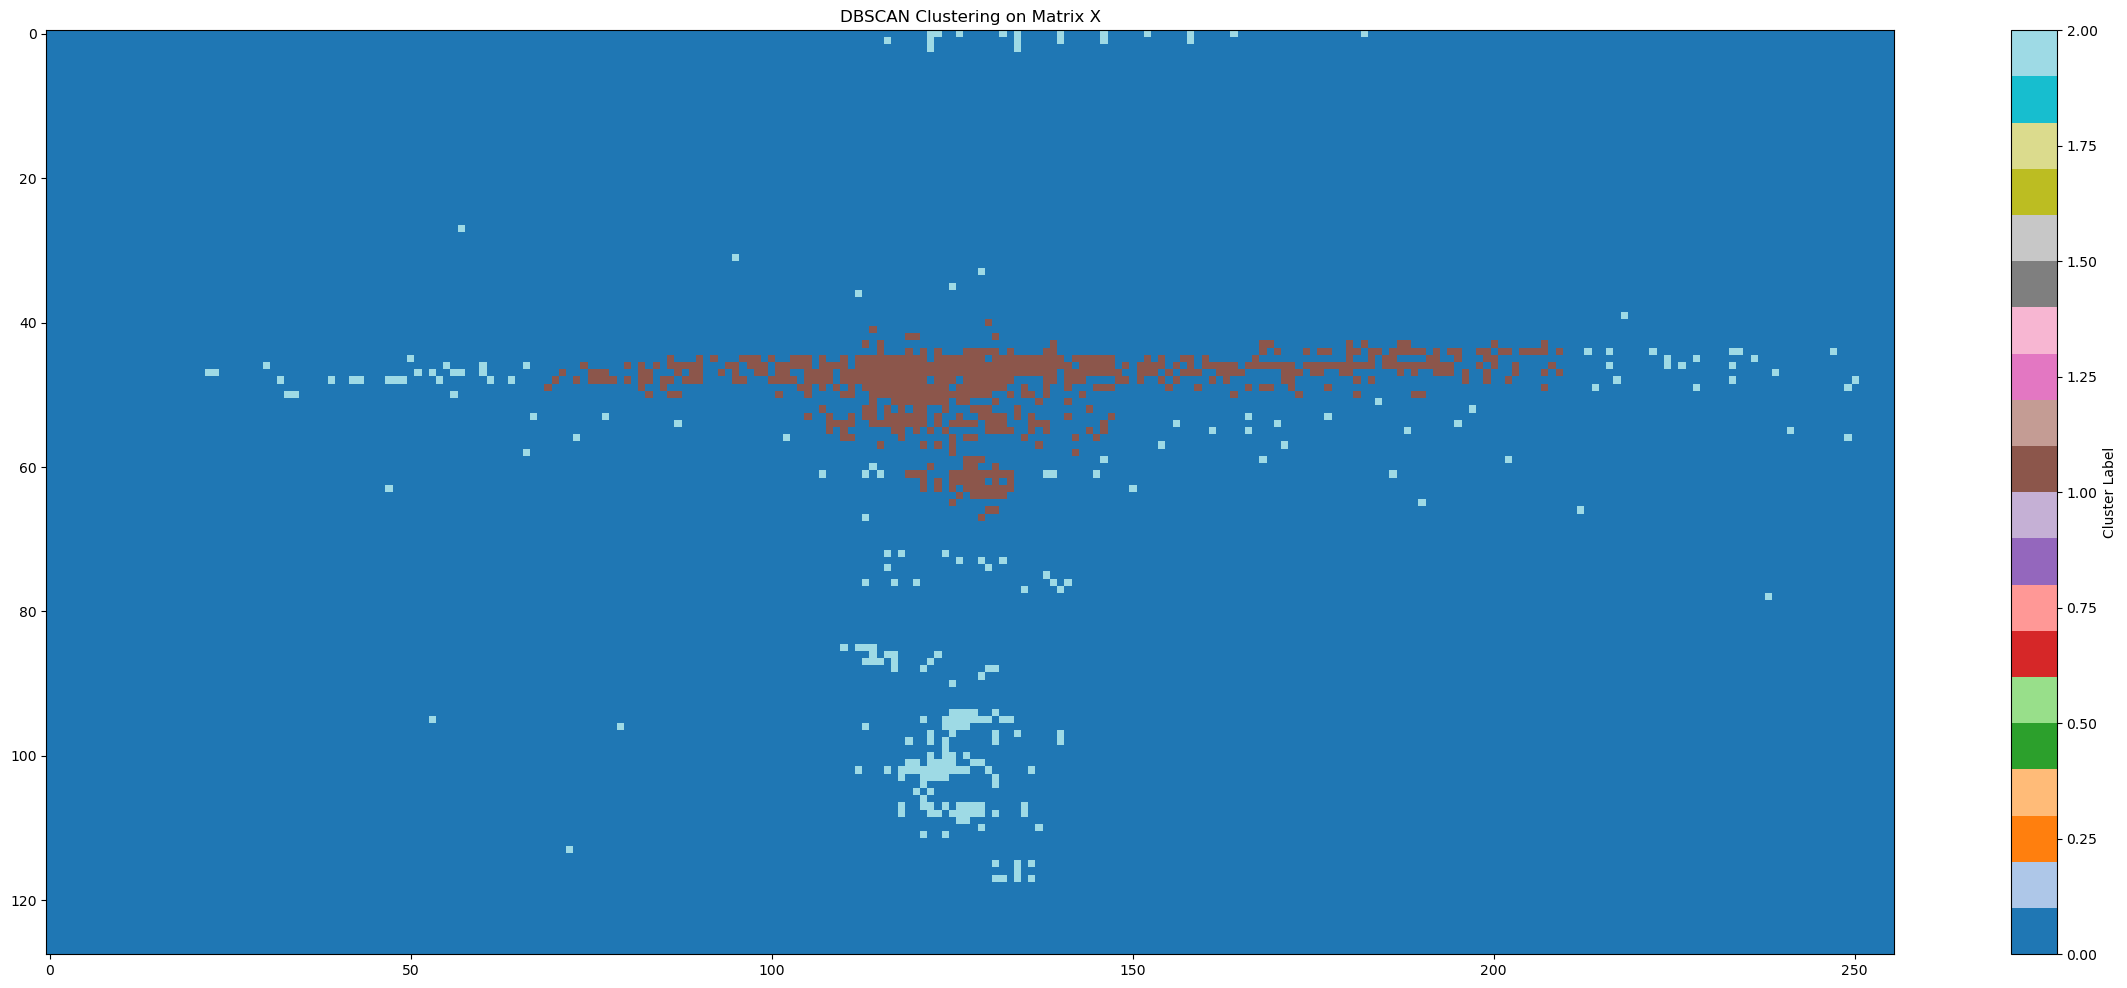

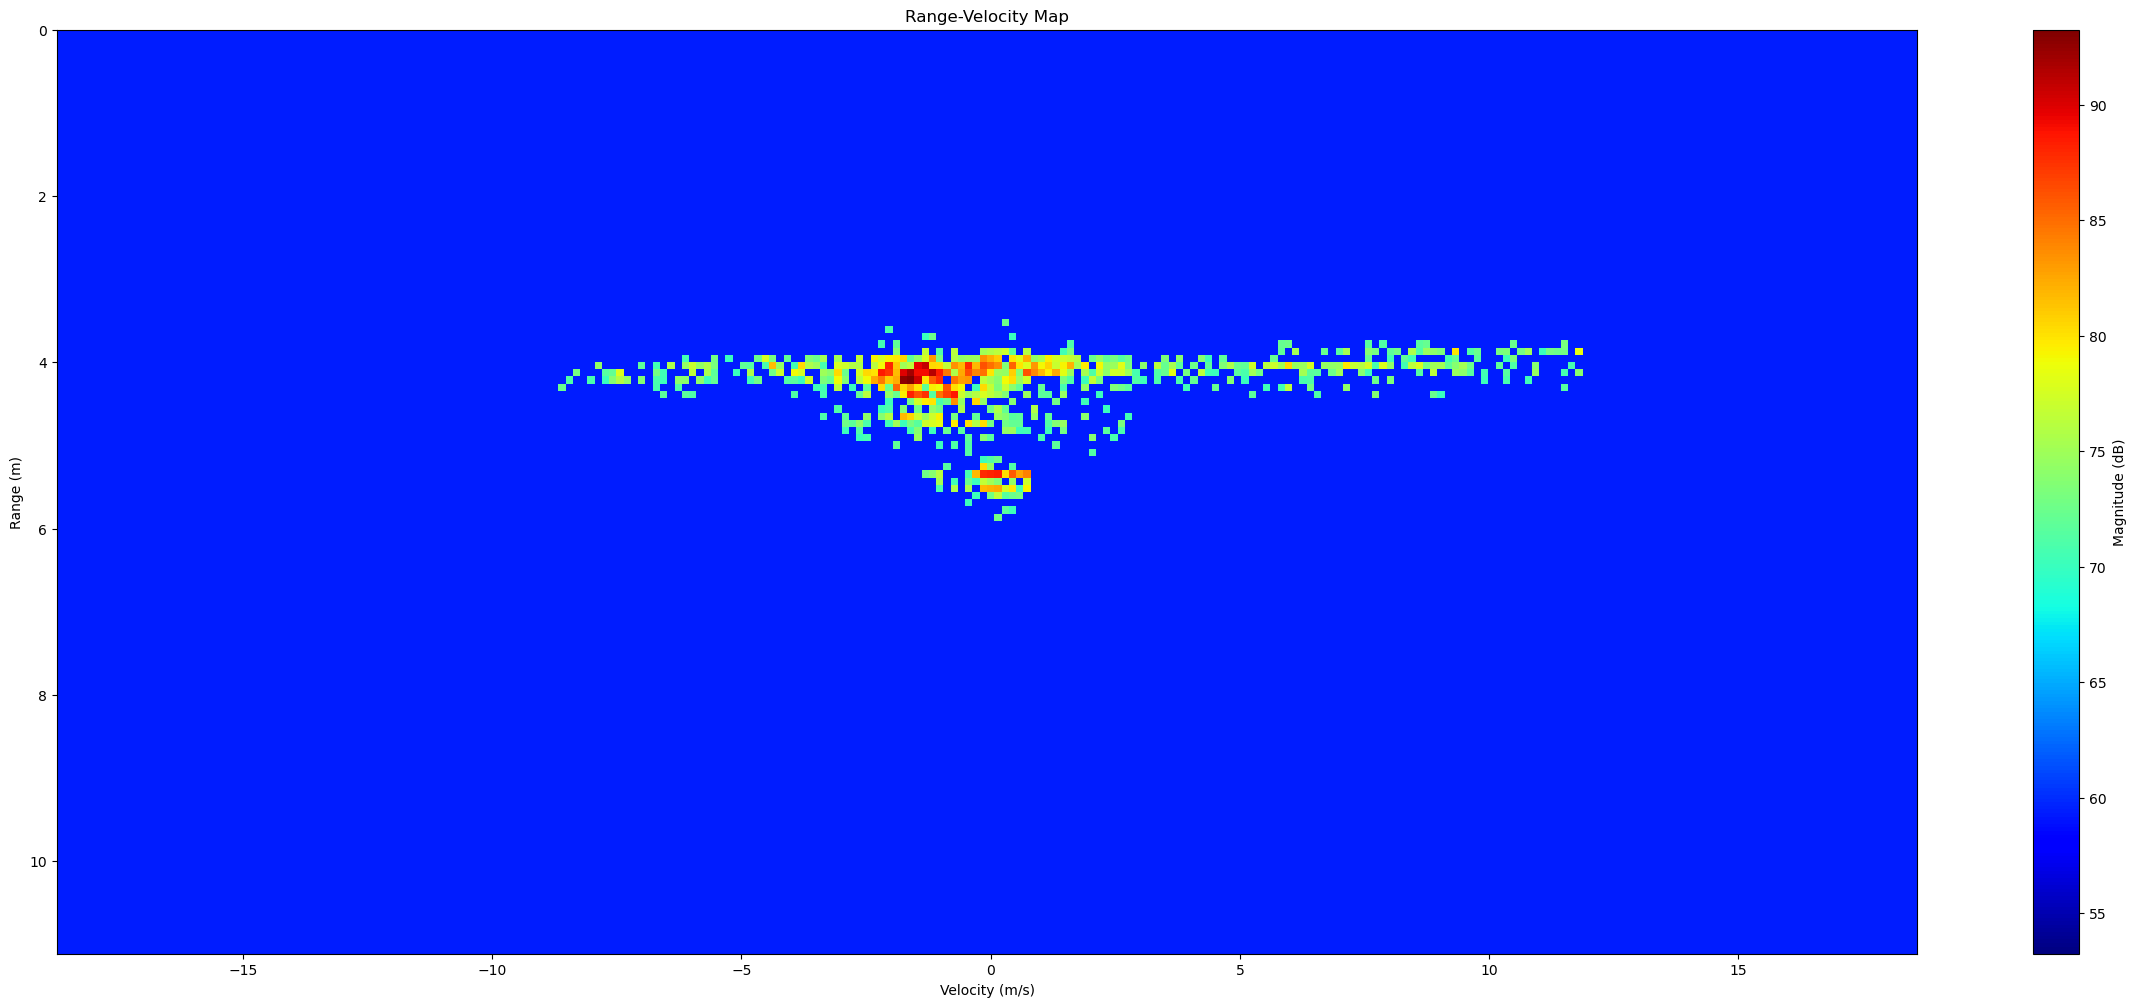

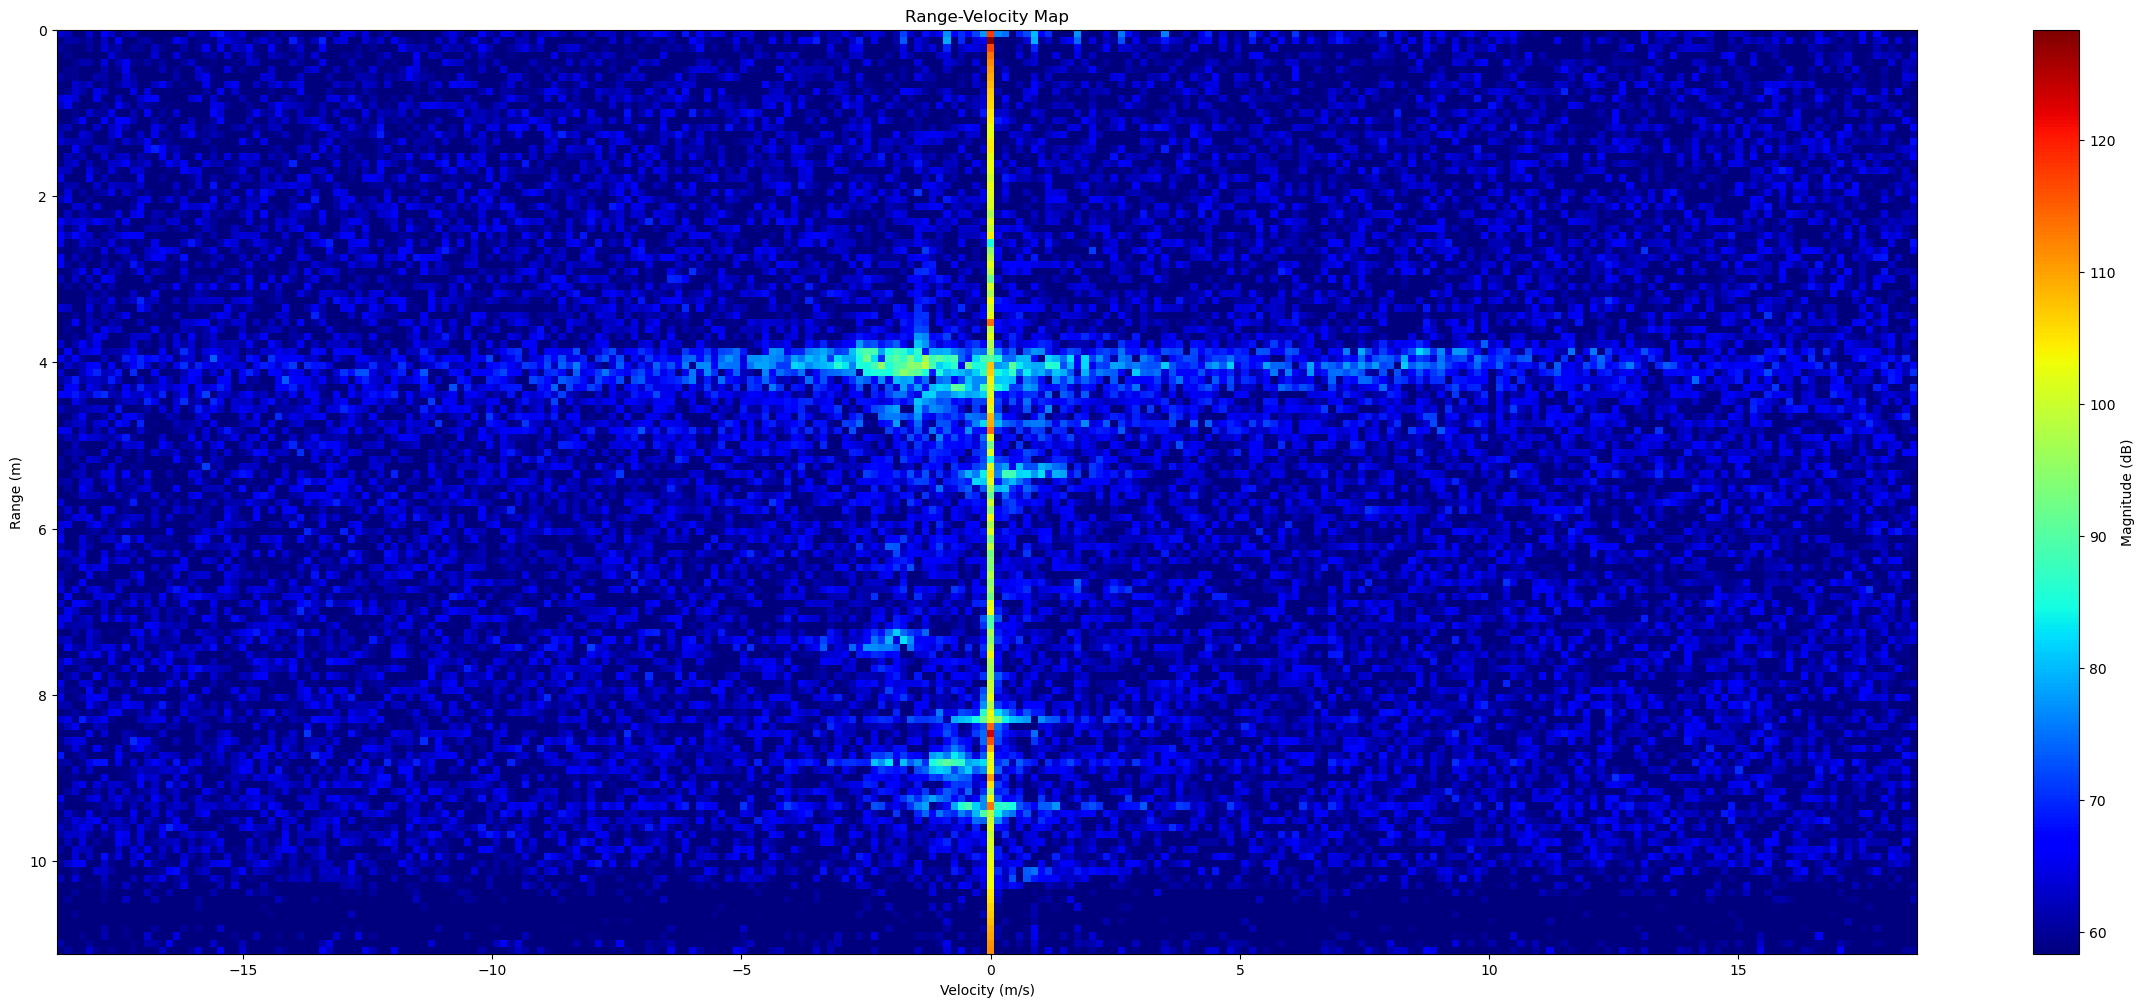

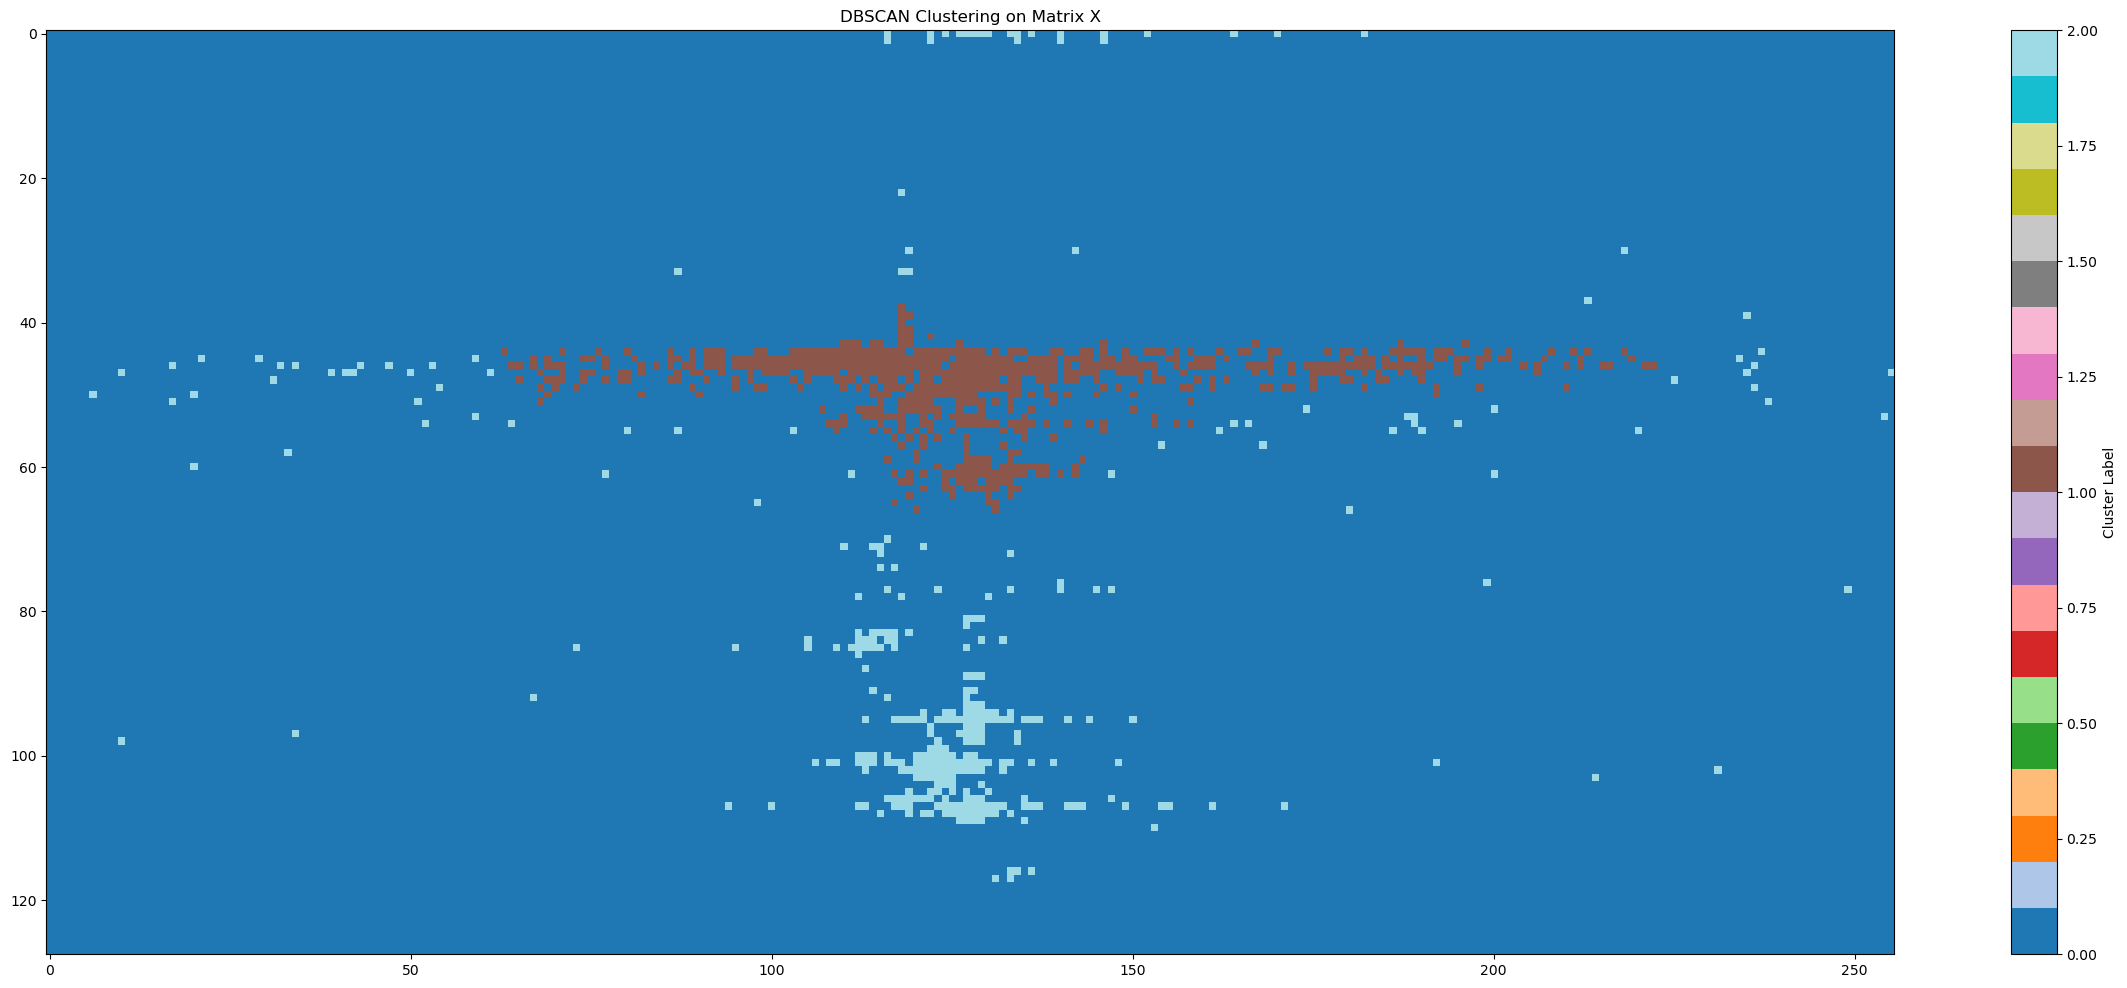

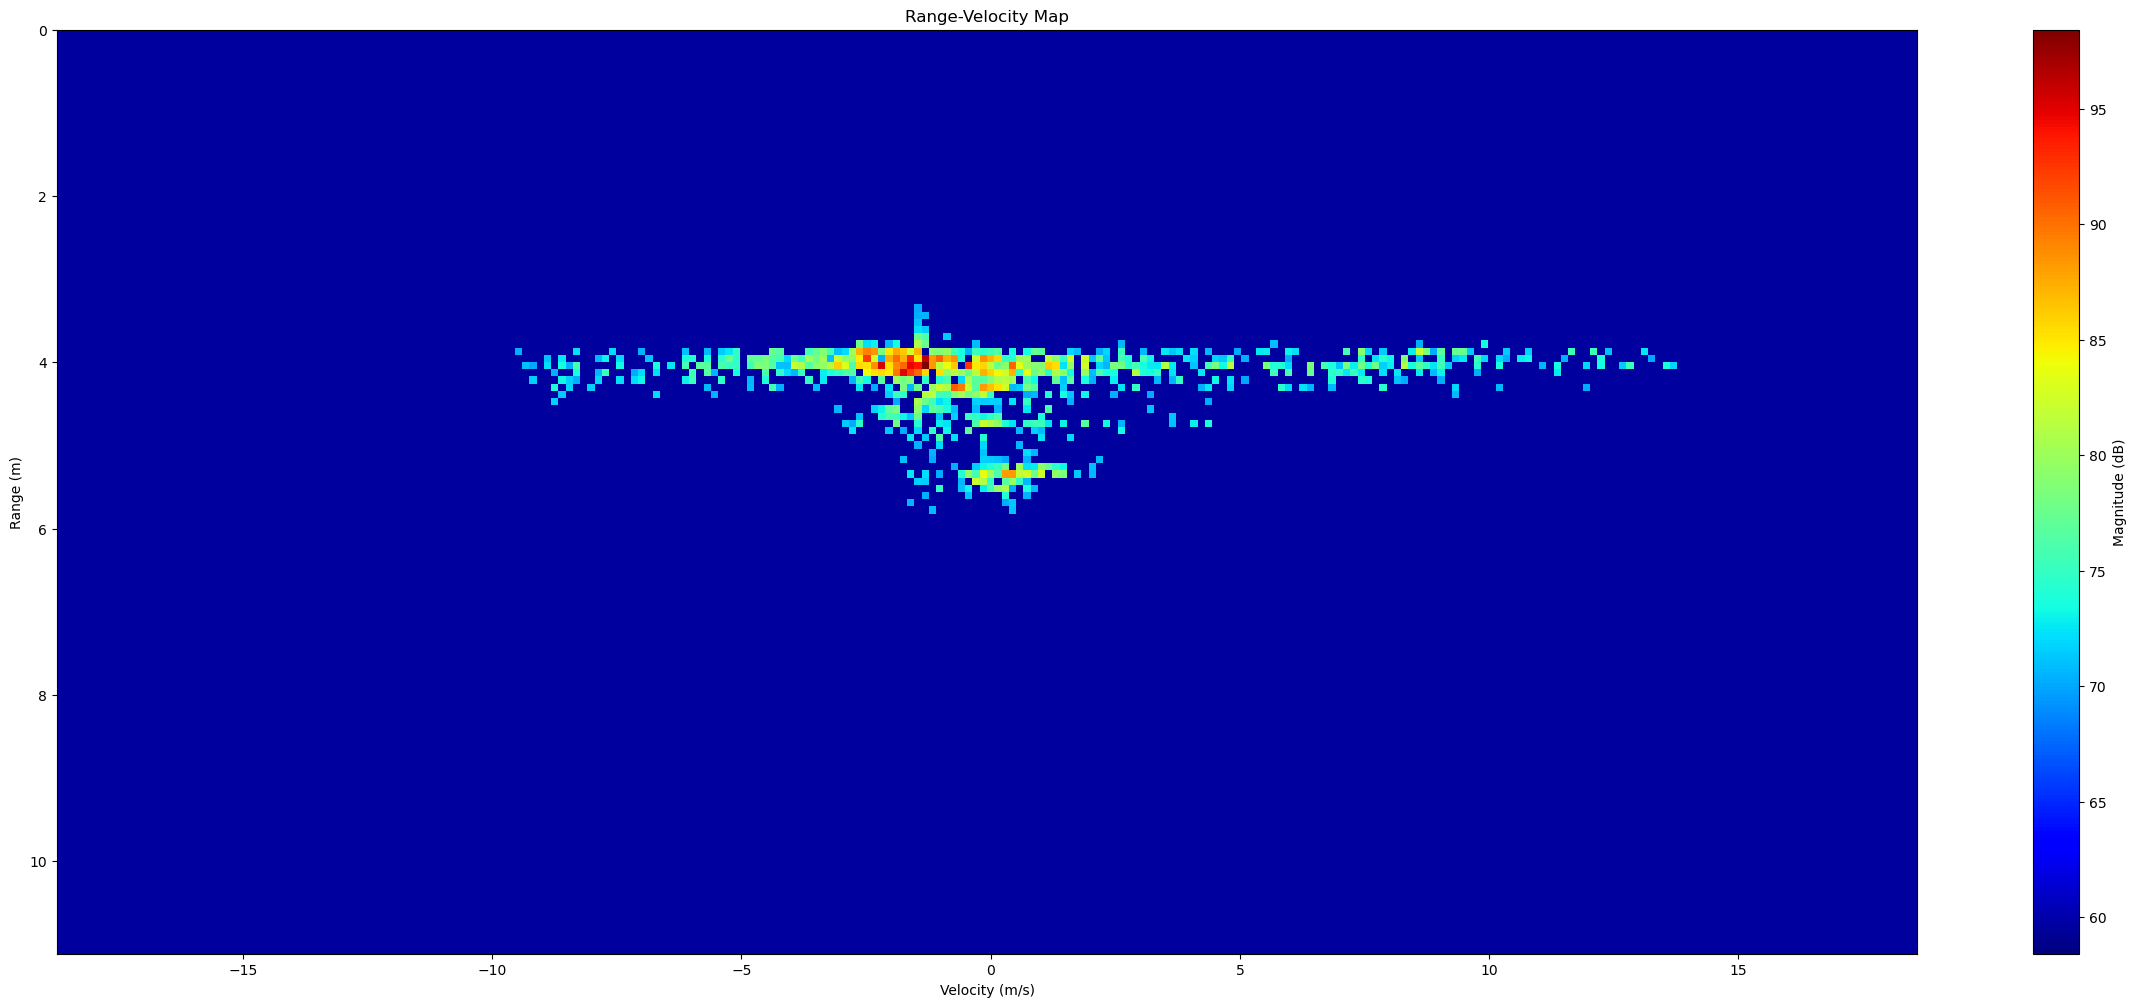

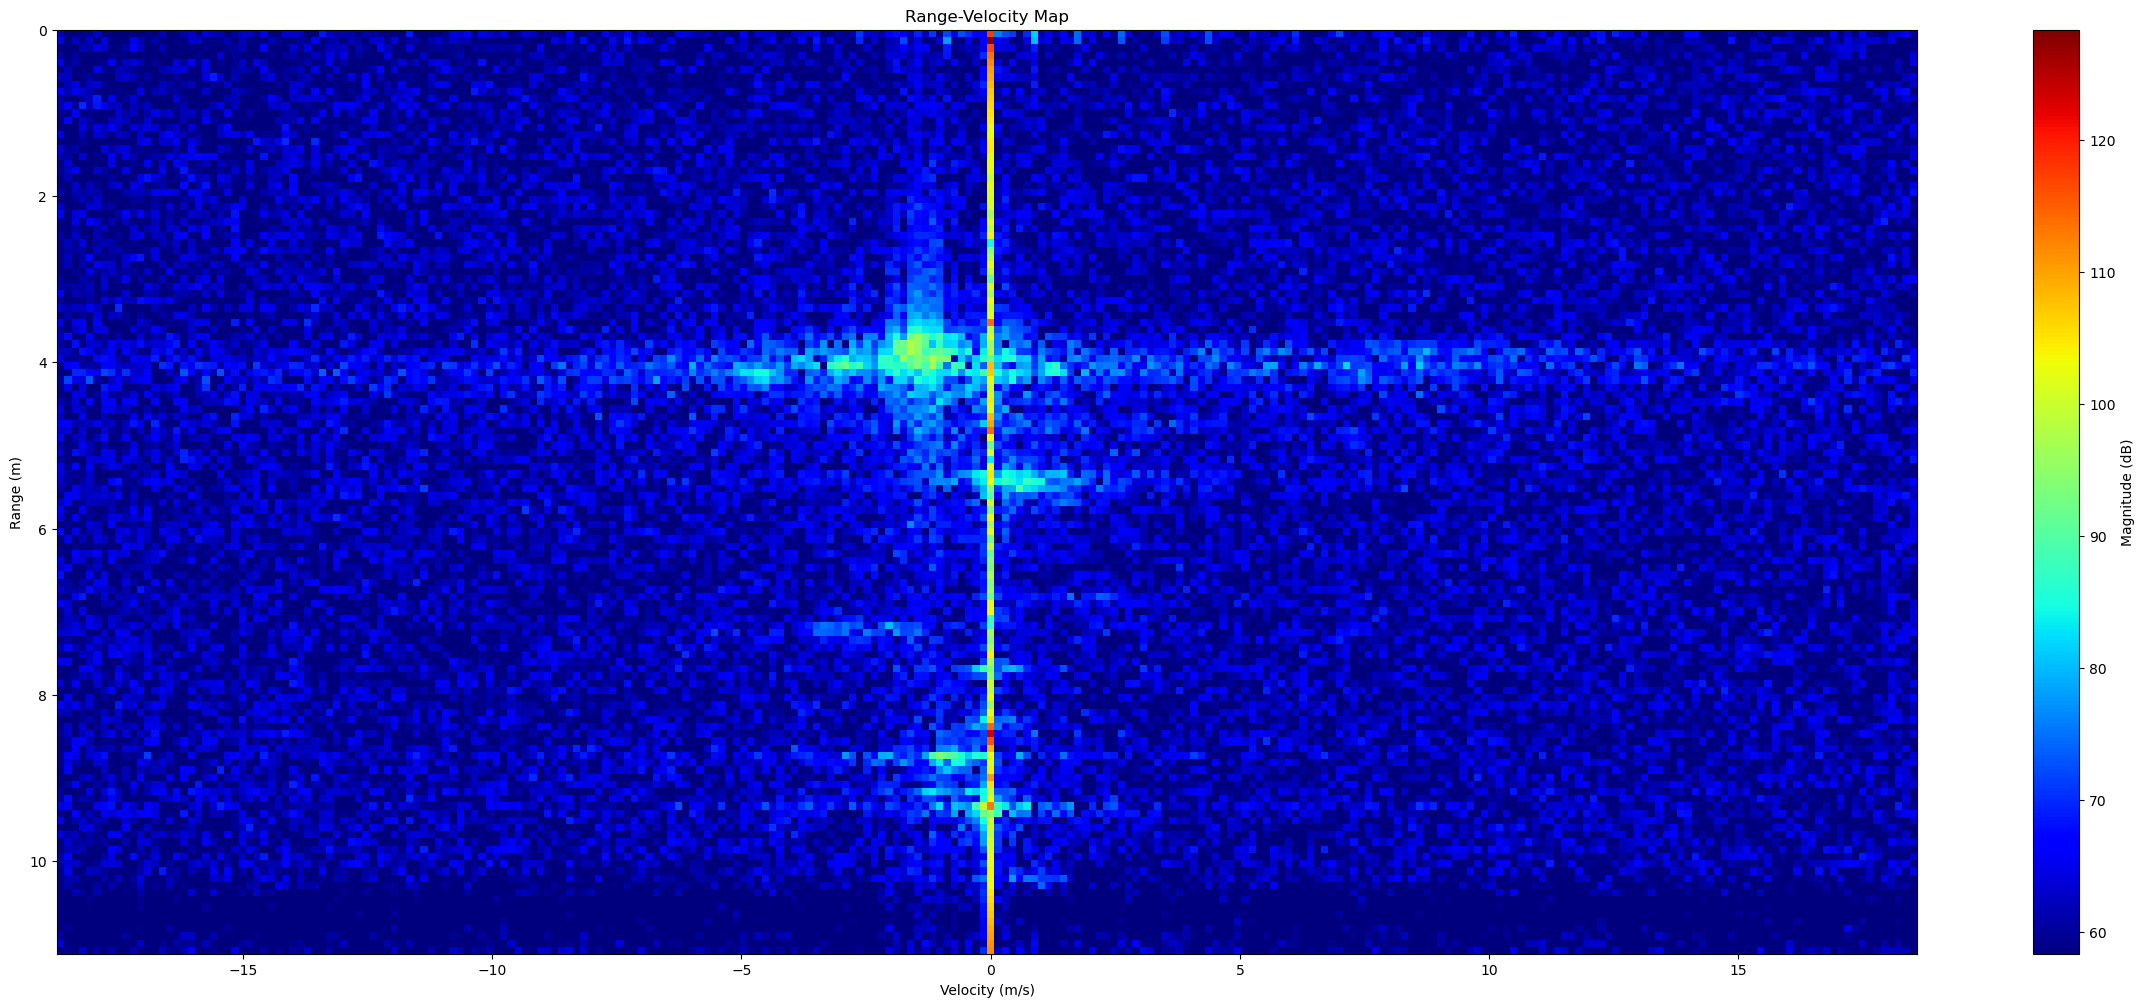

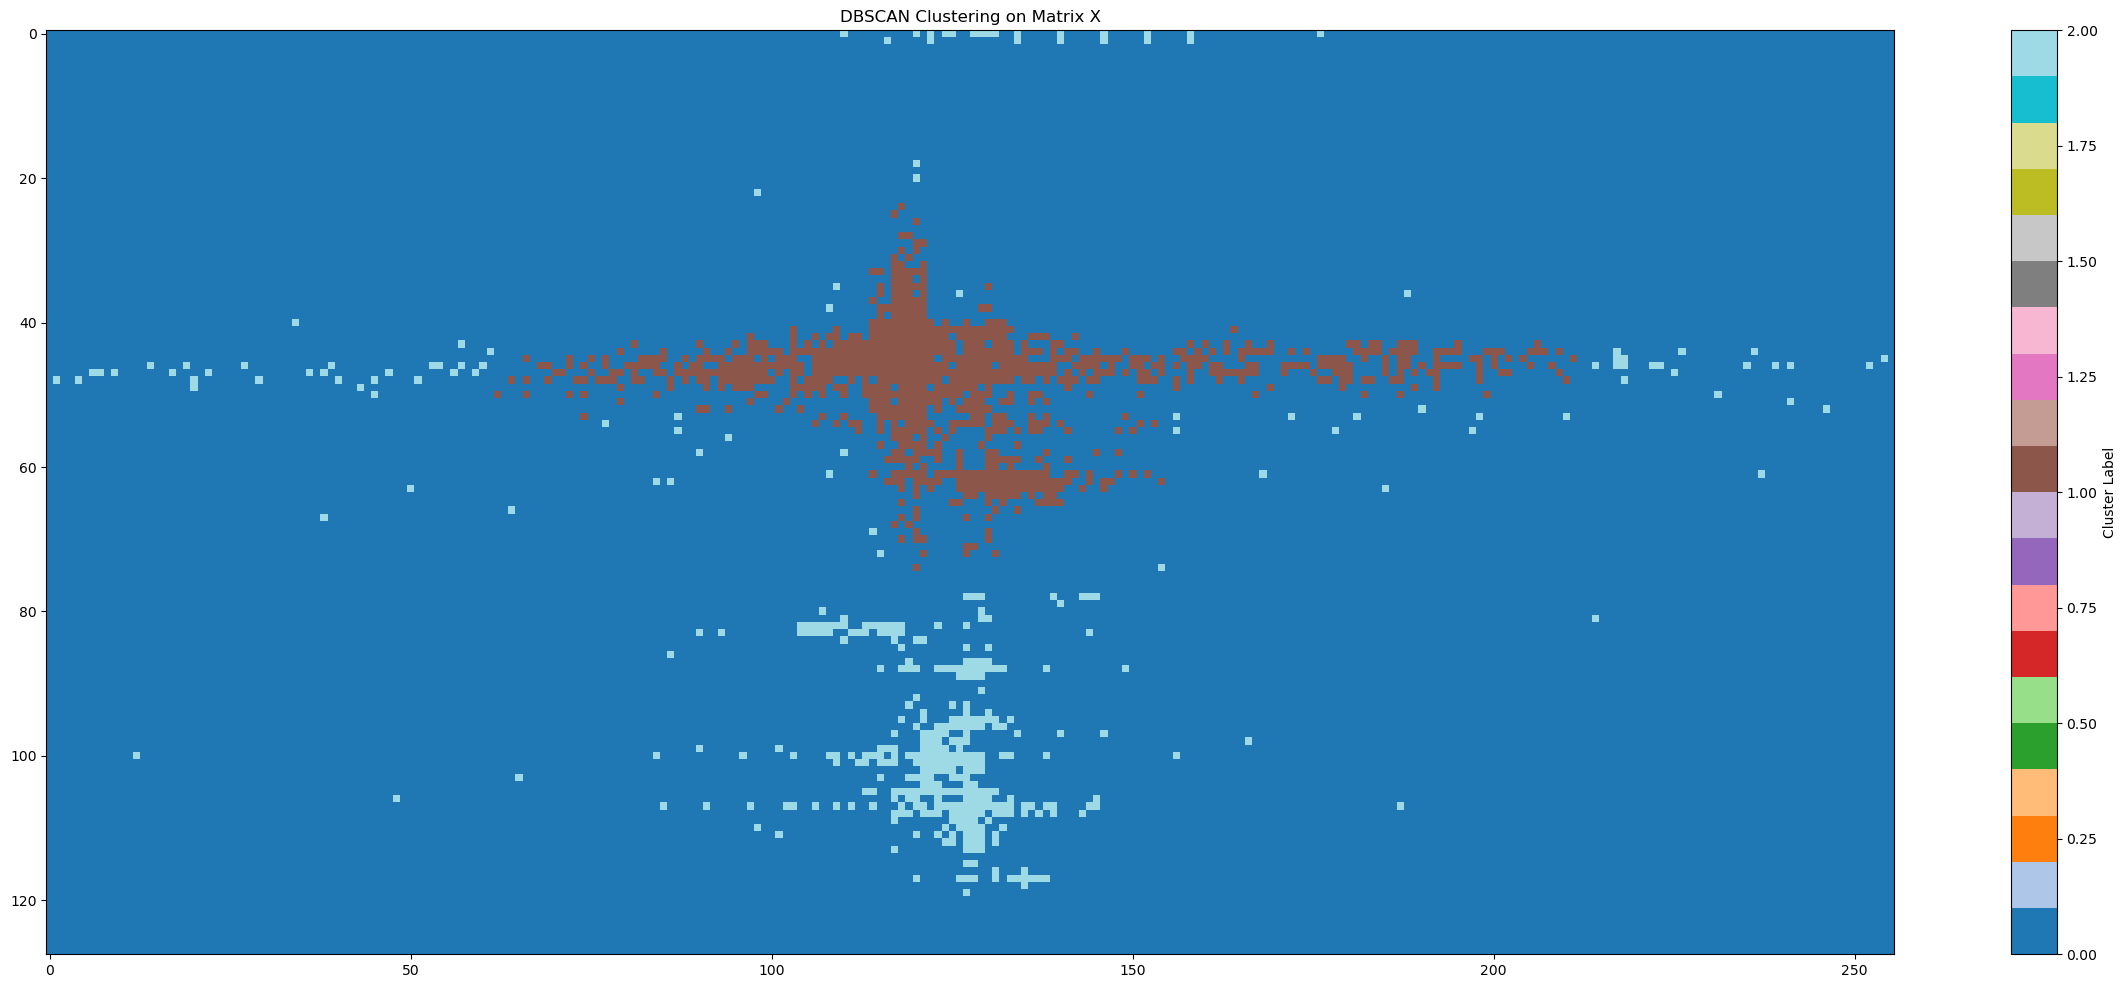

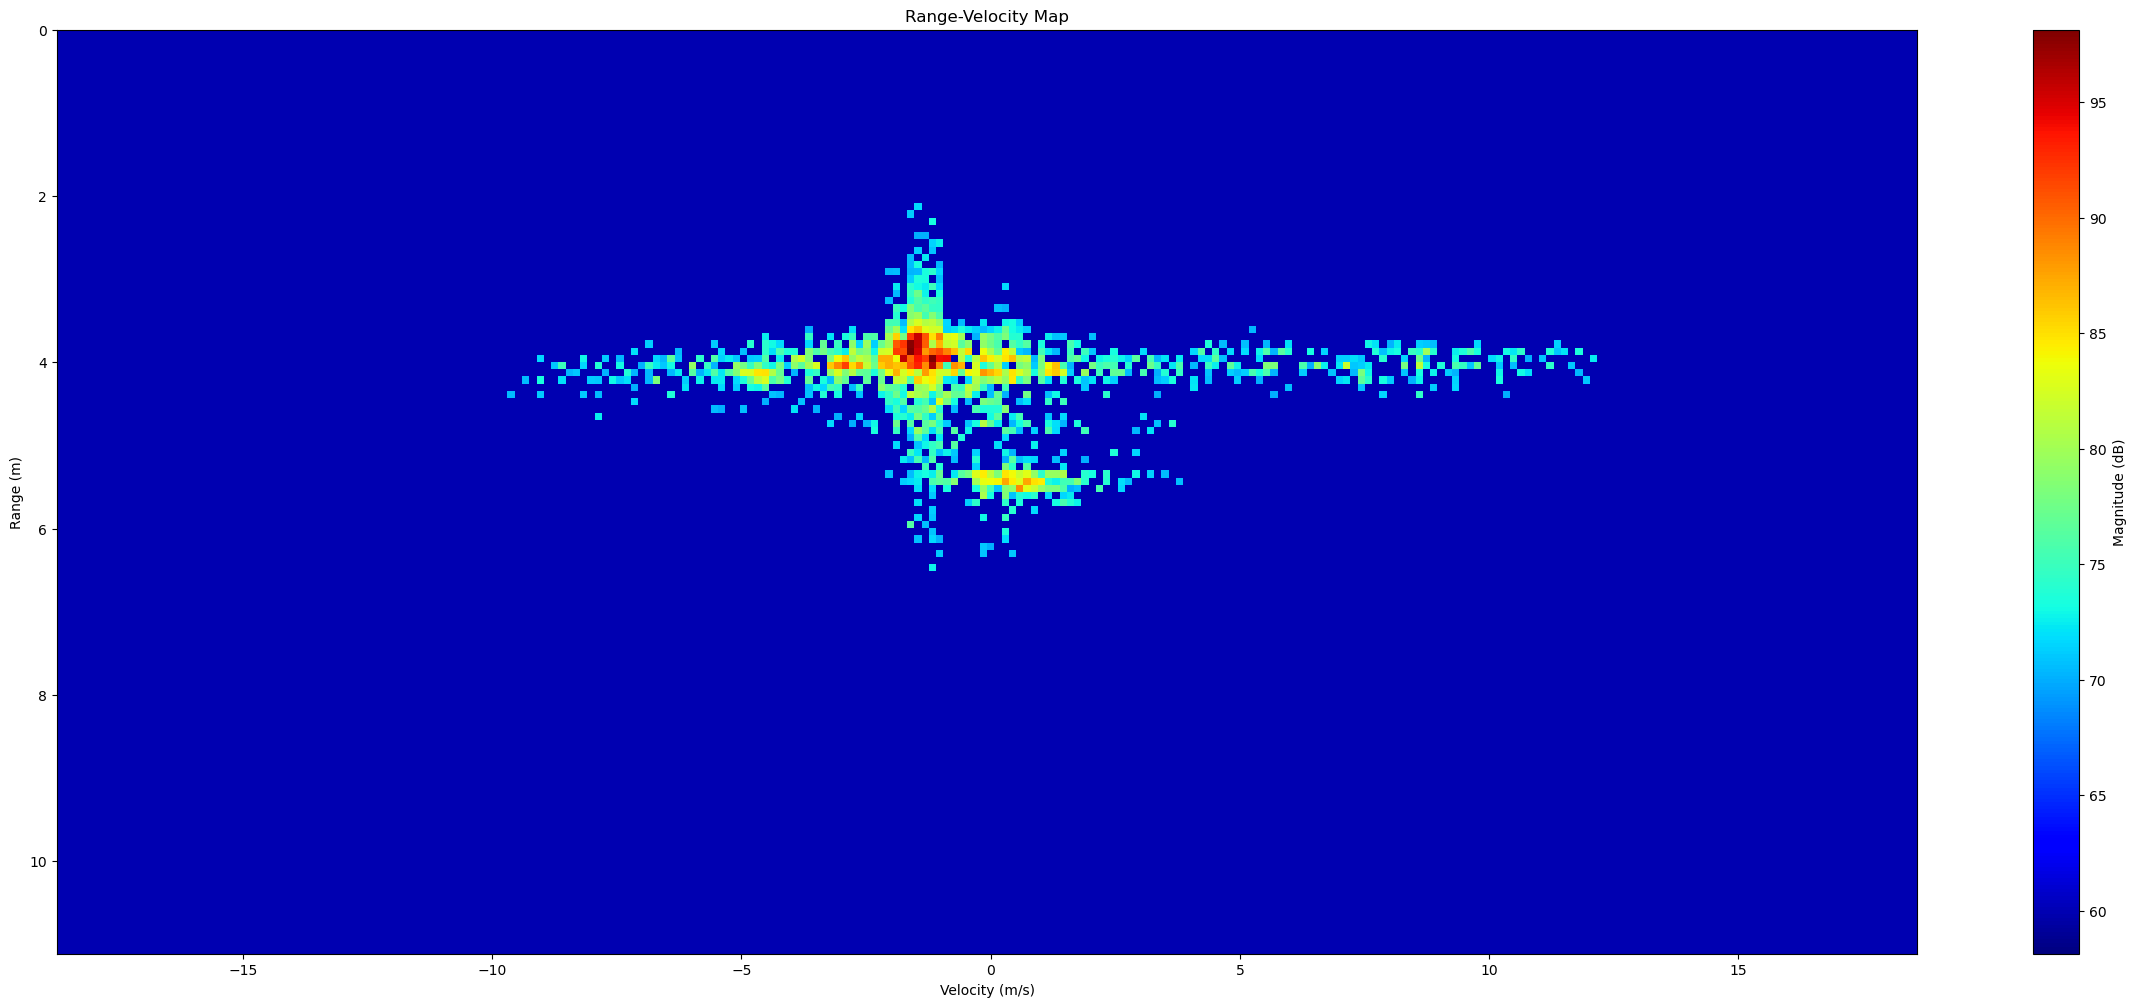

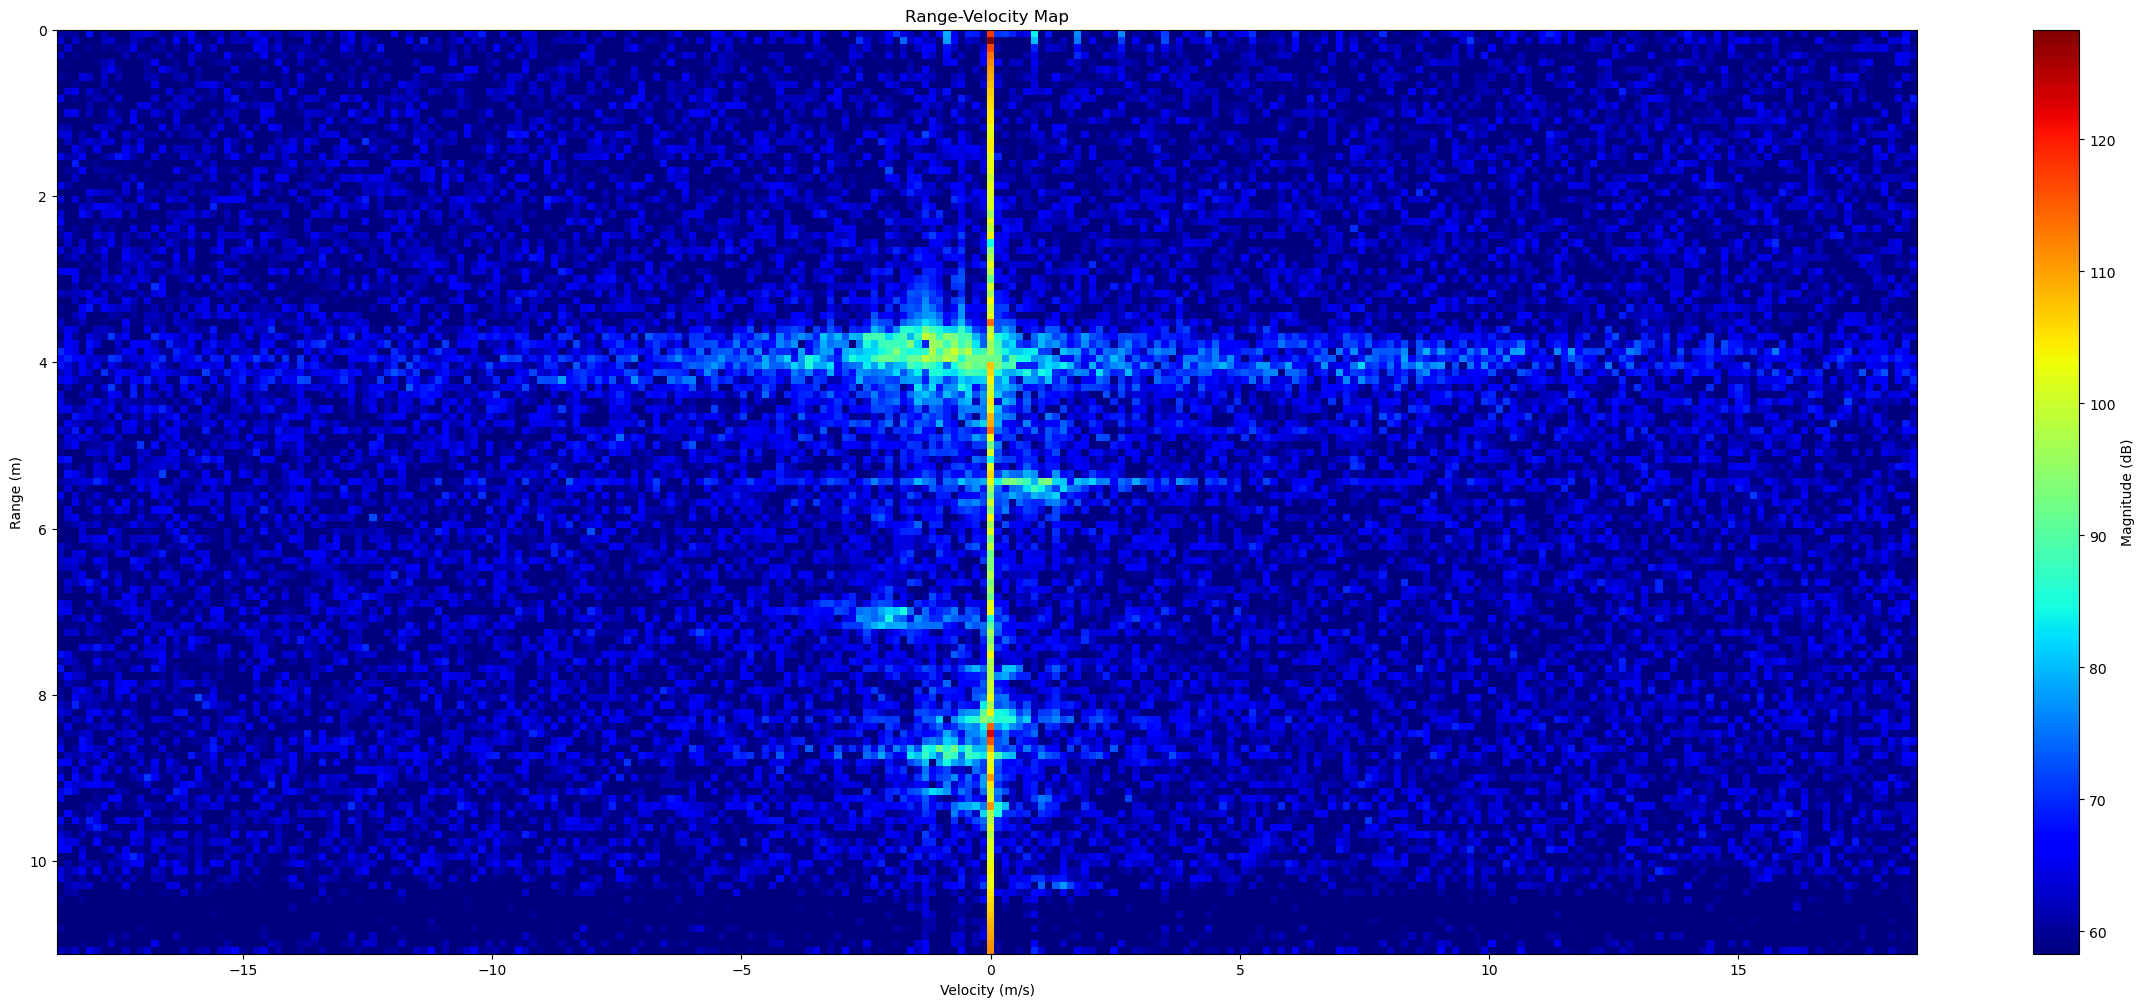

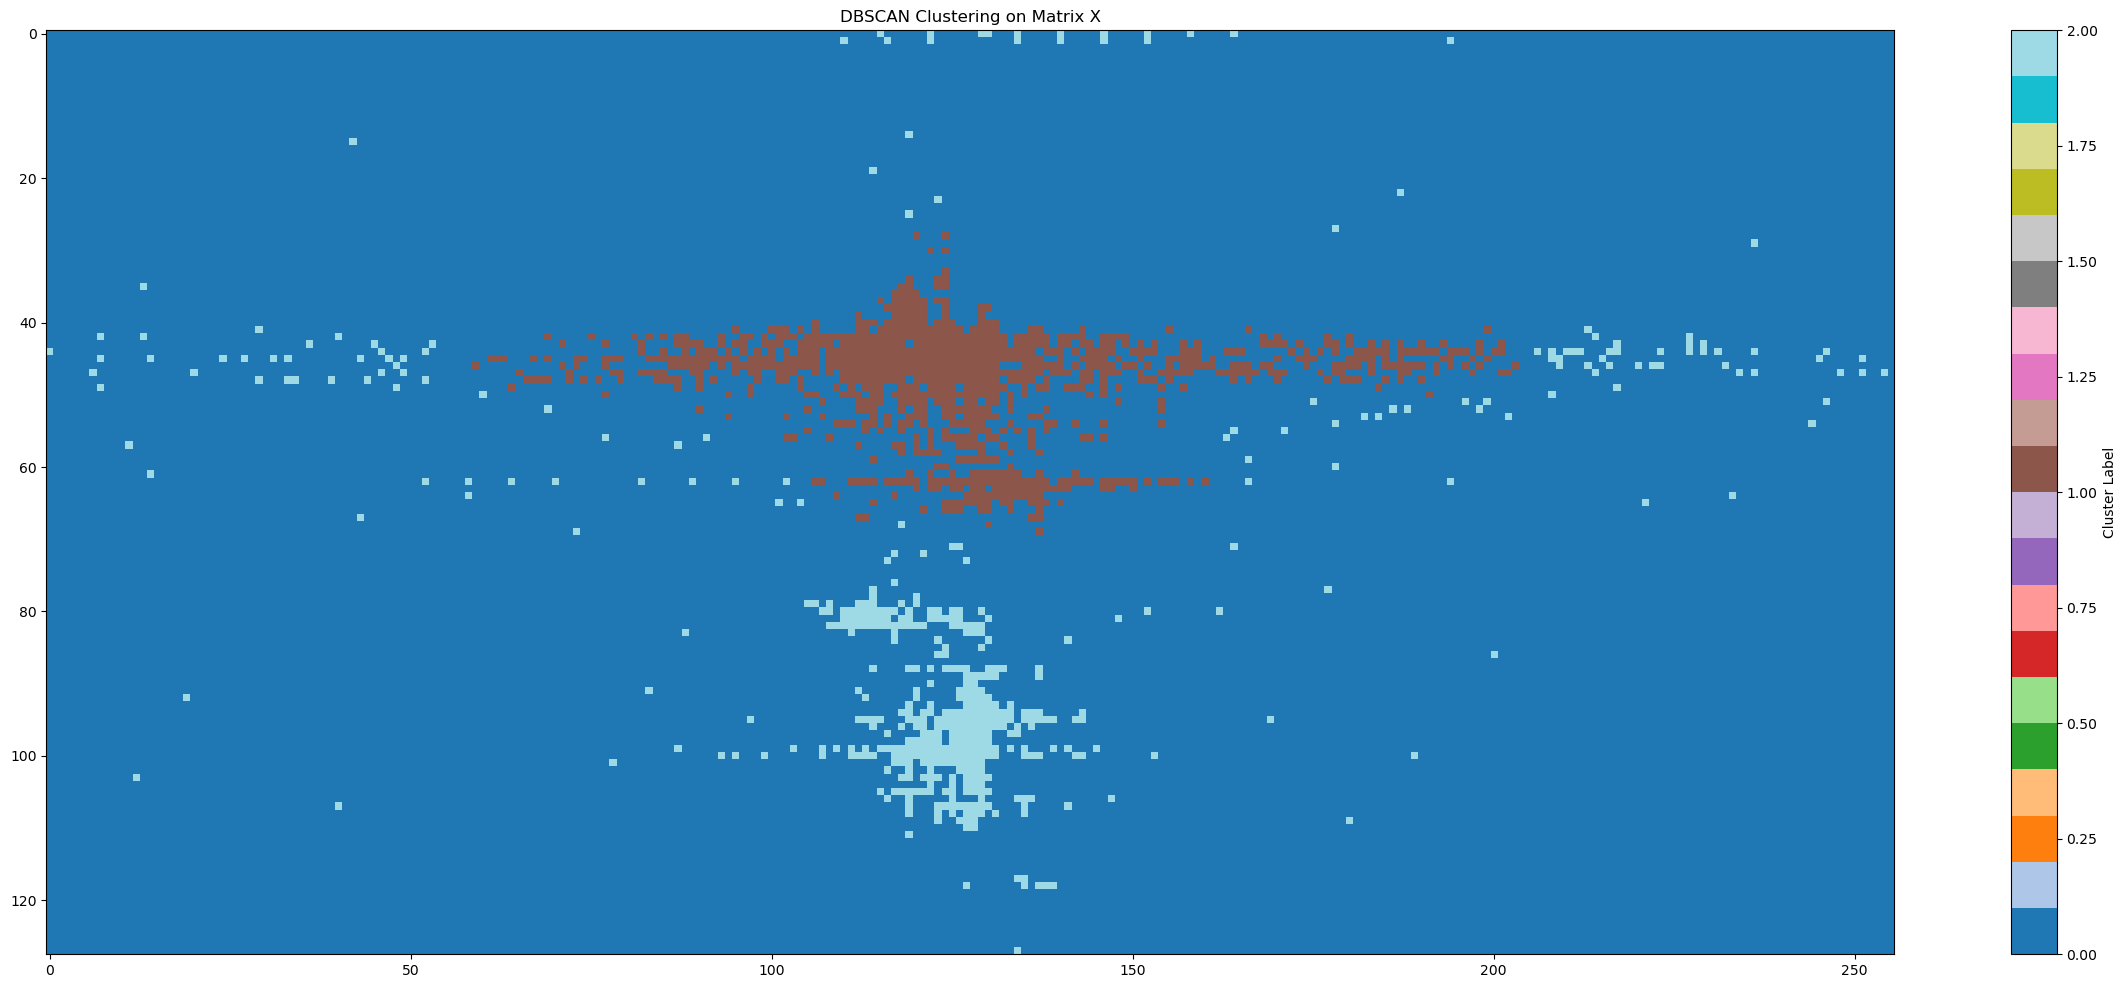

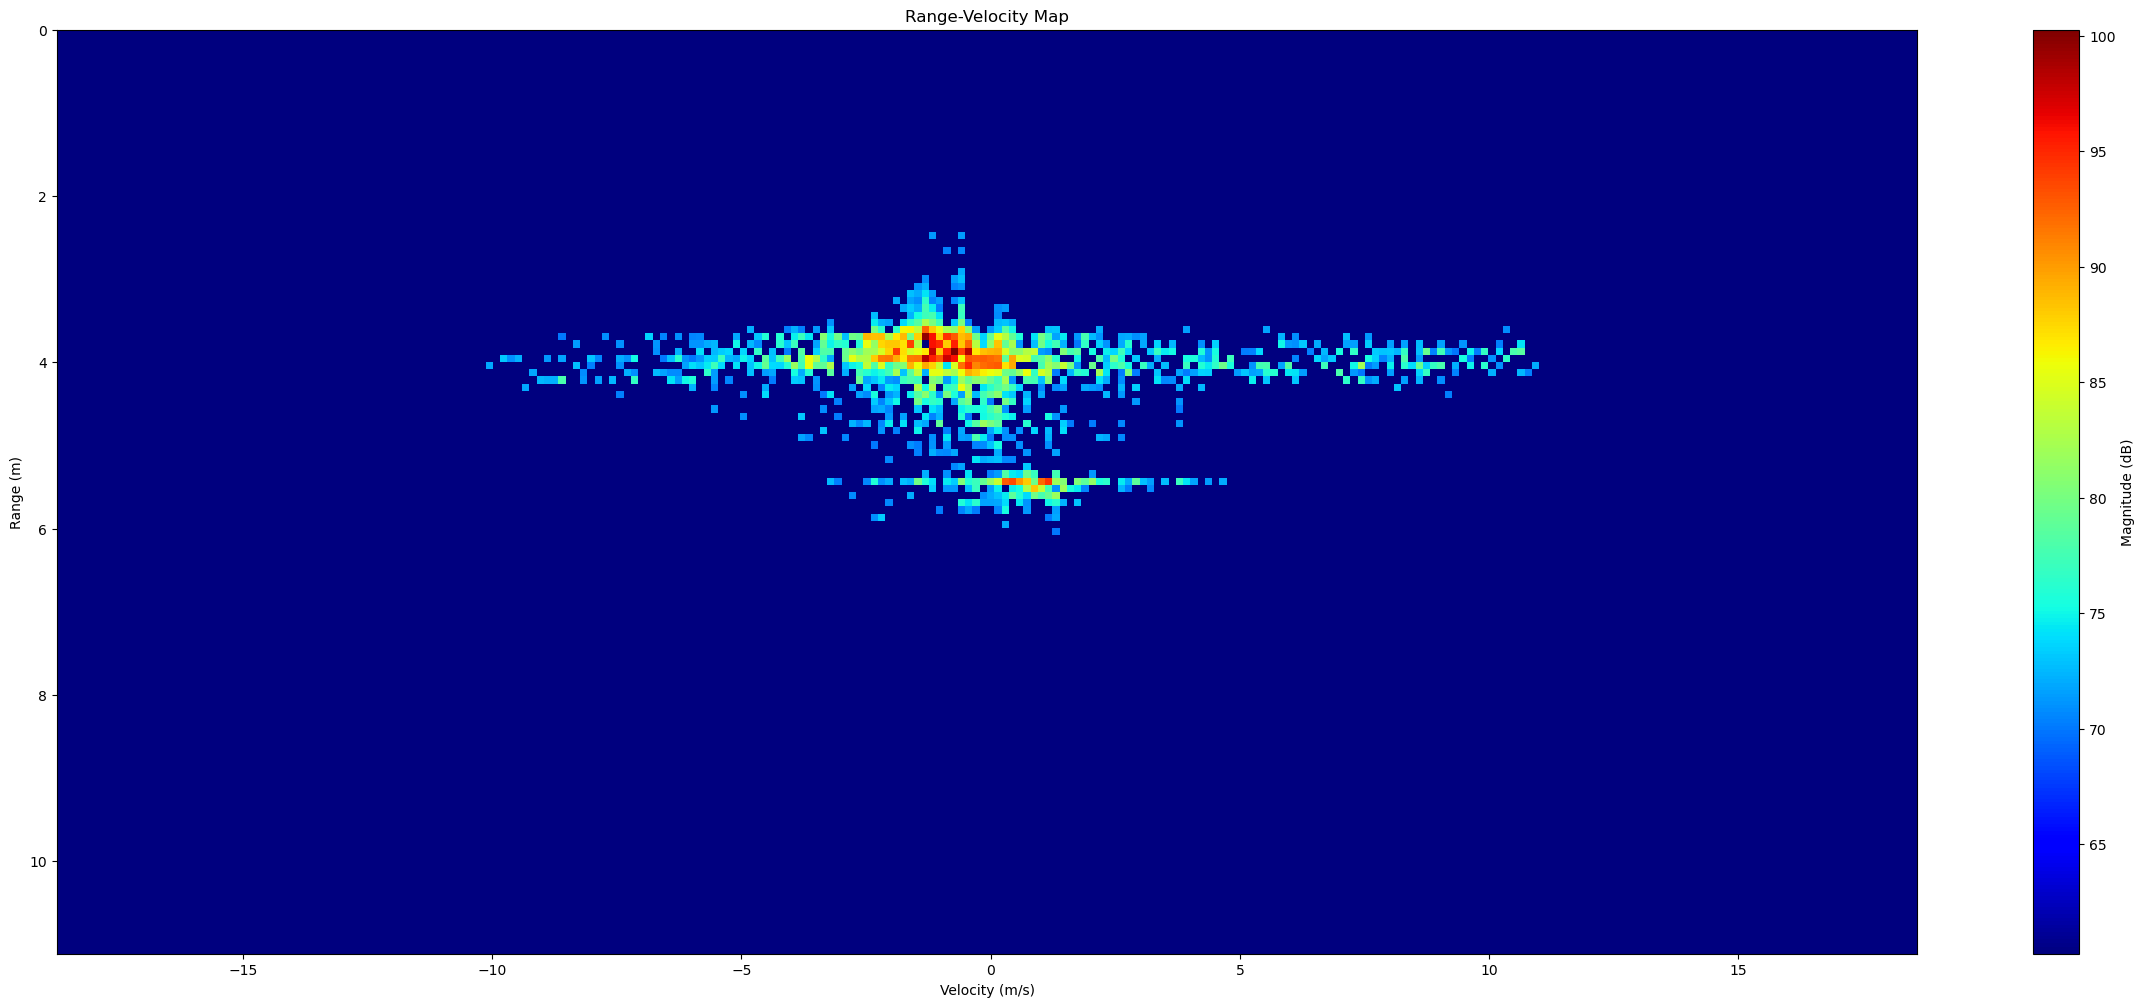

In [18]:
for i in range (10):
    plot_original(i)
    plot_af_cluster(i)
    plot_final(i)

In [19]:
def keep_top_N_elements(matrix,N):
    flat_matrix = matrix.flatten()
    top_100_values = np.partition(flat_matrix, -N)[-N:]
    top_100_indices = np.isin(flat_matrix, top_100_values)
    result_matrix = np.zeros_like(matrix)
    result_matrix.flat[top_100_indices] = flat_matrix[top_100_indices]
    
    return result_matrix

In [20]:
def plot_keep_N(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = DBSCAN(eps=3, min_samples=3)
    labels = db.fit_predict(indices)
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [0 if label == most_frequent_label else 1 for label in labels]

    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
            Y[indices[i, 0], indices[i, 1]] = label # Gán nhãn bắt đầu từ 1

    output_test = output_test - 30 * Y
    output_test = keep_top_N_elements(output_test,N)
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]-25, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

In [21]:
def plot_keep_N_ghost(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    
    output_test = keep_top_N_elements(output_test,N)
    # Plot the Range-Velocity Map
    plt.figure(figsize=(30, 12))
    im =plt.imshow(output_test, aspect='auto', cmap='jet', extent=[velocity_bins.min(), velocity_bins.max(), R_max, 0])
    # Set the colorbar limits
    clim = im.get_clim()
    im.set_clim(clim[1]-25, clim[1])
    plt.title('Range-Velocity Map')
    plt.ylabel('Range (m)')
    plt.xlabel('Velocity (m/s)')
    plt.colorbar(label='Magnitude (dB)')
    plt.show()

In [22]:
def find_median_x(coords):
    # Lấy danh sách các hoành độ từ cột đầu tiên của mảng numpy
    x_coords = coords[:, 1]  # Cột đầu tiên là tung độ
    
    # Sắp xếp danh sách hoành độ
    x_coords.sort()
    
    # Tìm hoành độ trung bình (median)
    n = len(x_coords)
    if n % 2 == 1:
        # Nếu số điểm là lẻ, median là giá trị tại giữa
        median_x = x_coords[n // 2]
    else:
        # Nếu số điểm là chẵn, median là trung bình của hai giá trị giữa
        median_x = (x_coords[n // 2 - 1] + x_coords[n // 2]) / 2
        
    return median_x

In [23]:
def cal_vec(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    
    output_test_2 = np.copy(output_test)
    output_test_2[output_test > 70] = 100
    output_test_2[output_test <= 70] = 0
    indices = np.column_stack(np.where(output_test_2 == 100))
    db = DBSCAN(eps=3, min_samples=3)
    labels = db.fit_predict(indices)
    label_counts = Counter(labels)
    most_frequent_label = label_counts.most_common(1)[0][0]
    new_labels = [0 if label == most_frequent_label else 1 for label in labels]

    Y = np.zeros_like(output_test)
    for i, label in enumerate(new_labels):
        if label != -1:  # -1 là chỉ các điểm nhiễu (outliers) trong DBSCAN
            Y[indices[i, 0], indices[i, 1]] = label # Gán nhãn bắt đầu từ 1

    output_test = output_test - 30 * Y
    output_test = keep_top_N_elements(output_test,N)

    indices_2 = np.column_stack(np.where(output_test > 1))
    torso_vec = int(find_median_x(indices_2))

    return(torso_vec)

In [24]:
def cal_vec_with_ghost(i,N):
    data_test = doppler_fft_without_butter(data[i].T)
    doppler_magnitude = np.abs(data_test)
    velocity_bins = np.fft.fftfreq(Nc, d=1/Nc) * velocity_res
    # Shift zero-frequency component to center of spectrum
    doppler_magnitude = np.fft.fftshift(doppler_magnitude, axes=1)
    velocity_bins = np.fft.fftshift(velocity_bins)

    output_test = 20 * np.log10(doppler_magnitude)

    output_test = update_column(output_test,128)
    output_test = keep_top_N_elements(output_test,N)

    indices_2 = np.column_stack(np.where(output_test > 1))
    torso_vec = int(find_median_x(indices_2))

    return(torso_vec)

In [25]:
def plot_vec_ghost(N):
    vec_time_with_ghost = np.zeros(267)
    for i in range(267): 
        vec_time_with_ghost[i] = cal_vec_with_ghost(i,N)

    data_final_2 = (vec_time_with_ghost / 256) * 37.4 - 18.7
    x = list(range(len(data_final_2)))

    # Trục tung là giá trị của các phần tử trong mảng
    y = data_final_2

    plt.figure(figsize=(30, 12))
    # Vẽ đồ thị
    plt.plot(x, y, marker='o')

    # Gán nhãn trục
    plt.xlabel('Frame')
    plt.ylabel('Vận tốc thân')

    plt.title(f'Đồ thị vận tốc theo frame (chưa lọc) - Giá trị i = {N}')
    # Hiển thị đồ thị

    plt.show()

In [26]:
def plot_vec(N):
    vec_time = np.zeros(267)
    for i in range(267): 
        vec_time[i] = cal_vec(i,N)

    data_final = (vec_time / 256) * 37.4 - 18.7
    x = list(range(len(data_final)))

    # Trục tung là giá trị của các phần tử trong mảng
    y = data_final

    plt.figure(figsize=(30, 12))
    # Vẽ đồ thị
    plt.plot(x, y, marker='o')

    # Gán nhãn trục
    plt.xlabel('Frame')
    plt.ylabel('Vận tốc thân')
    plt.title(f'Đồ thị vận tốc theo frame (đã lọc) - Giá trị i = {N}')
    # Hiển thị đồ thị

    plt.show()

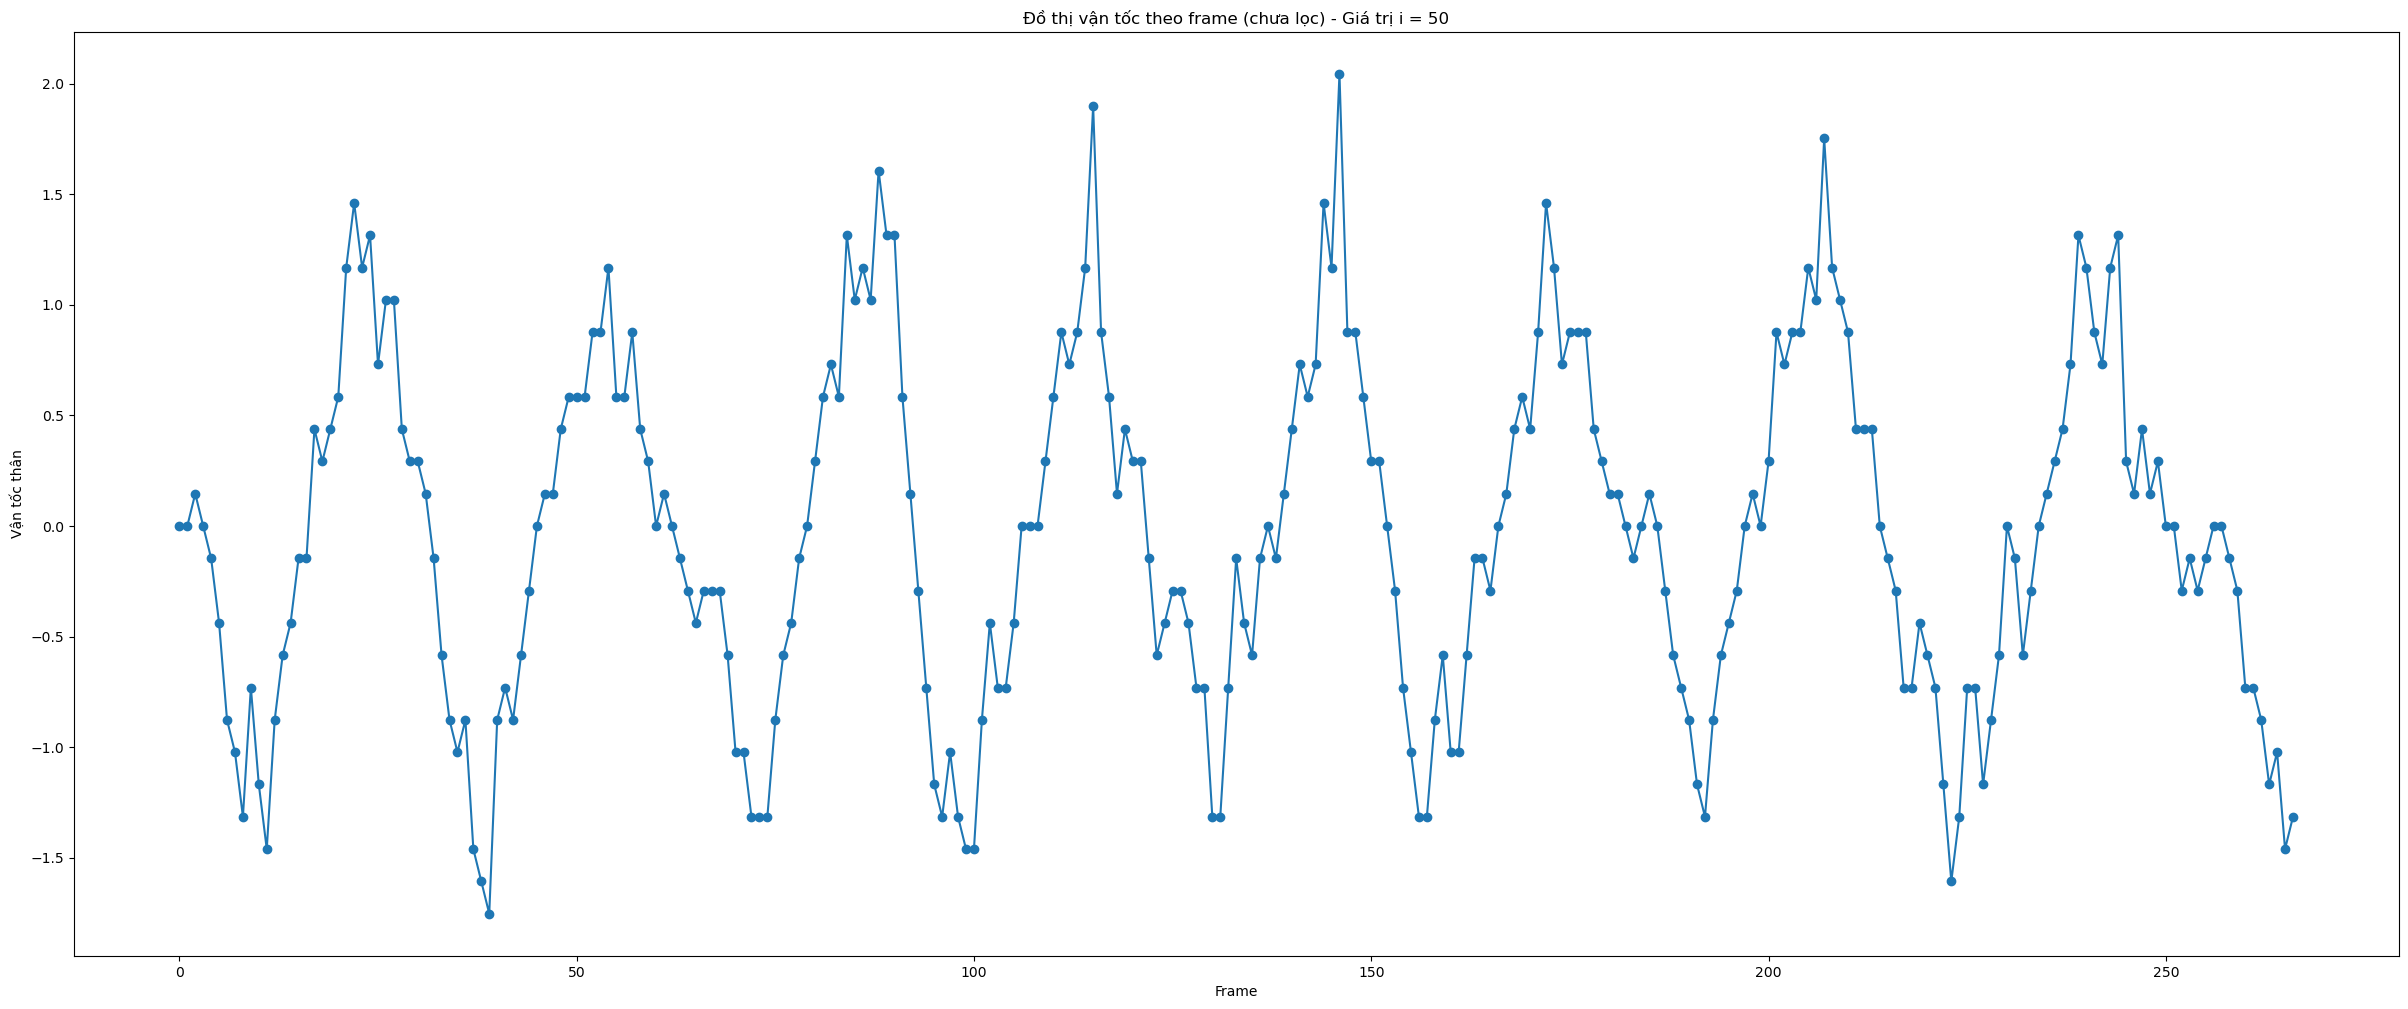

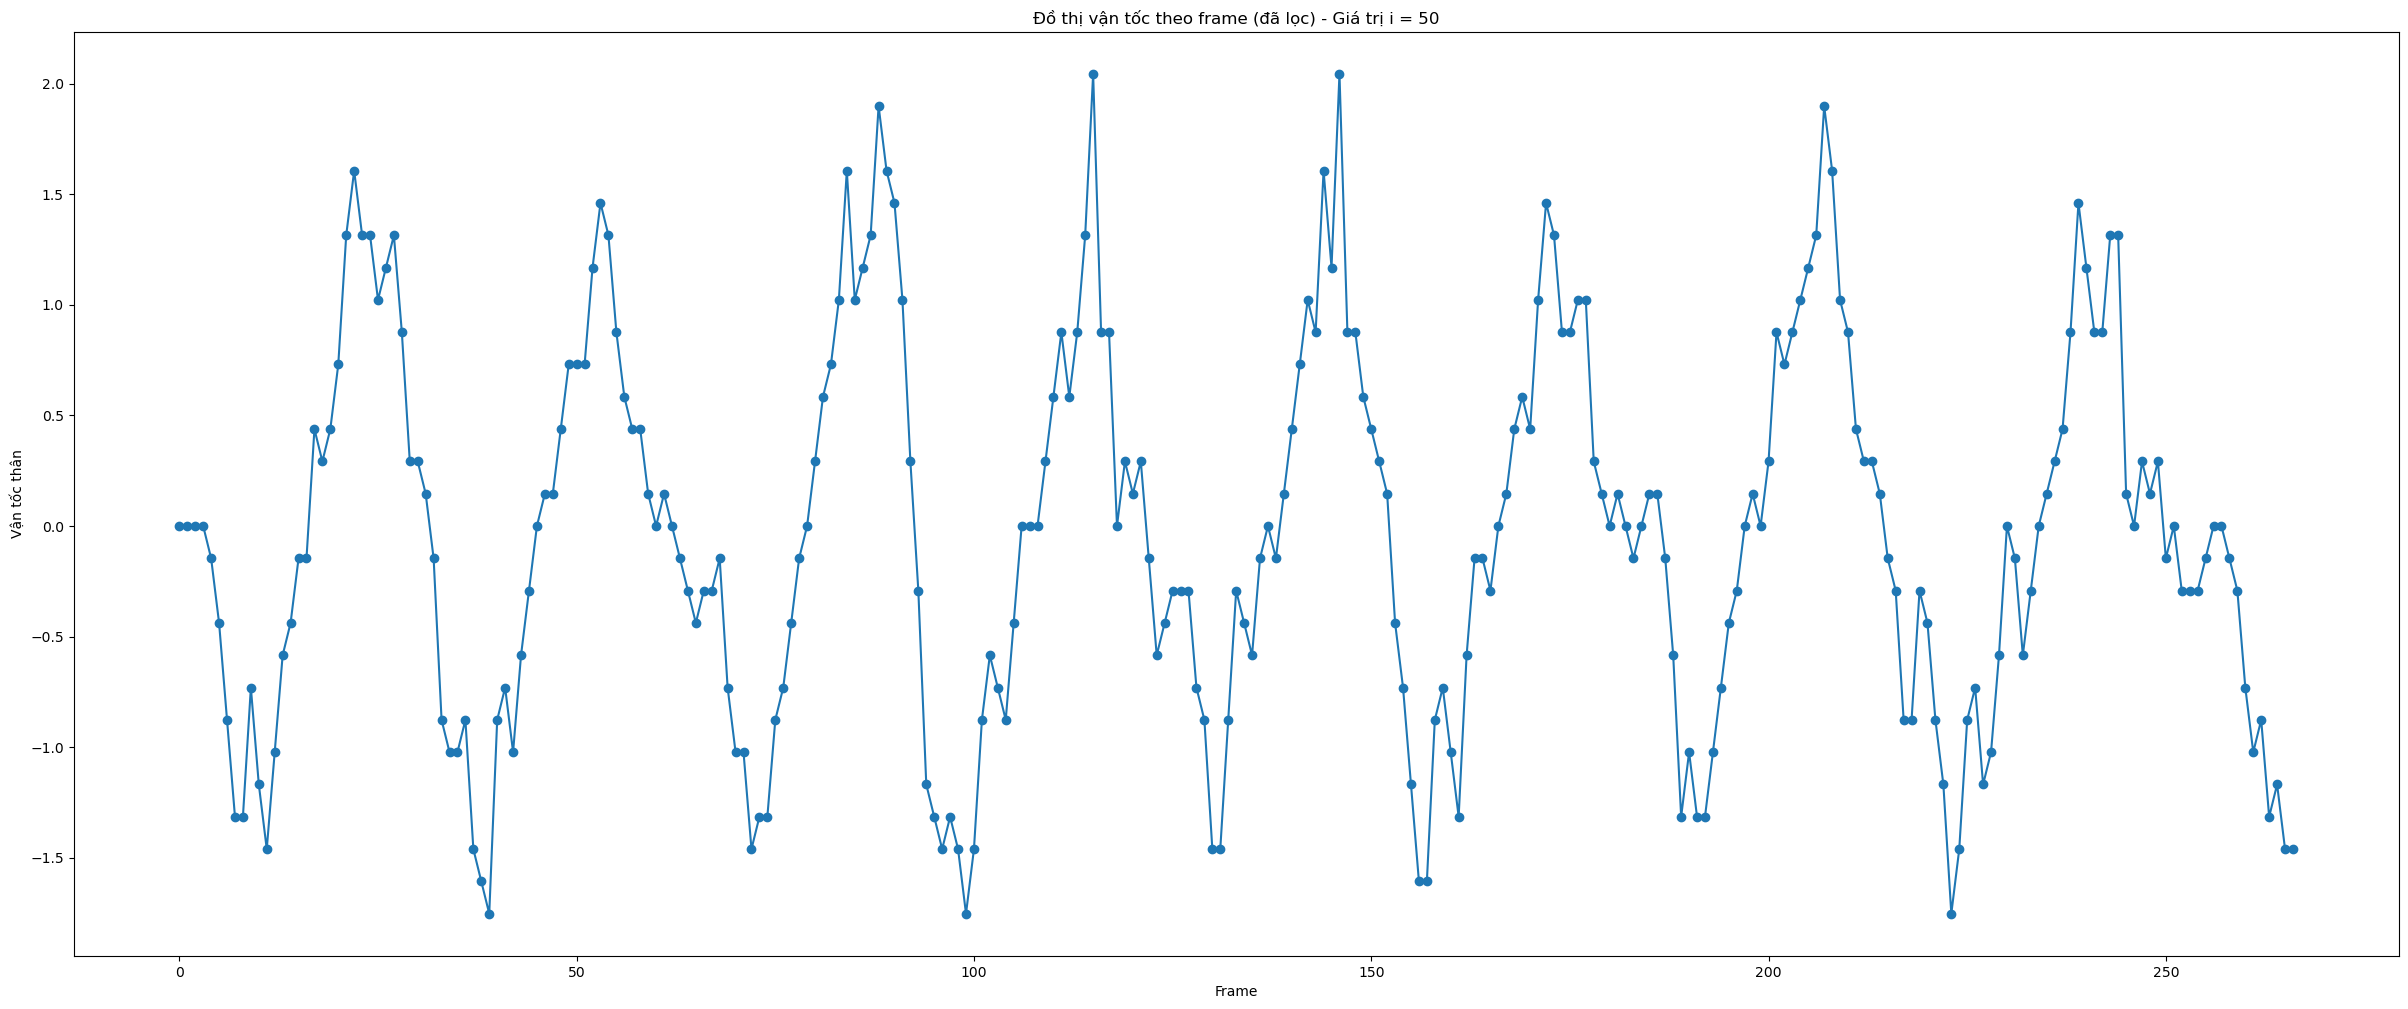

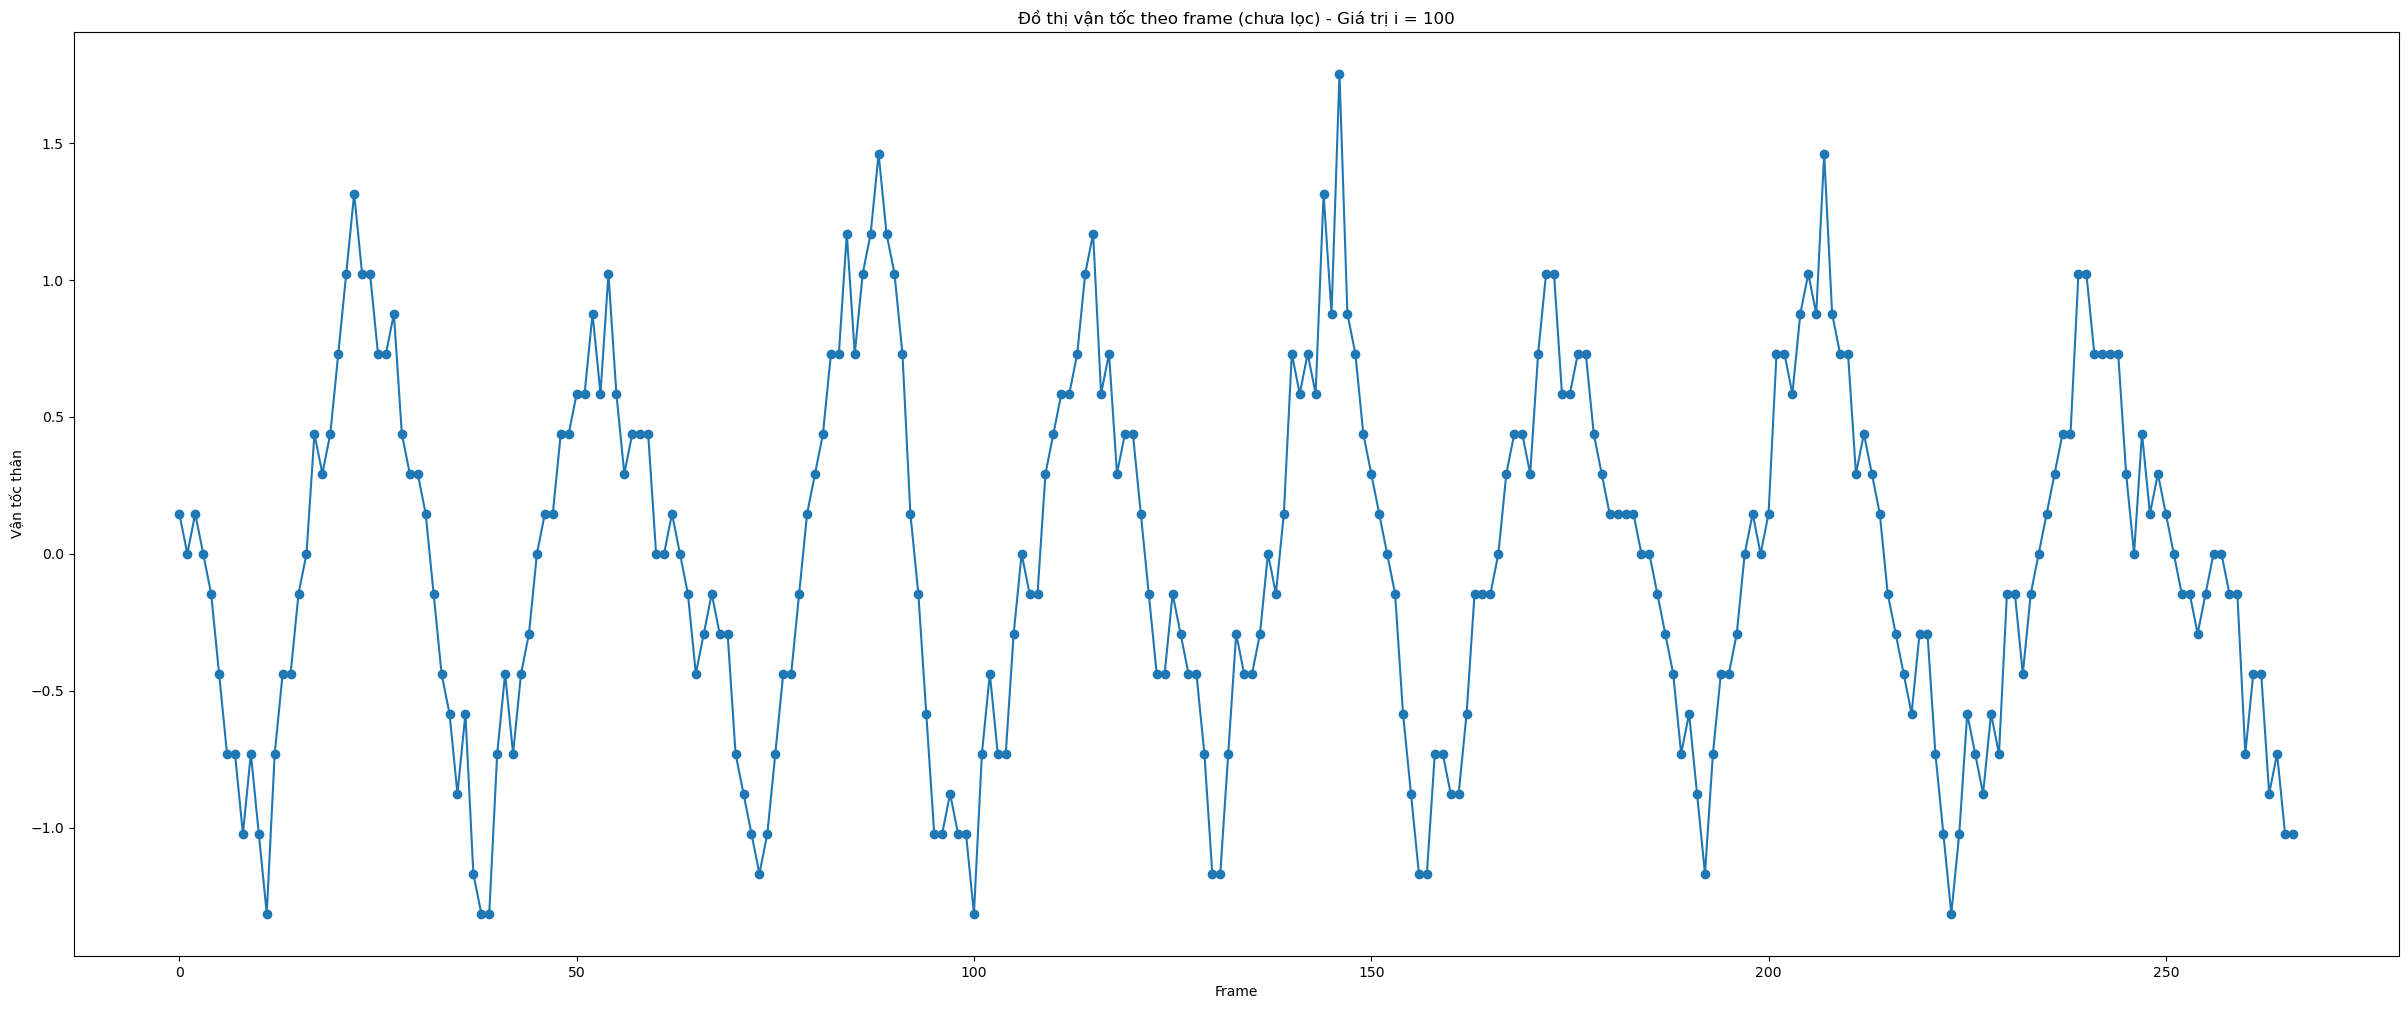

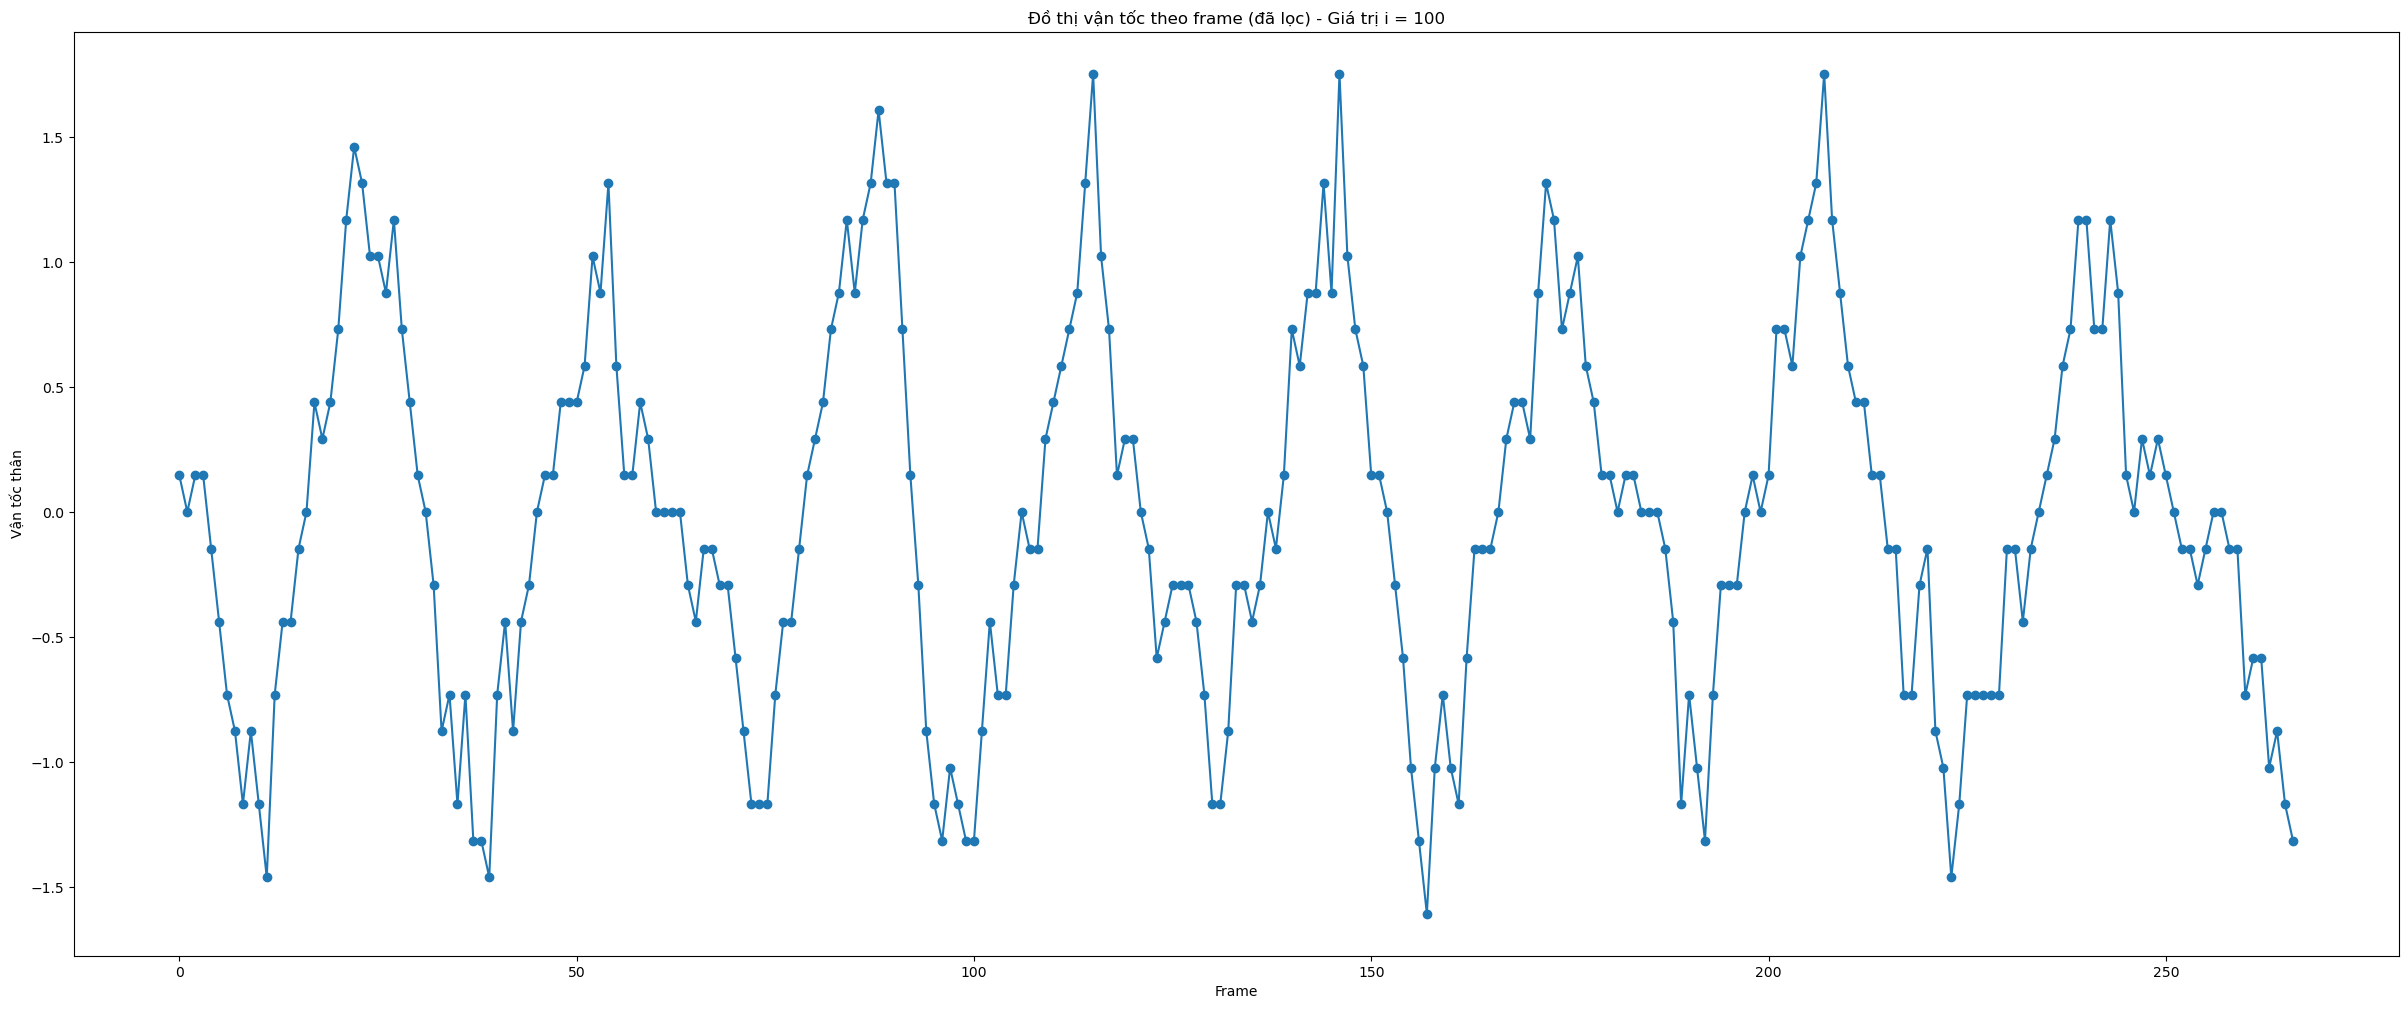

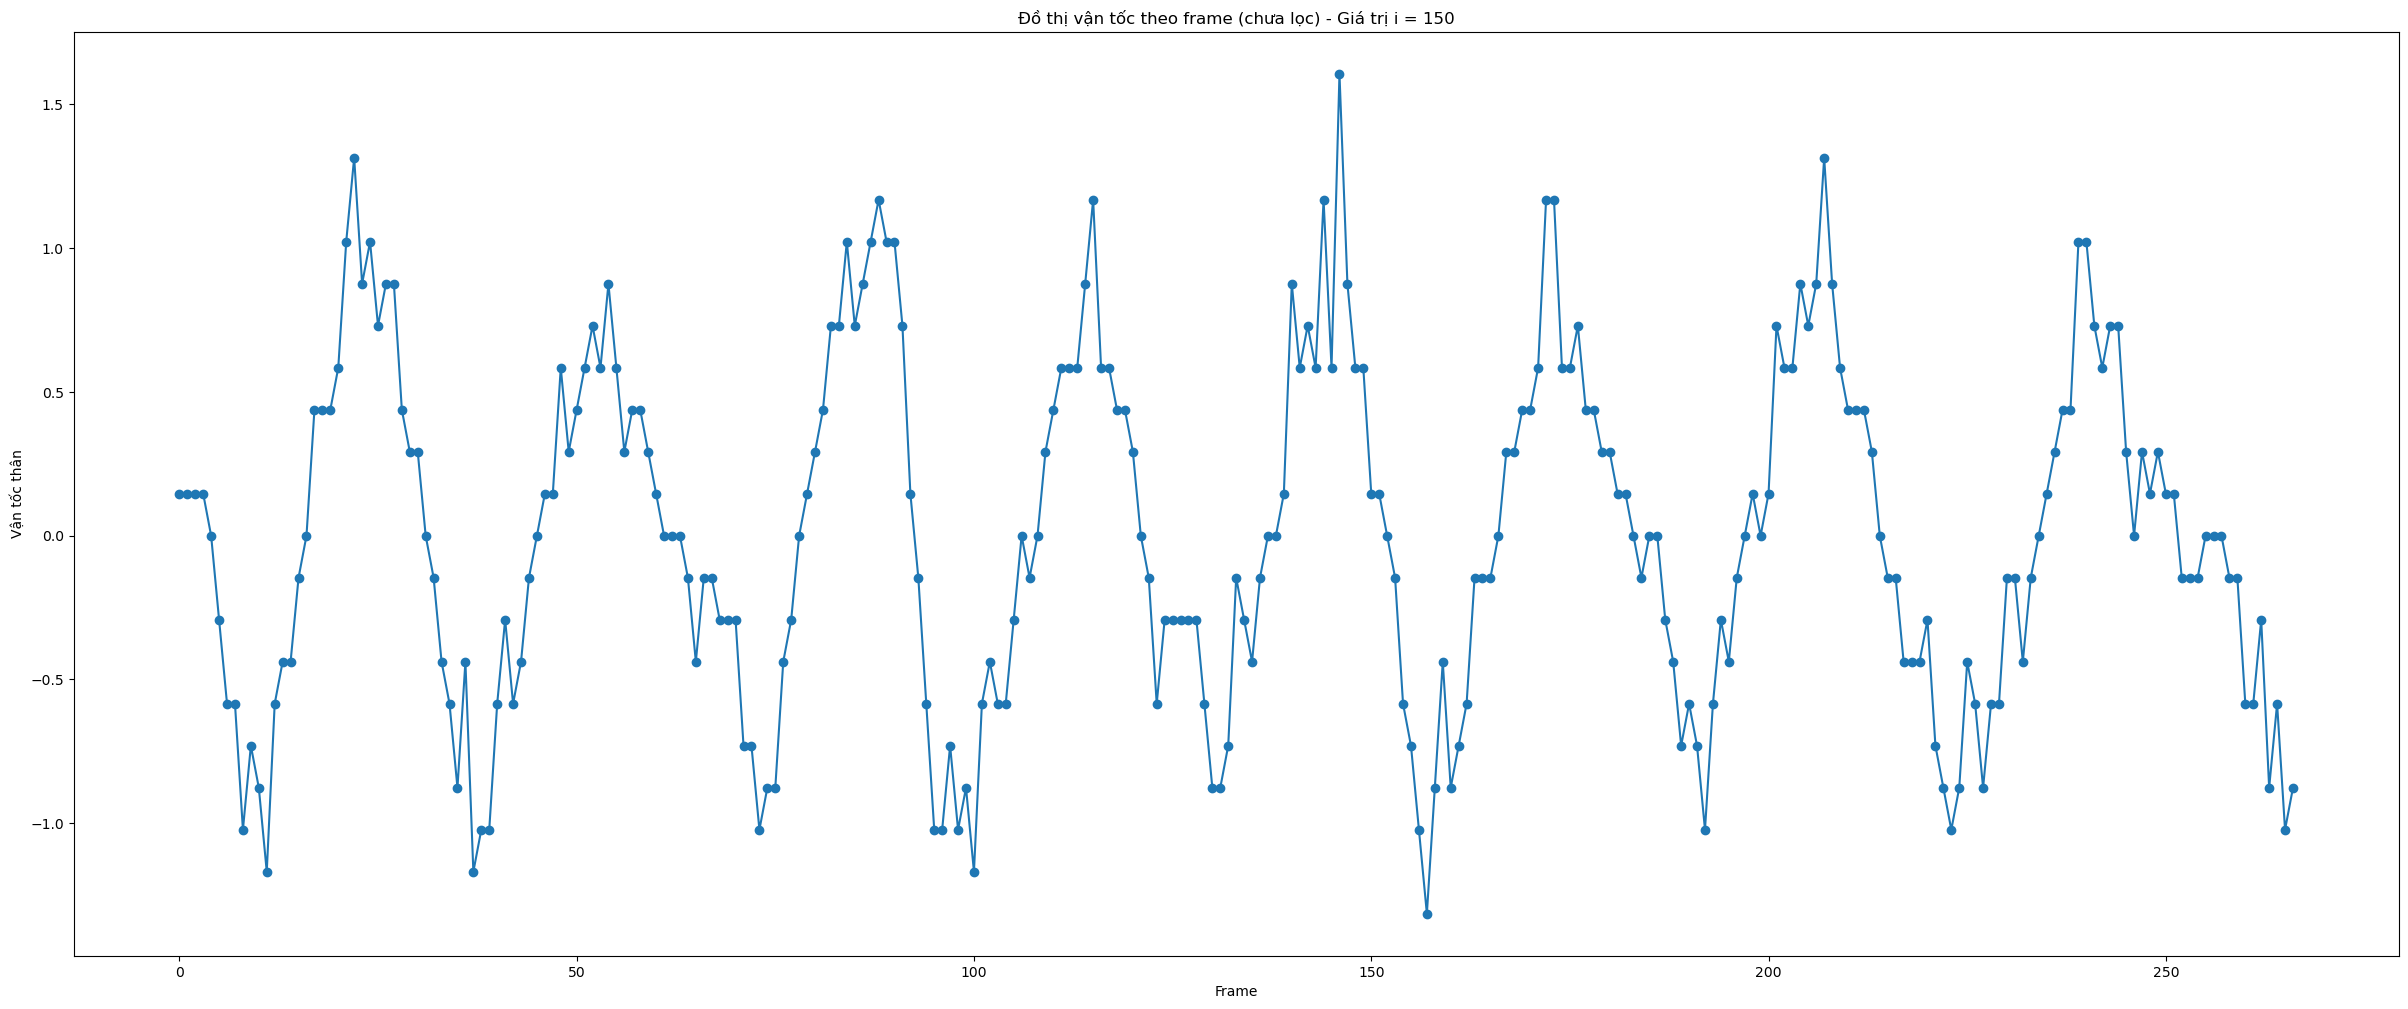

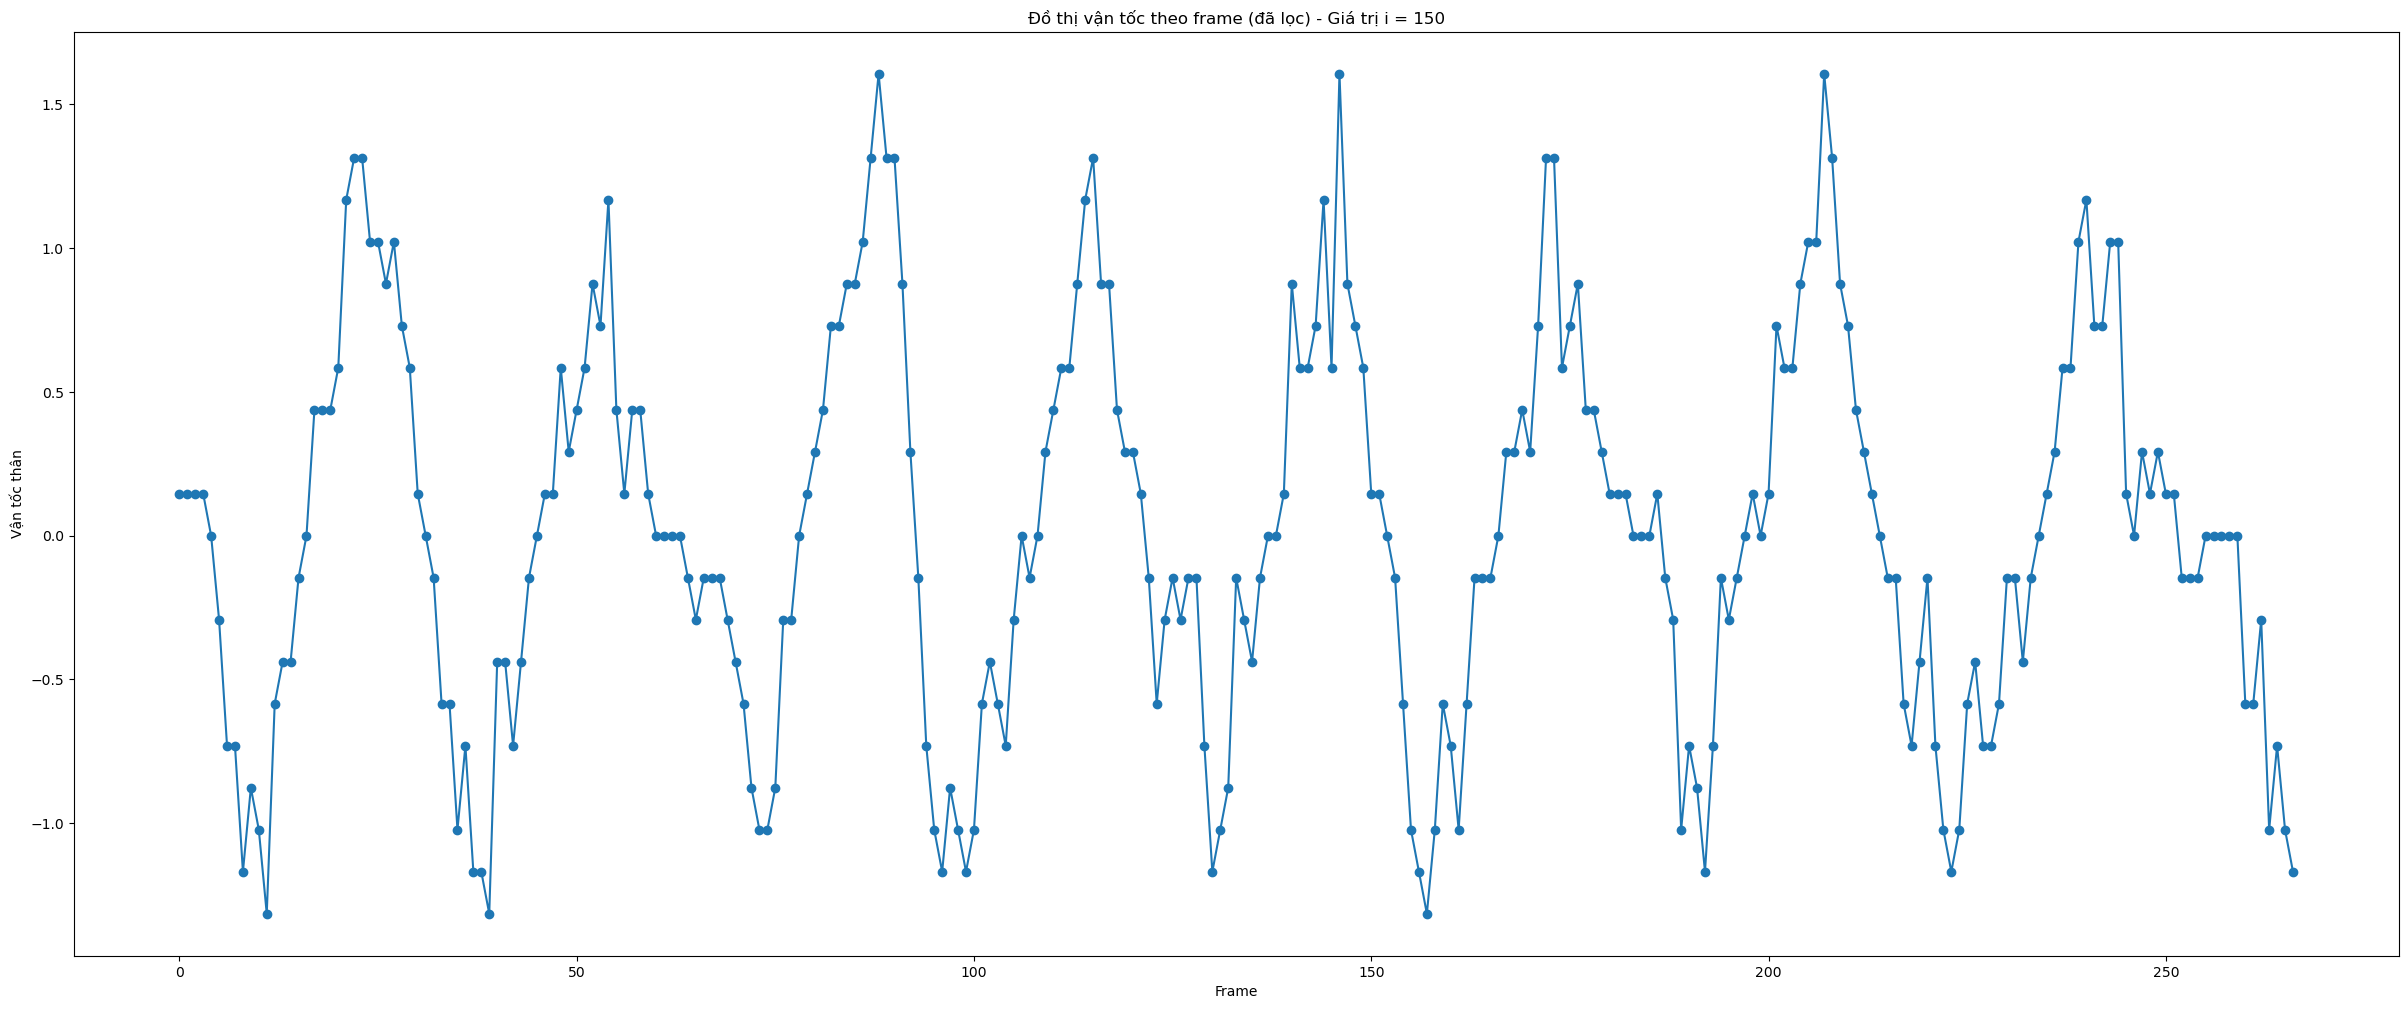

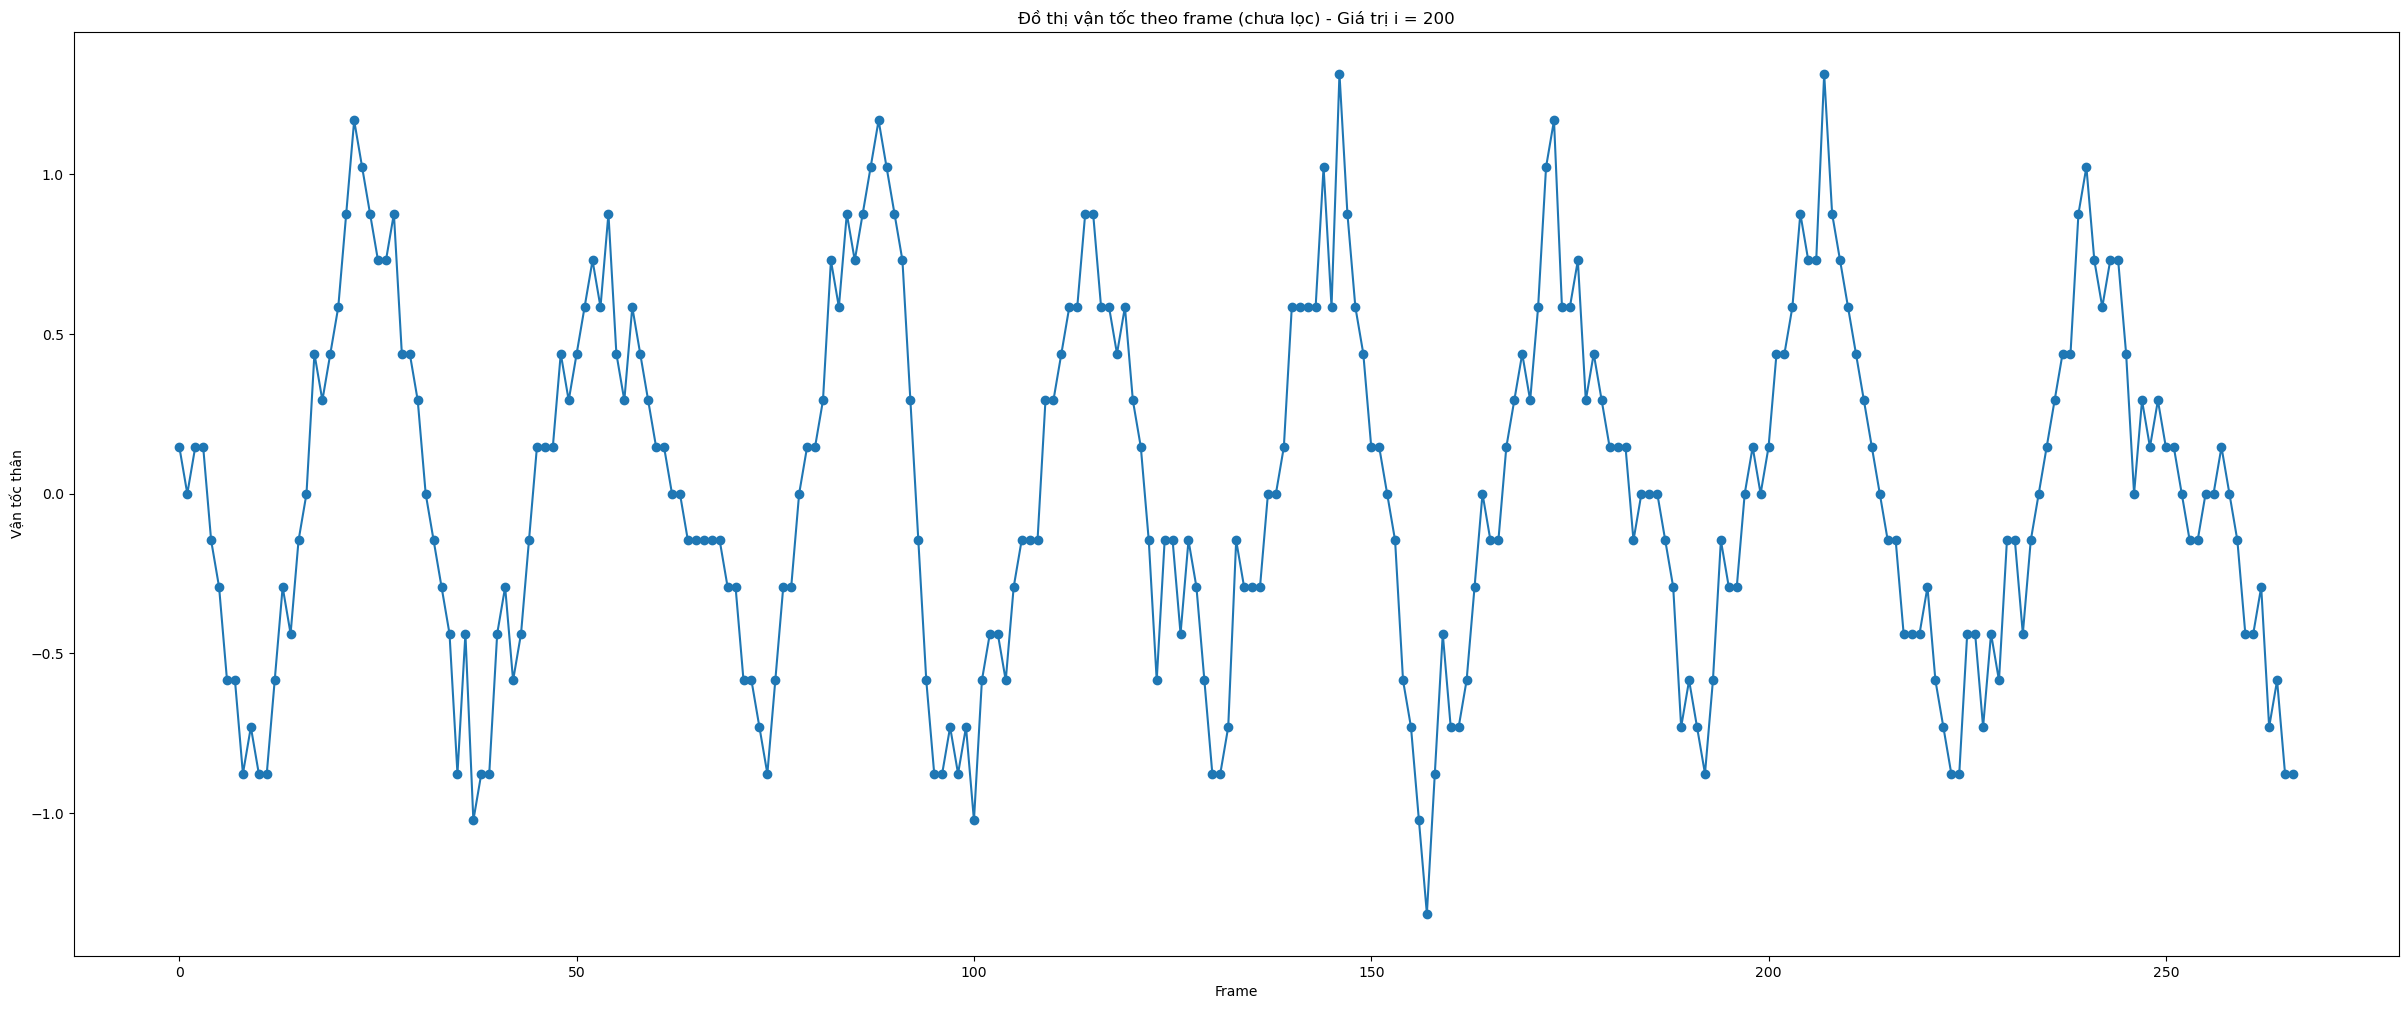

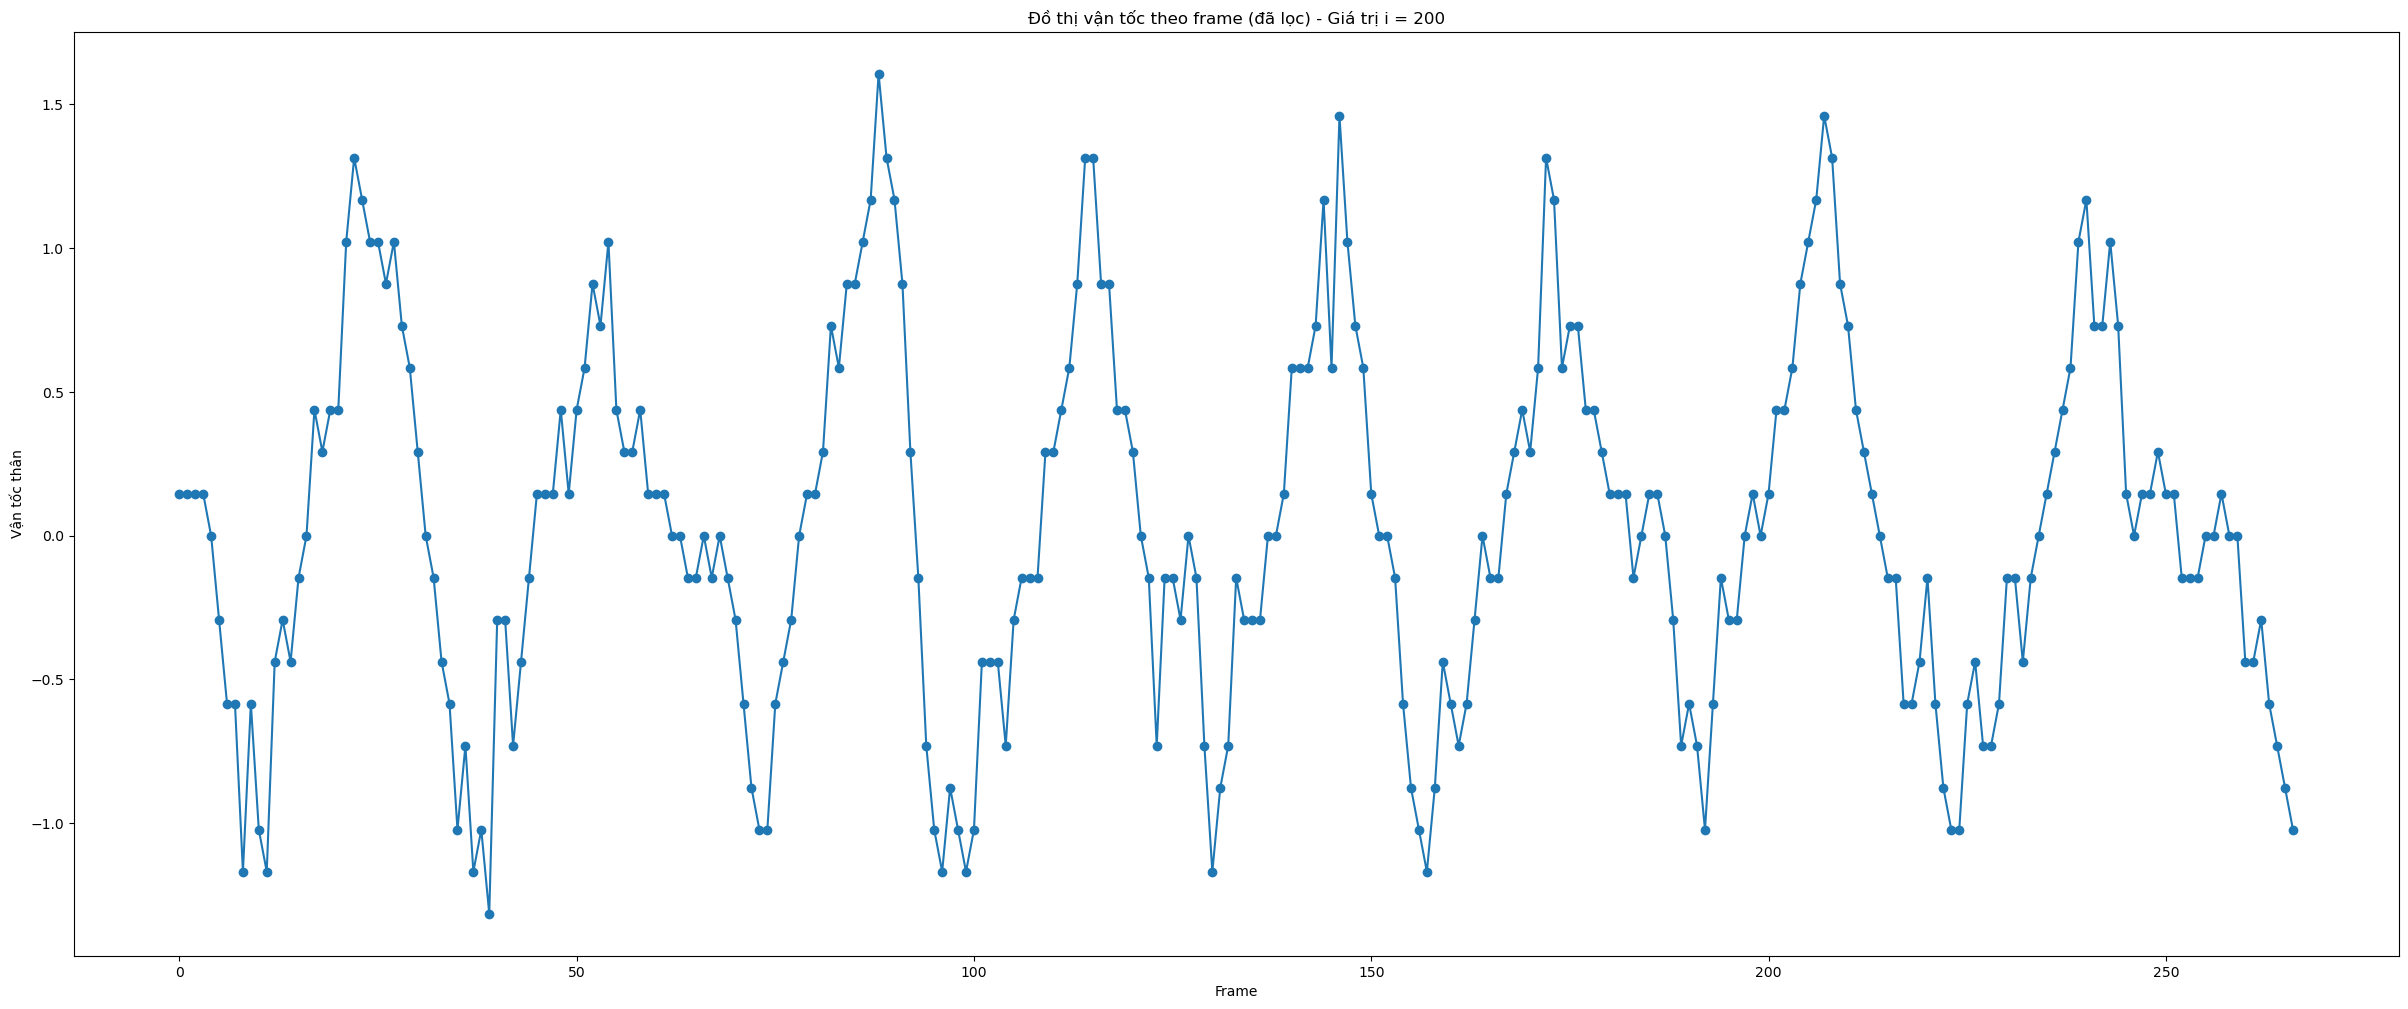

In [27]:
for i in range(50,250,50):
    plot_vec_ghost(i)
    plot_vec(i)